# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        data = ' '.join(data.split())
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    text = []
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = i
          i += 1
        text.append(voc2ind[char])
    text = np.array(text)


    ind2voc = {val: key for key, val in voc2ind.items()}

    index = int(len(text) * 0.8)
    train_text = text[:index]
    test_text = text[index:] 

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
import math
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
            dataset = dataset['tokens']
            dataset = dataset[:self.batch_size * (len(dataset) // self.batch_size)]

        self.data = []
        self.leftover_bits = []
        num_batches = math.ceil((len(dataset) - self.batch_size) / (self.batch_size * self.sequence_length))
        for i in range(num_batches):
          temp_data = []
          for j in range(self.batch_size):
            chunk_start = j * len(dataset) // self.batch_size + i * self.sequence_length
            if i * self.sequence_length + self.sequence_length > (len(dataset) // self.batch_size - 1):
              num_left = (len(dataset) // self.batch_size - 1) - i * self.sequence_length
              temp_data.append(dataset[chunk_start:chunk_start + num_left])
              self.leftover_bits.append(dataset[chunk_start + num_left])
            else:
              temp_data.append(dataset[chunk_start: chunk_start + self.sequence_length])

          self.data.append(temp_data)


    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
         return len(self.data) * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        i = idx // self.batch_size
        j = idx % self.batch_size
        data = self.data[i][j].tolist()
        labels = data[1:]
        labels = labels + [(self.data[i + 1][j][0] if i + 1 < len(self.data) else self.leftover_bits[j])]
        return torch.LongTensor(data), torch.LongTensor(labels)

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      token = torch.argmax(output)
      outputs.append(token)
      output, hidden = model.inference(token,hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
      token = torch.multinomial(output, 1)
      outputs.append(token)
      output, hidden = model.inference(token, hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]

    for ii in range(sequence_length):
      new_beams = []
      for beam in beams:
        output, hidden = beam[1], beam[2]
        tokens = torch.multinomial(output, beam_width, replacement=True)
        for token in tokens[0]:
            sentence = list(beam[0])
            sentence.append(token)
            score = torch.log(output[0][token]) + beam[3]
            output, new_hidden = model.inference(token, hidden)
            new_beams.append((sentence, output, new_hidden, score))
      beams = sorted(new_beams, key=lambda x: x[3], reverse=True)[:beam_width]
    top_sentence = beams[0][0]
    return top_sentence

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	JllX1J%]h7l_] ZZZ]"A:AAZ HlH4h3q$s"]R-\""L]V-]]&qFqql{]V"J--&&FqN"]hl\P&qFh 4i$qVSmXmmmm7mmFqhm\P]!J


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	XSmm1&]R7"] O$1n]R-\"6] :ZZ! mmmms"":"&Zh=:z(e& X1]" R4q74$1]$7"]]]&qme VJ%""]R7 $O::]]"&Z$7"]RX""\R


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	7I"n74L]lqZZZX7==74Lq74]$7"]:]PP&%] 1]$7"]Z m4q!VH_]l$w1""h74]!11(:1APA&]" X]\41]]1mm]G("]:1:A:$R!Jm


Input	 hel

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 15.7281, Accuracy: 12259/1254400 (1%)



  1%|          | 1/195 [00:00<00:35,  5.51it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 15.763135


  7%|▋         | 13/195 [00:01<00:16, 11.16it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 11.254909


 12%|█▏        | 23/195 [00:01<00:13, 12.45it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 5.843039


 17%|█▋        | 33/195 [00:02<00:12, 12.64it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.792365


 22%|██▏       | 43/195 [00:03<00:11, 12.67it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.788149


 27%|██▋       | 53/195 [00:04<00:11, 12.63it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.394183


 32%|███▏      | 63/195 [00:05<00:10, 12.63it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 3.582603


 37%|███▋      | 73/195 [00:05<00:09, 12.66it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 3.658552


 43%|████▎     | 83/195 [00:06<00:09, 12.44it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.604054


 48%|████▊     | 93/195 [00:07<00:08, 12.62it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.174087


 53%|█████▎    | 103/195 [00:08<00:07, 12.41it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.980499


 58%|█████▊    | 113/195 [00:09<00:06, 12.68it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.977358


 63%|██████▎   | 123/195 [00:09<00:05, 12.39it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.458542


 68%|██████▊   | 133/195 [00:10<00:05, 12.37it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 3.135269


 73%|███████▎  | 143/195 [00:11<00:04, 12.56it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 2.343768


 78%|███████▊  | 153/195 [00:12<00:03, 12.66it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.995987


 84%|████████▎ | 163/195 [00:13<00:02, 12.50it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.860193


 89%|████████▊ | 173/195 [00:13<00:01, 12.40it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.786917


 94%|█████████▍| 183/195 [00:14<00:00, 12.44it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.746548


 99%|█████████▉| 193/195 [00:15<00:00, 12.66it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.898187


100%|██████████| 195/195 [00:15<00:00, 12.49it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rdaaadhaadhttrd aaartd atain,t ahe dare yaaasl  "W d eaarke... "e gaid  "Won't yauky' wagt" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eueed ahe mft r aare  and aarry aead d aumbledore aeck an o the fnk.laer yed,ahet arrl d ahe maeaeae


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	le  ng ard arappeng an ahe cagdeeaaf ahe mark aashtaiuuad!an aagwmealed "rr af  wiw ibeedairent,aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harrys.... a all.... he was all a ragical adame all.... and fall... and a adame a all... a arry all... he was a all.... a all... he arry reall.... a all... and a aled a all atter in it... Sh a was at 



  1%|          | 2/195 [00:00<00:35,  5.50it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.886340


  6%|▌         | 12/195 [00:01<00:18, 10.15it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.856758


 11%|█▏        | 22/195 [00:01<00:14, 11.89it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.800540


 16%|█▋        | 32/195 [00:02<00:13, 12.25it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.738963


 22%|██▏       | 42/195 [00:03<00:12, 12.29it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.851312


 27%|██▋       | 52/195 [00:04<00:11, 12.27it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 2.005506


 32%|███▏      | 62/195 [00:05<00:10, 12.33it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.875481


 37%|███▋      | 72/195 [00:06<00:10, 12.29it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.729529


 42%|████▏     | 82/195 [00:06<00:09, 12.28it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.651223


 47%|████▋     | 92/195 [00:07<00:08, 12.39it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.645009


 52%|█████▏    | 102/195 [00:08<00:07, 12.38it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.667200


 57%|█████▋    | 112/195 [00:09<00:06, 12.28it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.655354


 63%|██████▎   | 122/195 [00:10<00:05, 12.25it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.678893


 68%|██████▊   | 132/195 [00:10<00:05, 12.31it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.707302


 73%|███████▎  | 142/195 [00:11<00:04, 12.31it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.640947


 78%|███████▊  | 152/195 [00:12<00:03, 12.32it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.617077


 83%|████████▎ | 162/195 [00:13<00:02, 12.28it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.620734


 88%|████████▊ | 172/195 [00:14<00:01, 12.34it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.636863


 93%|█████████▎| 182/195 [00:14<00:01, 12.35it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.705605


 98%|█████████▊| 192/195 [00:15<00:00, 12.35it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.955769


100%|██████████| 195/195 [00:16<00:00, 12.18it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsream oolh ond Hovvdd onann.  ohe cane yooask  HW sneHaake .  He said  HWon'  yauky  Hoge  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused ohe sug   oane  Ind Herry saaped oumbledore ceck on o she cnk oeer yed.shan sone   ooe caeaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	le yng hnd Heenpeng hn hhe cageee of she ceyk oash snuue  on hagsmeade  Huu sue oau yble oeueno oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry suded ould ou see of nome of nome oune everyone of suppose for and every oudder for every every every looked loked up and oud every every looked up was ound ouse of his eyer fell oude for se of 



  1%|          | 2/195 [00:00<00:35,  5.48it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 2.367768


  6%|▌         | 12/195 [00:01<00:17, 10.27it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.936337


 11%|█▏        | 22/195 [00:01<00:14, 11.89it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.711609


 16%|█▋        | 32/195 [00:02<00:13, 12.03it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.616677


 22%|██▏       | 42/195 [00:03<00:12, 12.19it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.580925


 27%|██▋       | 52/195 [00:04<00:11, 12.11it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.622962


 32%|███▏      | 62/195 [00:05<00:11, 12.06it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.603552


 37%|███▋      | 72/195 [00:06<00:10, 11.96it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.566429


 42%|████▏     | 82/195 [00:06<00:09, 11.92it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.532862


 47%|████▋     | 92/195 [00:07<00:08, 12.05it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.537995


 52%|█████▏    | 102/195 [00:08<00:07, 11.80it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.556487


 57%|█████▋    | 112/195 [00:09<00:07, 11.83it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.547070


 63%|██████▎   | 122/195 [00:10<00:06, 11.81it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.566463


 68%|██████▊   | 132/195 [00:11<00:05, 11.91it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.596195


 73%|███████▎  | 142/195 [00:11<00:04, 11.90it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.675845


 78%|███████▊  | 152/195 [00:12<00:03, 11.67it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.578719


 83%|████████▎ | 162/195 [00:13<00:02, 11.93it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.537755


 88%|████████▊ | 172/195 [00:14<00:01, 11.90it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.519549


 93%|█████████▎| 182/195 [00:15<00:01, 11.92it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.504108


 98%|█████████▊| 192/195 [00:16<00:00, 11.82it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.505318


100%|██████████| 195/195 [00:16<00:00, 11.83it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsraat lodhtand soadtd ttain,t the sose  oaask  "I sm oorri..  He said  "Won't yauky  Iogt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d the stt r aone  and tarry saad d oumbledore weck tn o the fne soer yed ahet sorl d hhe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ned ng and weenpeng hn the sosdle of the serk oashtanuue eon tagsmeaded Tor sfe weusible torent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry added over his eyes from he had one of the other admate of the other at all the follow of every office not read of the fore he had been looked pointed into tell of tell the looked the other all 



  1%|          | 2/195 [00:00<00:34,  5.58it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.513458


  6%|▌         | 12/195 [00:01<00:18, 10.15it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.513640


 11%|█▏        | 22/195 [00:02<00:15, 11.43it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.518638


 16%|█▋        | 32/195 [00:02<00:14, 11.52it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.549139


 22%|██▏       | 42/195 [00:03<00:13, 11.39it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.659941


 27%|██▋       | 52/195 [00:04<00:12, 11.56it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.544829


 32%|███▏      | 62/195 [00:05<00:11, 11.44it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.539362


 37%|███▋      | 72/195 [00:06<00:10, 11.48it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.493161


 42%|████▏     | 82/195 [00:07<00:09, 11.40it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.474981


 47%|████▋     | 92/195 [00:08<00:08, 11.51it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.477597


 52%|█████▏    | 102/195 [00:09<00:08, 11.35it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.492815


 57%|█████▋    | 112/195 [00:09<00:07, 11.17it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.490149


 63%|██████▎   | 122/195 [00:10<00:06, 11.12it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.545231


 68%|██████▊   | 132/195 [00:11<00:05, 11.10it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.640671


 73%|███████▎  | 142/195 [00:12<00:04, 11.01it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.575538


 78%|███████▊  | 152/195 [00:13<00:03, 10.96it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.525349


 83%|████████▎ | 162/195 [00:14<00:02, 11.14it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.502350


 88%|████████▊ | 172/195 [00:15<00:02, 10.87it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.463052


 93%|█████████▎| 182/195 [00:16<00:01, 10.86it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.451093


 98%|█████████▊| 192/195 [00:17<00:00, 10.90it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.458110


100%|██████████| 195/195 [00:17<00:00, 11.18it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsraat sulhtand soaded tnain,t the sose  oaask  "I sm oorr,..  "e said  "Ion't yauky, Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d the stt r aone  and harry saad d iumbledore weck on o the sne ooer yed ihat sorl d ihe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and sienpeng hn the sosdle of the sork oashtanuie eon tagsmeade  "or sfe wawrible torent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry had beneat one of hurried of his one an at the others on his hand an and Hermione had on the othe of it us had bened his on the other had been all him freend of the other and looked of his on ad



  1%|          | 2/195 [00:00<00:34,  5.59it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.467568


  6%|▌         | 12/195 [00:01<00:18,  9.70it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.467434


 11%|█▏        | 22/195 [00:02<00:15, 10.85it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.461287


 16%|█▋        | 32/195 [00:03<00:14, 11.04it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.478878


 22%|██▏       | 42/195 [00:03<00:13, 10.98it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.459376


 27%|██▋       | 52/195 [00:04<00:13, 10.94it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.448936


 32%|███▏      | 62/195 [00:05<00:12, 10.93it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.452538


 37%|███▋      | 72/195 [00:06<00:11, 10.95it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.446625


 42%|████▏     | 82/195 [00:07<00:10, 10.96it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.429823


 47%|████▋     | 92/195 [00:08<00:09, 10.91it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.439309


 52%|█████▏    | 102/195 [00:09<00:08, 10.87it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.452764


 57%|█████▋    | 112/195 [00:10<00:07, 10.84it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.458269


 63%|██████▎   | 122/195 [00:11<00:06, 10.77it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.497897


 68%|██████▊   | 132/195 [00:12<00:05, 10.71it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.511788


 73%|███████▎  | 142/195 [00:13<00:04, 10.67it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.460078


 78%|███████▊  | 152/195 [00:14<00:04, 10.66it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.448547


 83%|████████▎ | 162/195 [00:15<00:03, 10.78it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.424370


 88%|████████▊ | 172/195 [00:15<00:02, 10.74it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.427281


 93%|█████████▎| 182/195 [00:16<00:01, 10.74it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.423200


 98%|█████████▊| 192/195 [00:17<00:00, 10.69it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.436217


100%|██████████| 195/195 [00:18<00:00, 10.77it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsriat sidntand soanid inain,t the sose  oaisk  "I dm nirr,..  "e said  "Iin't yauky, ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ess d the stt r aore  and harry saap d iumbledore aeck on o the sne ooir yed ihat sorl d ihe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and siinpeng hn the sigdle of the sork oashtanuie ean tagsmeade  "ir sn  wiurible iorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weasly on his had not ecret all into the intrane of a litter in his and up in the other inters and in the other side of the room into the other in him supportant hurrily happened in her one in the it 



  1%|          | 2/195 [00:00<00:34,  5.57it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.451712


  6%|▌         | 12/195 [00:01<00:18,  9.98it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.435798


 11%|█▏        | 22/195 [00:02<00:15, 11.26it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.426786


 16%|█▋        | 32/195 [00:02<00:14, 11.47it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.447849


 22%|██▏       | 42/195 [00:03<00:13, 11.49it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.426796


 27%|██▋       | 52/195 [00:04<00:12, 11.41it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.415969


 32%|███▏      | 62/195 [00:05<00:11, 11.46it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.425722


 37%|███▋      | 72/195 [00:06<00:10, 11.48it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.419813


 42%|████▏     | 82/195 [00:07<00:09, 11.43it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.402773


 47%|████▋     | 92/195 [00:08<00:09, 11.42it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.418026


 52%|█████▏    | 102/195 [00:09<00:08, 11.42it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.523086


 57%|█████▋    | 112/195 [00:09<00:07, 11.25it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.470233


 63%|██████▎   | 122/195 [00:10<00:06, 11.32it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.451020


 68%|██████▊   | 132/195 [00:11<00:05, 11.33it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.447574


 73%|███████▎  | 142/195 [00:12<00:04, 11.29it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.428848


 78%|███████▊  | 152/195 [00:13<00:03, 11.13it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.420684


 83%|████████▎ | 162/195 [00:14<00:02, 11.20it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.412126


 88%|████████▊ | 172/195 [00:15<00:02, 11.30it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.410960


 93%|█████████▎| 182/195 [00:16<00:01, 11.24it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.410277


 98%|█████████▊| 192/195 [00:17<00:00, 10.99it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.415150


100%|██████████| 195/195 [00:17<00:00, 11.27it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat sulntond soaned atain,t the fase  oaask  "I dm narr,..  "e said  "Iun't yauky, ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the fnt r aore  and Harry saap d iumbledore weck on o the sne ooar ycd ahat torl d ihe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soanpeng hn the sagdle of the sork oash anuaeteon tagwmeade  "rresne wawrible aorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry narrowed his wand and one front of him and on his one of his hundred note on his on his ears and raised into his feet and on his one of the other in his again and undred and the others one of th



  1%|          | 2/195 [00:00<00:34,  5.56it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.424718


  6%|▌         | 12/195 [00:01<00:18,  9.91it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.448966


 11%|█▏        | 22/195 [00:02<00:15, 11.21it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.423787


 16%|█▋        | 32/195 [00:02<00:14, 11.62it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.438278


 22%|██▏       | 42/195 [00:03<00:13, 11.68it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.405709


 27%|██▋       | 52/195 [00:04<00:12, 11.56it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.388476


 32%|███▏      | 62/195 [00:05<00:11, 11.59it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.404925


 37%|███▋      | 72/195 [00:06<00:10, 11.22it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.400719


 42%|████▏     | 82/195 [00:07<00:09, 11.55it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.385680


 47%|████▋     | 92/195 [00:08<00:09, 11.27it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.407548


 52%|█████▏    | 102/195 [00:09<00:08, 11.37it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.421645


 57%|█████▋    | 112/195 [00:09<00:07, 11.31it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.385727


 63%|██████▎   | 122/195 [00:10<00:06, 11.22it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.405210


 68%|██████▊   | 132/195 [00:11<00:05, 11.12it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.423102


 73%|███████▎  | 142/195 [00:12<00:04, 11.10it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.407314


 78%|███████▊  | 152/195 [00:13<00:03, 10.98it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.403011


 83%|████████▎ | 162/195 [00:14<00:02, 11.01it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.402928


 88%|████████▊ | 172/195 [00:15<00:02, 10.98it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.397402


 93%|█████████▎| 182/195 [00:16<00:01, 10.92it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.392776


 98%|█████████▊| 192/195 [00:17<00:00, 10.94it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.398142


100%|██████████| 195/195 [00:17<00:00, 11.19it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwoeat silntond soaned atain,t the fare  oaask  "I dm thrr,..  "e said  "Iun't wanky, Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the fnt r ahre  and harry waad d iumbledore weck on o the sne oicr ycd,ahat horl d ihe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and seanpeng hn ahe sagdle of the sork oash anuaeteon tagwmeade  "rresne wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The old happened her narrow siting in his wand attenting on the attack one of his had beneath nightable and on her had beneath untrance at late onto the room and one of the school and and one hundred 



  1%|          | 2/195 [00:00<00:35,  5.50it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.414961


  6%|▌         | 12/195 [00:01<00:18,  9.68it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.403572


 11%|█▏        | 22/195 [00:02<00:15, 11.09it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.388442


 16%|█▋        | 32/195 [00:02<00:14, 11.24it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.409004


 22%|██▏       | 42/195 [00:03<00:13, 11.20it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.394668


 27%|██▋       | 52/195 [00:04<00:12, 11.23it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.378345


 32%|███▏      | 62/195 [00:05<00:11, 11.22it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.401462


 37%|███▋      | 72/195 [00:06<00:10, 11.30it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.432961


 42%|████▏     | 82/195 [00:07<00:10, 11.16it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.384839


 47%|████▋     | 92/195 [00:08<00:09, 11.28it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.387793


 52%|█████▏    | 102/195 [00:09<00:08, 11.02it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.392565


 57%|█████▋    | 112/195 [00:10<00:07, 11.20it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.375940


 63%|██████▎   | 122/195 [00:11<00:06, 11.00it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.384914


 68%|██████▊   | 132/195 [00:11<00:05, 11.01it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.421314


 73%|███████▎  | 142/195 [00:12<00:04, 10.92it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.397835


 78%|███████▊  | 152/195 [00:13<00:03, 10.91it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.392599


 83%|████████▎ | 162/195 [00:14<00:03, 10.87it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.376985


 88%|████████▊ | 172/195 [00:15<00:02, 10.89it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.372637


 93%|█████████▎| 182/195 [00:16<00:01, 10.84it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.368858


 98%|█████████▊| 192/195 [00:17<00:00, 10.72it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.385686


100%|██████████| 195/195 [00:17<00:00, 10.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nwoeat silntond soanid otain,t the fase  oaasks "I dm shrr,..  "e said  "Iun't wanky  ahr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the fnt r oore  and harry waad d oumbledore seck on o the sne oiir ycd,ahat torl d ihe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soon eng hn ahe sogdle of the sork oash anuaeteon aagwmeade  "rr sne wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked up the attance from his hand on his one had beneath into his and on his one of the name an one of the front of the arm and into his wand attening to his one front of his wand and on his r



  2%|▏         | 3/195 [00:00<00:33,  5.70it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.404221


  7%|▋         | 13/195 [00:01<00:18,  9.96it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.399524


 12%|█▏        | 23/195 [00:02<00:15, 11.23it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.379542


 17%|█▋        | 33/195 [00:02<00:14, 11.39it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.399356


 22%|██▏       | 43/195 [00:03<00:13, 11.64it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.389269


 27%|██▋       | 53/195 [00:04<00:12, 11.56it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.389628


 32%|███▏      | 63/195 [00:05<00:11, 11.60it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.403314


 37%|███▋      | 73/195 [00:06<00:10, 11.41it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.390234


 43%|████▎     | 83/195 [00:07<00:09, 11.49it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.364200


 48%|████▊     | 93/195 [00:08<00:08, 11.35it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.372874


 53%|█████▎    | 103/195 [00:09<00:08, 11.36it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.389573


 58%|█████▊    | 113/195 [00:09<00:07, 11.38it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.362206


 63%|██████▎   | 123/195 [00:10<00:06, 11.35it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.375354


 68%|██████▊   | 133/195 [00:11<00:05, 11.27it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.414716


 73%|███████▎  | 143/195 [00:12<00:04, 11.18it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.387331


 78%|███████▊  | 153/195 [00:13<00:03, 11.05it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.383417


 84%|████████▎ | 163/195 [00:14<00:02, 11.14it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.403299


 89%|████████▊ | 173/195 [00:15<00:01, 11.02it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.364928


 94%|█████████▍| 183/195 [00:16<00:01, 10.95it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.360412


 99%|█████████▉| 193/195 [00:17<00:00, 10.91it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.377010


100%|██████████| 195/195 [00:17<00:00, 11.24it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat silntond soaned otain,t the fase  oaasks "I sm shnre..  "e said, "Iun't wanky  aot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctt r oore  and harry saad d oumbledore seck on o the sne oiat,yed,aoet torl d ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sian eng hn ahe soddle of the sork oash anaae eon aagwmeade  "ir sf  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was sitting from in her had beneath on his feet and others of the front of the front of her and loke around his eyes of the other side of the edge from her and looked pace from her nathroom and 



  2%|▏         | 3/195 [00:00<00:33,  5.68it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.395216


  7%|▋         | 13/195 [00:01<00:18,  9.82it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.383973


 12%|█▏        | 23/195 [00:02<00:15, 11.22it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.372235


 17%|█▋        | 33/195 [00:03<00:14, 11.49it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.392501


 22%|██▏       | 43/195 [00:03<00:13, 11.43it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.393283


 27%|██▋       | 53/195 [00:04<00:12, 11.43it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.374558


 32%|███▏      | 63/195 [00:05<00:11, 11.52it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.381059


 37%|███▋      | 73/195 [00:06<00:10, 11.33it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.370848


 43%|████▎     | 83/195 [00:07<00:09, 11.27it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.355562


 48%|████▊     | 93/195 [00:08<00:08, 11.35it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.365974


 53%|█████▎    | 103/195 [00:09<00:08, 11.34it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.381916


 58%|█████▊    | 113/195 [00:10<00:07, 11.03it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.362751


 63%|██████▎   | 123/195 [00:10<00:06, 11.06it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.398210


 68%|██████▊   | 133/195 [00:11<00:05, 10.94it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.421680


 73%|███████▎  | 143/195 [00:12<00:04, 11.00it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.391709


 78%|███████▊  | 153/195 [00:13<00:03, 10.92it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.378398


 84%|████████▎ | 163/195 [00:14<00:02, 10.96it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.351599


 89%|████████▊ | 173/195 [00:15<00:02, 10.97it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.355058


 94%|█████████▍| 183/195 [00:16<00:01, 10.94it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.352255


 99%|█████████▉| 193/195 [00:17<00:00, 10.83it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.370020


100%|██████████| 195/195 [00:17<00:00, 11.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat silntond soanid otain,t the base  ooasks "I sm share..  "e said, "Iun't yanky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the cnt r ohre  and tarry saad d tumbledore seck on o the sne oiir,yed,aoat torl d ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sion eng in ahe saddle of the sork oash anaae eon aagwmeade  "ir tf  oalrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Yes," he said admitted over of the others and looked at him and along his robes and a little from his eyes of the other side he added no onto the air from on his one of his wand and pulled out of the



  2%|▏         | 3/195 [00:00<00:32,  5.90it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.387617


  7%|▋         | 13/195 [00:01<00:18,  9.79it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.377778


 12%|█▏        | 23/195 [00:02<00:15, 11.05it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.366828


 17%|█▋        | 33/195 [00:03<00:14, 11.28it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.386443


 22%|██▏       | 43/195 [00:03<00:13, 11.42it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.385287


 27%|██▋       | 53/195 [00:04<00:12, 11.43it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.368336


 32%|███▏      | 63/195 [00:05<00:11, 11.21it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.375710


 37%|███▋      | 73/195 [00:06<00:10, 11.17it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.365814


 43%|████▎     | 83/195 [00:07<00:09, 11.37it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.352108


 48%|████▊     | 93/195 [00:08<00:09, 11.32it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.360971


 53%|█████▎    | 103/195 [00:09<00:08, 11.10it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.375939


 58%|█████▊    | 113/195 [00:10<00:07, 11.10it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.352147


 63%|██████▎   | 123/195 [00:11<00:06, 11.11it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.363997


 68%|██████▊   | 133/195 [00:11<00:05, 11.09it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.393641


 73%|███████▎  | 143/195 [00:12<00:04, 11.06it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.381795


 78%|███████▊  | 153/195 [00:13<00:03, 10.96it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.378674


 84%|████████▎ | 163/195 [00:14<00:02, 10.92it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.356383


 89%|████████▊ | 173/195 [00:15<00:02, 10.82it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.352475


 94%|█████████▍| 183/195 [00:16<00:01, 10.88it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.347595


 99%|█████████▉| 193/195 [00:17<00:00, 10.81it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.361000


100%|██████████| 195/195 [00:17<00:00, 11.06it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet selntond soaned otain,t the sase  ooasks "I tm shrre..  "e said, "Iun't yauky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctt r olre  and tarry saad d tumbledore seck on o the sne oiar,yed,aoat torled ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sion eng an ahe soddle of the sork oashtanaae eon tagwmeade  "ir tf  oelrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Although his hand out of the attention at last one forted into his feet and the other end of the tement of the other of the other addened in her had no need of the other side from one of the table of 



  1%|          | 2/195 [00:00<00:34,  5.55it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.378510


  6%|▌         | 12/195 [00:01<00:18,  9.85it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.368019


 11%|█▏        | 22/195 [00:02<00:15, 11.07it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.361724


 16%|█▋        | 32/195 [00:02<00:14, 11.59it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.378216


 22%|██▏       | 42/195 [00:03<00:13, 11.53it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.370067


 27%|██▋       | 52/195 [00:04<00:12, 11.47it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.375402


 32%|███▏      | 62/195 [00:05<00:11, 11.43it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.373084


 37%|███▋      | 72/195 [00:06<00:10, 11.36it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.359412


 42%|████▏     | 82/195 [00:07<00:10, 11.29it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.348232


 47%|████▋     | 92/195 [00:08<00:09, 11.43it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.358021


 52%|█████▏    | 102/195 [00:09<00:08, 11.33it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.368845


 57%|█████▋    | 112/195 [00:09<00:07, 11.22it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.343285


 63%|██████▎   | 122/195 [00:10<00:06, 11.37it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.358449


 68%|██████▊   | 132/195 [00:11<00:05, 11.07it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.381156


 73%|███████▎  | 142/195 [00:12<00:04, 11.09it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.372417


 78%|███████▊  | 152/195 [00:13<00:03, 10.97it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.366524


 83%|████████▎ | 162/195 [00:14<00:02, 11.17it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.352403


 88%|████████▊ | 172/195 [00:15<00:02, 11.05it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.345744


 93%|█████████▎| 182/195 [00:16<00:01, 10.94it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.343058


 98%|█████████▊| 192/195 [00:17<00:00, 10.98it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.355414


100%|██████████| 195/195 [00:17<00:00, 11.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet selntond soaned atainst the sase  ooisks "I sm share..  "e said  "Iun't wauky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctt r ohre  and sarry saad d humbledore seck on o the sne oiar,yed aoat torled ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sion eng an ahe saddle of the sork oashtanaae ion tagwmeade  "ir tf  welrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron and need of the others and he added on his had added of the air on the room added into the front of the front of his face into his eyes added into the air on his one of it, and he had on his hand 



  1%|          | 2/195 [00:00<00:33,  5.71it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.373792


  6%|▌         | 12/195 [00:01<00:18,  9.93it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.362448


 11%|█▏        | 22/195 [00:02<00:15, 11.11it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.356977


 16%|█▋        | 32/195 [00:02<00:14, 11.17it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.372951


 22%|██▏       | 42/195 [00:03<00:13, 11.35it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.368979


 27%|██▋       | 52/195 [00:04<00:12, 11.33it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.368841


 32%|███▏      | 62/195 [00:05<00:11, 11.20it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.359378


 37%|███▋      | 72/195 [00:06<00:10, 11.40it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.357750


 42%|████▏     | 82/195 [00:07<00:10, 11.11it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.343376


 47%|████▋     | 92/195 [00:08<00:09, 11.10it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.354816


 52%|█████▏    | 102/195 [00:09<00:08, 11.16it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.361476


 57%|█████▋    | 112/195 [00:10<00:07, 11.15it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.340729


 63%|██████▎   | 122/195 [00:10<00:06, 11.08it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.354945


 68%|██████▊   | 132/195 [00:11<00:05, 11.13it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.373993


 73%|███████▎  | 142/195 [00:12<00:04, 11.14it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.369402


 78%|███████▊  | 152/195 [00:13<00:03, 10.96it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.360047


 83%|████████▎ | 162/195 [00:14<00:03, 10.94it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.342037


 88%|████████▊ | 172/195 [00:15<00:02, 10.80it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.336040


 93%|█████████▎| 182/195 [00:16<00:01, 10.90it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.335668


 98%|█████████▊| 192/195 [00:17<00:00, 10.84it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.351940


100%|██████████| 195/195 [00:17<00:00, 11.02it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soaned anainst the sase  ooisks "I sm seare..  "e said, "Iun't wanky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ctr r oore  and sarry saad d humbledore seck on o the sne oiar,yed aoan sorled ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soonpeng hn ahe soddle of the sark oashtanuae ion tagwmeade  "ir af  welrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron looked as he added to tell it in teachers for him an one of his wand around his one into his one of the adde of the others for tement of his eyes for name into the office, and looking near of the 



  1%|          | 2/195 [00:00<00:34,  5.56it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.368682


  6%|▌         | 12/195 [00:01<00:18,  9.76it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.358573


 11%|█▏        | 22/195 [00:02<00:15, 11.31it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.354591


 16%|█▋        | 32/195 [00:02<00:14, 11.36it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.365817


 22%|██▏       | 42/195 [00:03<00:13, 11.39it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.369440


 27%|██▋       | 52/195 [00:04<00:12, 11.36it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.345197


 32%|███▏      | 62/195 [00:05<00:11, 11.42it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.352019


 37%|███▋      | 72/195 [00:06<00:10, 11.51it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.351471


 42%|████▏     | 82/195 [00:07<00:09, 11.47it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.337621


 47%|████▋     | 92/195 [00:08<00:08, 11.51it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.349306


 52%|█████▏    | 102/195 [00:09<00:08, 11.36it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.363974


 57%|█████▋    | 112/195 [00:09<00:07, 11.33it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.334152


 63%|██████▎   | 122/195 [00:10<00:06, 11.30it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.349162


 68%|██████▊   | 132/195 [00:11<00:05, 11.24it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.371371


 73%|███████▎  | 142/195 [00:12<00:04, 11.33it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.366169


 78%|███████▊  | 152/195 [00:13<00:03, 11.19it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.359069


 83%|████████▎ | 162/195 [00:14<00:02, 11.17it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.336804


 88%|████████▊ | 172/195 [00:15<00:02, 11.04it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.335843


 93%|█████████▎| 182/195 [00:16<00:01, 11.02it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.331945


 98%|█████████▊| 192/195 [00:17<00:00, 11.09it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.351472


100%|██████████| 195/195 [00:17<00:00, 11.21it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soanid anainst the sase  ooisks "I sm seare..  "e said, "Iun't wanky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctr r oare  and sarry saad d humbledore seck on o the cne oiarnyed ahan horled ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soonpeng an ahe saddle of the carknoashtanaae ian tagwmeade  "ir af  waurible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. But all the old had been of his on his and a hand looked around as he ever in the other in and need of the other in his eyes an hurried out of the others of the air of the air of his arms from of the 



  2%|▏         | 3/195 [00:00<00:33,  5.69it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.364596


  7%|▋         | 13/195 [00:01<00:18,  9.85it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.358532


 12%|█▏        | 23/195 [00:02<00:15, 11.00it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.348978


 17%|█▋        | 33/195 [00:03<00:14, 11.40it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.359733


 22%|██▏       | 43/195 [00:03<00:13, 11.44it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.352347


 27%|██▋       | 53/195 [00:04<00:12, 11.44it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.351408


 32%|███▏      | 63/195 [00:05<00:11, 11.23it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.352515


 37%|███▋      | 73/195 [00:06<00:10, 11.36it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.349728


 43%|████▎     | 83/195 [00:07<00:10, 11.17it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.334916


 48%|████▊     | 93/195 [00:08<00:08, 11.41it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.350319


 53%|█████▎    | 103/195 [00:09<00:08, 11.23it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.353203


 58%|█████▊    | 113/195 [00:10<00:07, 11.11it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.330504


 63%|██████▎   | 123/195 [00:10<00:06, 11.04it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.344565


 68%|██████▊   | 133/195 [00:11<00:05, 11.11it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.365852


 73%|███████▎  | 143/195 [00:12<00:04, 11.04it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.363337


 78%|███████▊  | 153/195 [00:13<00:03, 10.96it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.353920


 84%|████████▎ | 163/195 [00:14<00:02, 11.03it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.330029


 89%|████████▊ | 173/195 [00:15<00:02, 10.91it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.328391


 94%|█████████▍| 183/195 [00:16<00:01, 10.78it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.326450


 99%|█████████▉| 193/195 [00:17<00:00, 10.82it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.347309


100%|██████████| 195/195 [00:17<00:00, 11.09it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soanid anainst the sare  ooisks "I sm seare..  "e said, "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctr r oore  and sarry saad d humbledore seck tn o the cne oiarnyed aoan horled ihe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and soonpeng an ahe saddle of the carknoashtanuae ian tagwmeade  "ir af  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. " Harry added no odd out of his on the office for ething in the room in his hard and others take it all from the other name other into his face in he added on his feet from his hand as he passed his o



  1%|          | 2/195 [00:00<00:35,  5.51it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.359962


  6%|▌         | 12/195 [00:01<00:18,  9.83it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.352184


 11%|█▏        | 22/195 [00:02<00:15, 10.94it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.346193


 16%|█▋        | 32/195 [00:02<00:14, 11.35it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.359497


 22%|██▏       | 42/195 [00:03<00:13, 11.43it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.354446


 27%|██▋       | 52/195 [00:04<00:12, 11.30it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.340657


 32%|███▏      | 62/195 [00:05<00:11, 11.34it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.346558


 37%|███▋      | 72/195 [00:06<00:10, 11.25it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.343340


 42%|████▏     | 82/195 [00:07<00:10, 11.20it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.329753


 47%|████▋     | 92/195 [00:08<00:09, 11.23it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.342401


 52%|█████▏    | 102/195 [00:09<00:08, 11.17it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.348764


 57%|█████▋    | 112/195 [00:10<00:07, 11.15it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.326324


 63%|██████▎   | 122/195 [00:10<00:06, 11.11it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.340000


 68%|██████▊   | 132/195 [00:11<00:05, 11.16it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.364189


 73%|███████▎  | 142/195 [00:12<00:04, 11.07it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.362219


 78%|███████▊  | 152/195 [00:13<00:03, 11.07it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.352613


 83%|████████▎ | 162/195 [00:14<00:03, 10.87it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.327253


 88%|████████▊ | 172/195 [00:15<00:02, 10.88it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.325855


 93%|█████████▎| 182/195 [00:16<00:01, 10.88it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.322621


 98%|█████████▊| 192/195 [00:17<00:00, 10.99it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.341972


100%|██████████| 195/195 [00:17<00:00, 11.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soavid ttainst the sase  ooisks "I sm seare..  "e said, "Iun't warky, Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r oore  and sarry saad d humbledore seck tn o the cne oiatnye  toat horled ihe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and seonpeng hn the caddle of the carknoashtanuae  an tagwmeade  "ir af  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well tell you have been supposed into the front of the old out of the common room in there were looking no need to have been looking out of the other of tement for the others of the air for the time 



  2%|▏         | 3/195 [00:00<00:32,  5.91it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.355810


  7%|▋         | 13/195 [00:01<00:18,  9.94it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.345778


 12%|█▏        | 23/195 [00:02<00:15, 11.27it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.345872


 17%|█▋        | 33/195 [00:02<00:14, 11.50it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.354882


 22%|██▏       | 43/195 [00:03<00:13, 11.49it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.339896


 27%|██▋       | 53/195 [00:04<00:12, 11.43it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.328396


 32%|███▏      | 63/195 [00:05<00:11, 11.39it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.340251


 37%|███▋      | 73/195 [00:06<00:10, 11.39it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.339252


 43%|████▎     | 83/195 [00:07<00:09, 11.31it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.327185


 48%|████▊     | 93/195 [00:08<00:09, 11.31it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.337224


 53%|█████▎    | 103/195 [00:09<00:08, 11.31it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.344135


 58%|█████▊    | 113/195 [00:10<00:07, 11.21it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.323979


 63%|██████▎   | 123/195 [00:10<00:06, 11.20it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.338033


 68%|██████▊   | 133/195 [00:11<00:05, 11.14it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.360985


 73%|███████▎  | 143/195 [00:12<00:04, 11.28it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.359154


 78%|███████▊  | 153/195 [00:13<00:03, 11.06it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.348263


 84%|████████▎ | 163/195 [00:14<00:02, 11.14it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.323051


 89%|████████▊ | 173/195 [00:15<00:02, 10.96it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.321968


 94%|█████████▍| 183/195 [00:16<00:01, 10.90it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.319001


 99%|█████████▉| 193/195 [00:17<00:00, 10.93it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.337276


100%|██████████| 195/195 [00:17<00:00, 11.16it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soavid ttainst the sase  ooisk  "I sm seare..  "e said  "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r oore  and sarry saad d humbledore aeck tn o the cne oiat ye  toat horled ihe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn the caddle of the cark oashtanuae  an tagwmeade  "ir af  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "he was taking to have been all other and take out of there," said Harry as he had been siting out of his head and looked at her and along his hand out for heris hand as he added ned other into his of



  1%|          | 2/195 [00:00<00:34,  5.65it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.353002


  6%|▌         | 12/195 [00:01<00:18,  9.89it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.342881


 11%|█▏        | 22/195 [00:02<00:15, 11.24it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.346568


 16%|█▋        | 32/195 [00:02<00:14, 11.45it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.354232


 22%|██▏       | 42/195 [00:03<00:13, 11.35it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.337180


 27%|██▋       | 52/195 [00:04<00:12, 11.39it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.323997


 32%|███▏      | 62/195 [00:05<00:11, 11.40it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.335983


 37%|███▋      | 72/195 [00:06<00:10, 11.27it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.336675


 42%|████▏     | 82/195 [00:07<00:10, 11.29it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.324162


 47%|████▋     | 92/195 [00:08<00:09, 11.26it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.334118


 52%|█████▏    | 102/195 [00:09<00:08, 11.15it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.342312


 57%|█████▋    | 112/195 [00:10<00:07, 11.12it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.321912


 63%|██████▎   | 122/195 [00:10<00:06, 11.08it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.335027


 68%|██████▊   | 132/195 [00:11<00:05, 11.21it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.357115


 73%|███████▎  | 142/195 [00:12<00:04, 11.00it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.354410


 78%|███████▊  | 152/195 [00:13<00:03, 10.95it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.344535


 83%|████████▎ | 162/195 [00:14<00:03, 10.98it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.320788


 88%|████████▊ | 172/195 [00:15<00:02, 10.87it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.319845


 93%|█████████▎| 182/195 [00:16<00:01, 10.86it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.316768


 98%|█████████▊| 192/195 [00:17<00:00, 10.85it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.333448


100%|██████████| 195/195 [00:17<00:00, 11.08it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soavid ttainst the sase  ooisl  "I sm sear ..  "e said  "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry waad d humbledore aeck tnto the cne oiat ye  that horled hhe saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn the caddle of the cark oashtanuae  an tagwmeade  "ir tf  wewrible sorent aarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It was along his feet and see her eye for him on a hand looked along the attenting for the front of his hand and under he added his eyes of his hand onto its front of there en of his face into his arm



  1%|          | 2/195 [00:00<00:34,  5.63it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.349779


  6%|▌         | 12/195 [00:01<00:18,  9.88it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.340025


 11%|█▏        | 22/195 [00:02<00:15, 11.13it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.339928


 16%|█▋        | 32/195 [00:02<00:14, 11.38it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.349342


 22%|██▏       | 42/195 [00:03<00:13, 11.36it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.333550


 27%|██▋       | 52/195 [00:04<00:12, 11.48it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.321671


 32%|███▏      | 62/195 [00:05<00:11, 11.20it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.332865


 37%|███▋      | 72/195 [00:06<00:10, 11.34it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.332714


 42%|████▏     | 82/195 [00:07<00:10, 11.28it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.321403


 47%|████▋     | 92/195 [00:08<00:09, 11.25it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.330698


 52%|█████▏    | 102/195 [00:09<00:08, 11.17it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.338679


 57%|█████▋    | 112/195 [00:10<00:07, 11.08it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.320202


 63%|██████▎   | 122/195 [00:10<00:06, 11.14it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.332875


 68%|██████▊   | 132/195 [00:11<00:05, 11.04it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.354297


 73%|███████▎  | 142/195 [00:12<00:04, 11.11it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.350308


 78%|███████▊  | 152/195 [00:13<00:03, 11.02it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.340825


 83%|████████▎ | 162/195 [00:14<00:03, 10.99it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.317660


 88%|████████▊ | 172/195 [00:15<00:02, 10.91it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.316764


 93%|█████████▎| 182/195 [00:16<00:01, 10.90it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.313338


 98%|█████████▊| 192/195 [00:17<00:00, 10.88it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.330100


100%|██████████| 195/195 [00:17<00:00, 11.07it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet selntond soavid ttainst the sase  ooisl  "I sm seare..  "e said  "Iun't warky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry waaded humbledore seck tnto the cne oiat ye  that horled hhe saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn the caddle of the cark aashtanuae  an tagwmeade  "or tf  oewrible sorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He added on his wand and sitting the attenting from the same of his own floor front of his wade of his own the room into his handed and looked up the edge of the others of her and looking of his hand 



  2%|▏         | 3/195 [00:00<00:33,  5.77it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.347906


  7%|▋         | 13/195 [00:01<00:18,  9.87it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.337784


 12%|█▏        | 23/195 [00:02<00:15, 11.19it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.337225


 17%|█▋        | 33/195 [00:02<00:14, 11.42it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.344511


 22%|██▏       | 43/195 [00:03<00:13, 11.43it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.332099


 27%|██▋       | 53/195 [00:04<00:12, 11.44it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.319974


 32%|███▏      | 63/195 [00:05<00:11, 11.38it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.330197


 37%|███▋      | 73/195 [00:06<00:10, 11.46it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.329858


 43%|████▎     | 83/195 [00:07<00:09, 11.38it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.318157


 48%|████▊     | 93/195 [00:08<00:09, 11.24it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.327563


 53%|█████▎    | 103/195 [00:09<00:08, 11.18it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.336658


 58%|█████▊    | 113/195 [00:10<00:07, 11.15it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.317904


 63%|██████▎   | 123/195 [00:10<00:06, 11.16it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.330254


 68%|██████▊   | 133/195 [00:11<00:05, 11.18it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.351482


 73%|███████▎  | 143/195 [00:12<00:04, 11.09it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.346138


 78%|███████▊  | 153/195 [00:13<00:03, 11.03it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.337967


 84%|████████▎ | 163/195 [00:14<00:02, 11.08it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.315376


 89%|████████▊ | 173/195 [00:15<00:02, 10.96it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.314082


 94%|█████████▍| 183/195 [00:16<00:01, 10.91it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.310613


 99%|█████████▉| 193/195 [00:17<00:00, 11.00it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.327468


100%|██████████| 195/195 [00:17<00:00, 11.17it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet selntond soavid ttainst the sase  ooisl  "I wm serre..  "e said  "Iun't wanky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore seck tnto the cne oiat ye  that horled hhe saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seenpeng hn the caddle of the cark aaghtanuae  an tagwmeade  "or tn  oewrible sorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The attention of her arm from the others from her apparted of in her eye on the tabes into his feet of the egg of the edge of the front front of his arm of the other had been see her of the look at th



  1%|          | 1/195 [00:00<00:38,  5.05it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.345879


  6%|▌         | 12/195 [00:01<00:18, 10.13it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.335281


 11%|█▏        | 22/195 [00:02<00:15, 11.33it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.333943


 16%|█▋        | 32/195 [00:02<00:14, 11.37it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.341333


 22%|██▏       | 42/195 [00:03<00:13, 11.31it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.331545


 27%|██▋       | 52/195 [00:04<00:12, 11.36it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.318238


 32%|███▏      | 62/195 [00:05<00:11, 11.44it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.327950


 37%|███▋      | 72/195 [00:06<00:10, 11.47it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.327086


 42%|████▏     | 82/195 [00:07<00:09, 11.44it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.314449


 47%|████▋     | 92/195 [00:08<00:09, 11.33it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.324809


 52%|█████▏    | 102/195 [00:09<00:08, 11.38it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.335883


 57%|█████▋    | 112/195 [00:09<00:07, 11.26it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.315631


 63%|██████▎   | 122/195 [00:10<00:06, 11.21it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.328185


 68%|██████▊   | 132/195 [00:11<00:05, 11.23it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.348760


 73%|███████▎  | 142/195 [00:12<00:04, 11.16it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.342476


 78%|███████▊  | 152/195 [00:13<00:03, 11.07it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.335844


 83%|████████▎ | 162/195 [00:14<00:02, 11.08it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.313568


 88%|████████▊ | 172/195 [00:15<00:02, 11.00it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.310561


 93%|█████████▎| 182/195 [00:16<00:01, 10.94it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.307842


 98%|█████████▊| 192/195 [00:17<00:00, 11.03it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.325297


100%|██████████| 195/195 [00:17<00:00, 11.19it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet selntond seavid ttainst the sase  ooisl  "I wm serre..  "e said  "Iun't warky  Ihr," said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore seck tnto the cne oiat ye ,that horled hhe saoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seenpeng hn the caddle of the cark aaghtanuaet an tagwmeade  "or tn  oewrible sorent tarr


Input	 help, but there was nobody to be see

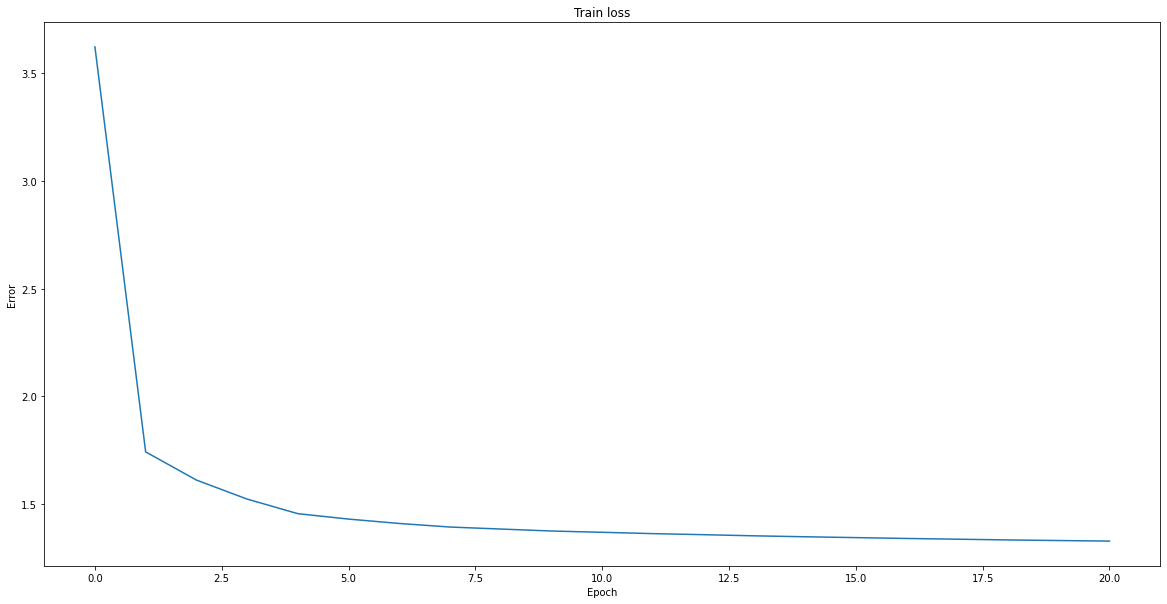

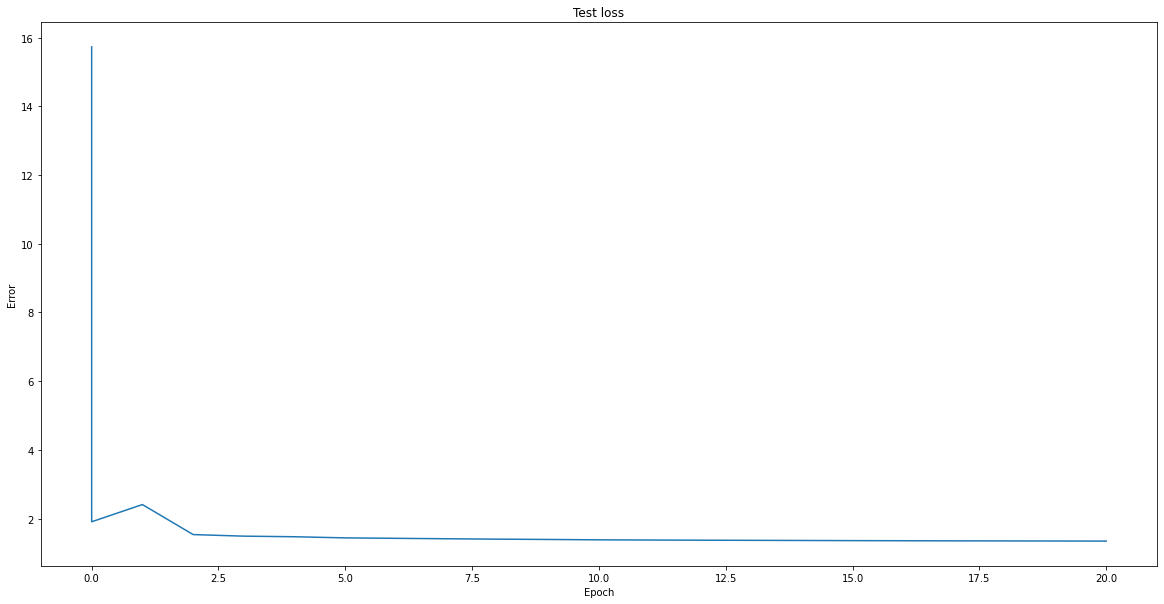

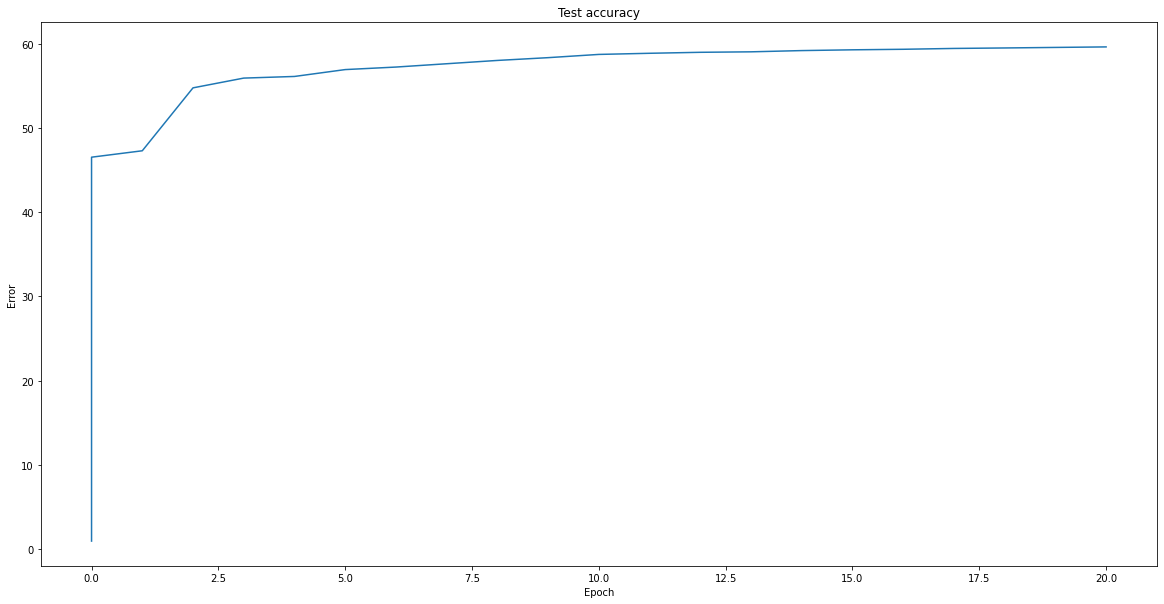

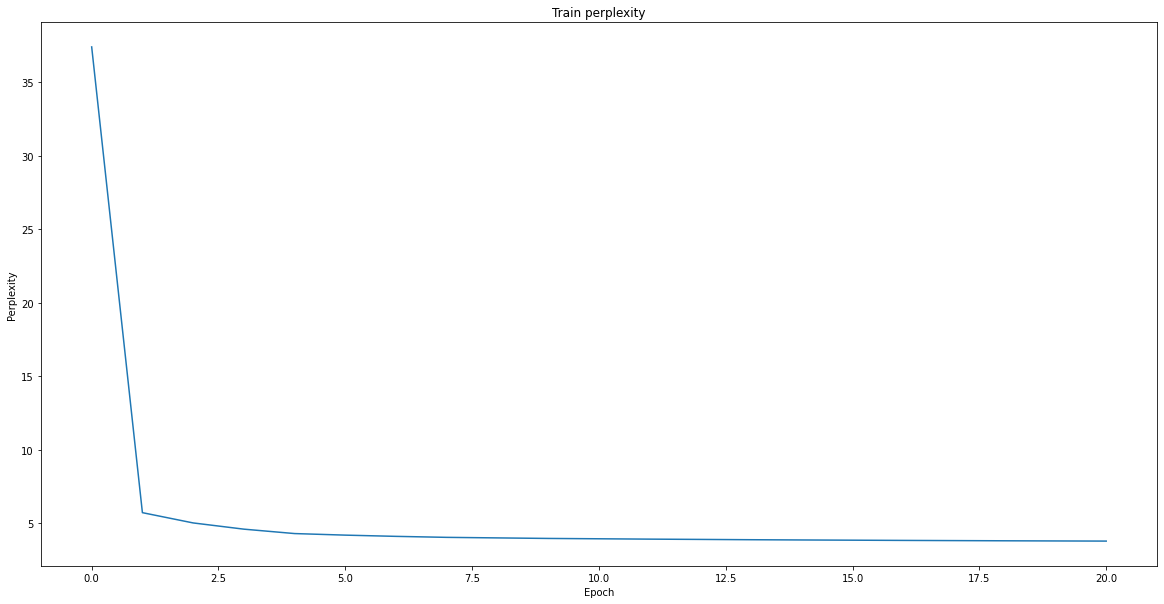

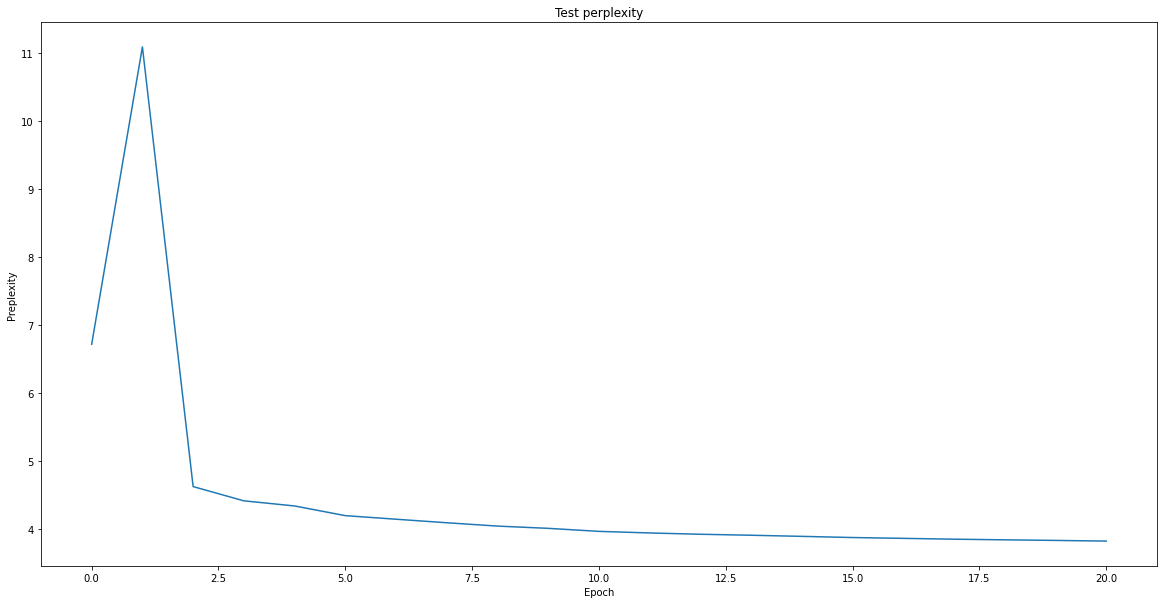

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, np.exp(train_loss)))
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Preplexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the first time the common room was still and said, "I said the moment, I said that the moment what had been sure that the moment was a strange of the castle of the castle and said, "I said the moment, I 
generated with sample	 Harry Potter and the revorple saw Immit surs. Tone was from being days in a race makches of the cary wired endyrate. Jor Vumbledore's extra timeked and ended his gay in their group budging it wandrown from the most wizar
generated with sample	 Harry Potter and the Quictur ready overvend, didn't have taughte them. Aunt D_Ax Durs was here." Ron was a realy too, so that was magical oud wideldow. "Yesh I Yever been doing. Chas as he rememble able this hadle to me 
generated with sample	 Harry Potter and the our of the floor. "Well, I'm for - you and snoke." Professorl some without close on his wand. "Didd has seen thave handed would be crame his forthers. "Sirius is'" M2. ... 's showed you," said Polder
generated with sample	 Harr

#Part 8: 


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
We tried increases the number of GRUs but the model ended up performing worse both in terms of accuracy/loss and speed. In the end, we used a model with with 2 GRUs to reduce training time and improve performance. Learning rate of 0.002 and a temperature of 0.5 was used.

    

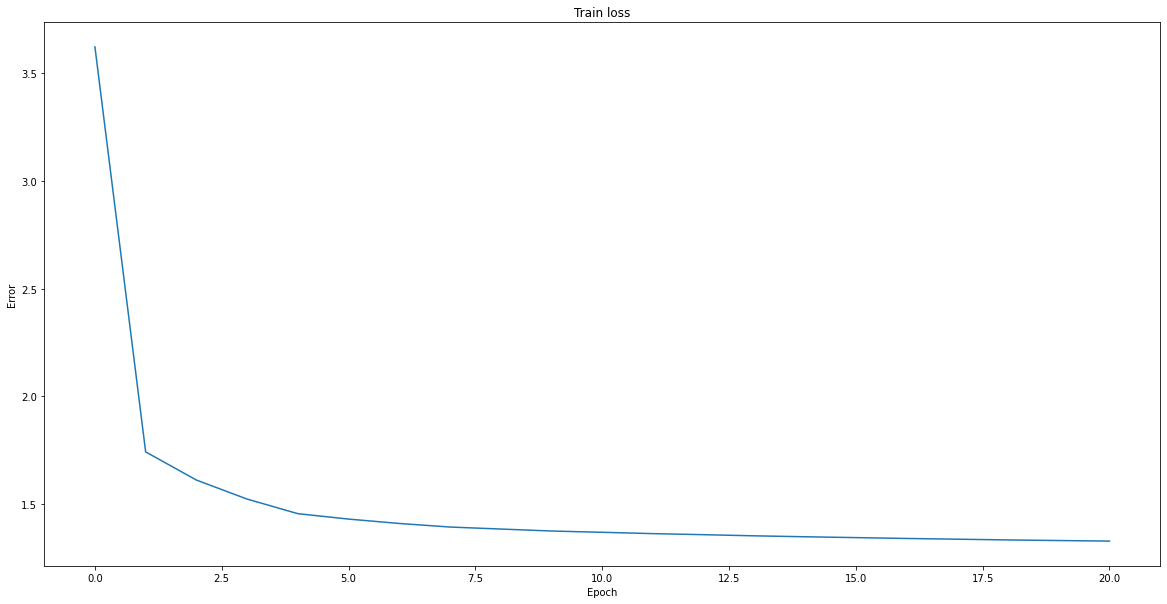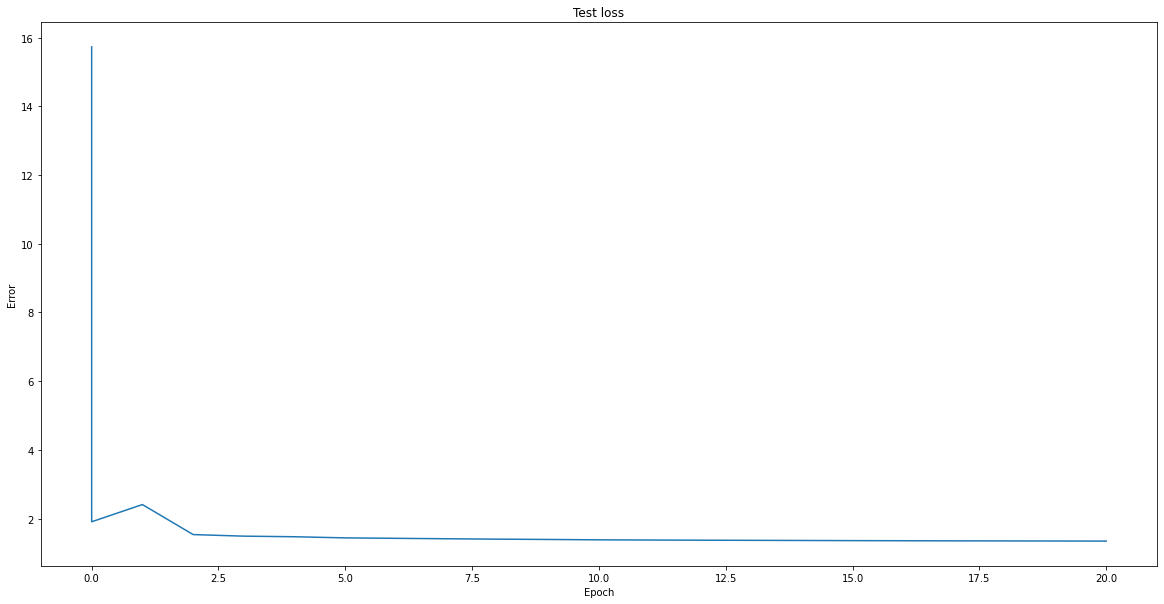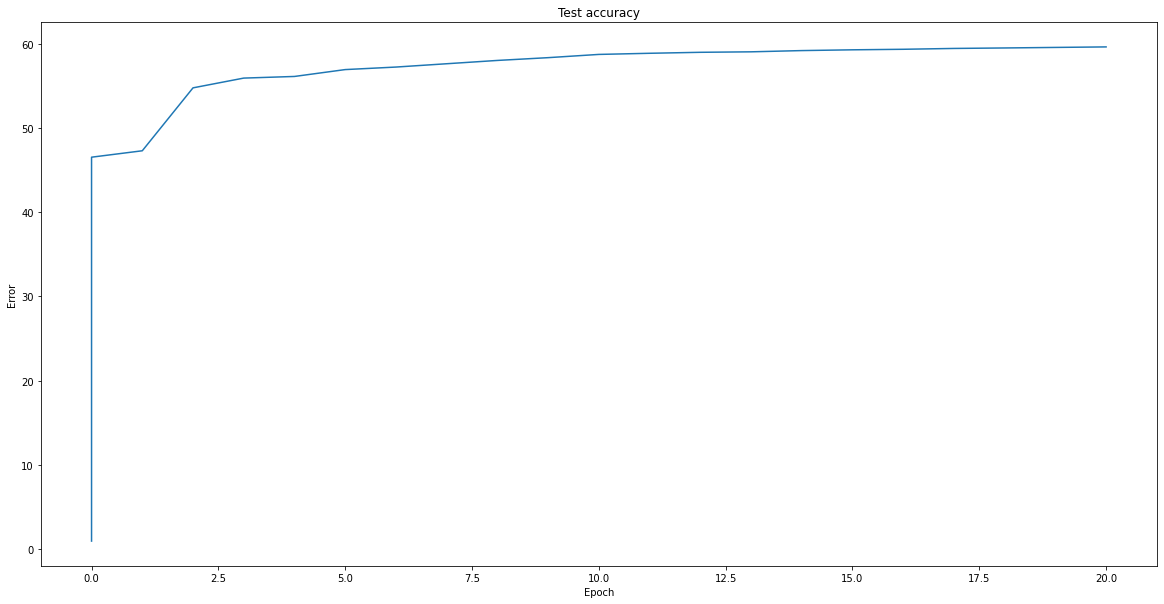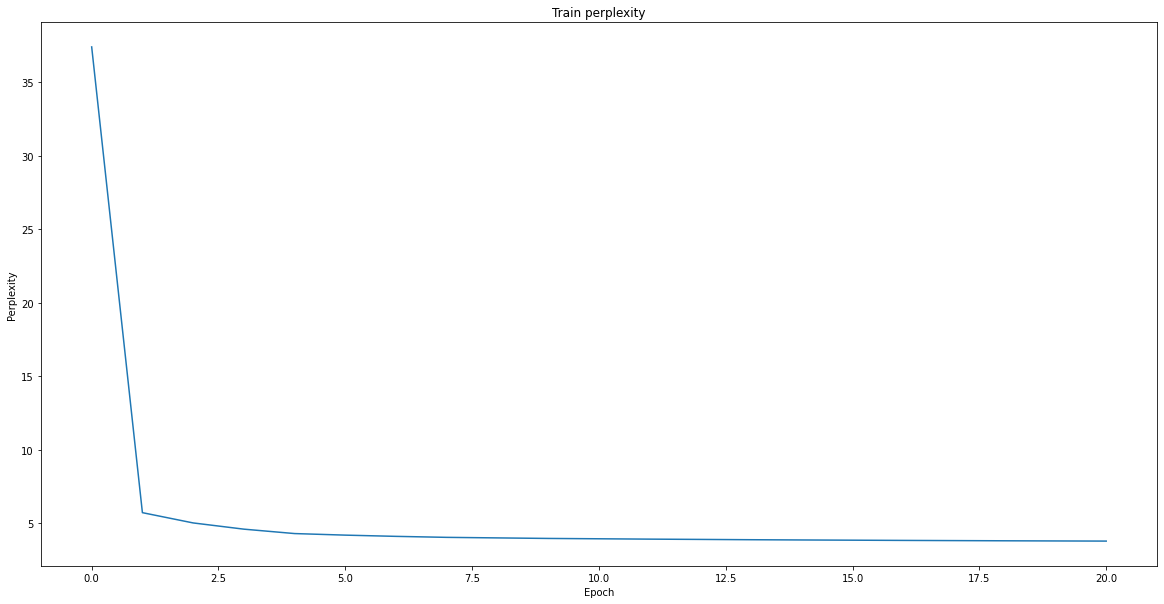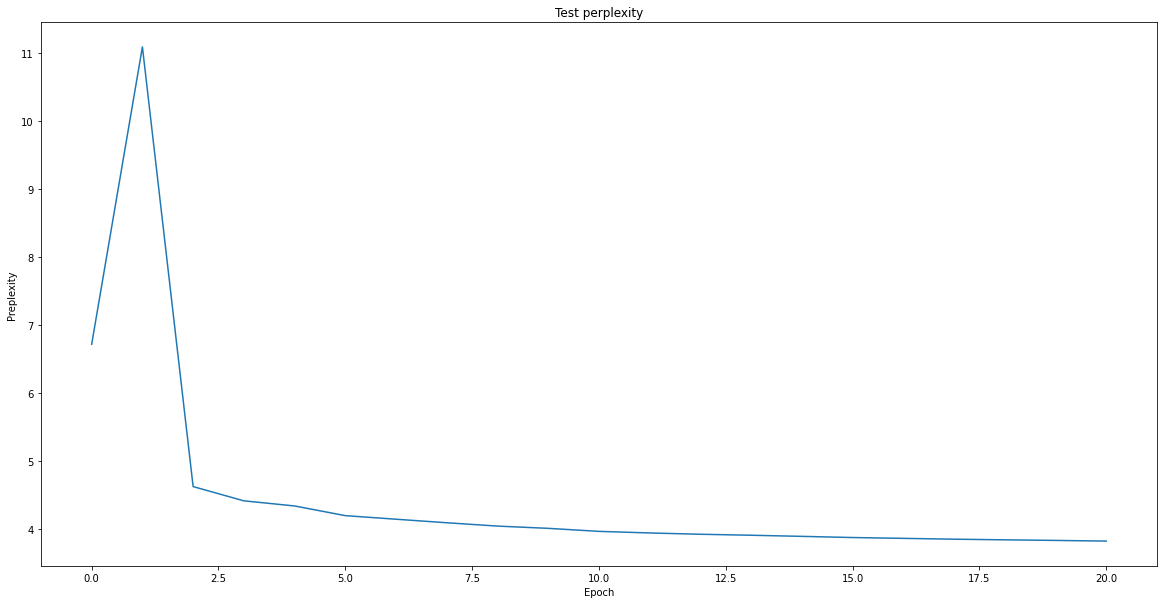

2. What was your final test accuracy? What was your final test perplexity?

Final test accuracy is 60% (748806/1254400). Final perplexity is 3.612.

3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

The prompt was "Harry Potter and the" and the following are sentences from the model.

Max: Harry Potter and the stairs and said the stairs and said, "I was all right, and the other was a lot of the stairs, and the stairs and said the stairs and said, "I was all right, and the other was a lot of the stairs,

Sample: Harry Potter and the just two usual. The spull, and lost isn. "You will s." "Lessor, Ouns?" Serthutted Mornful For about dmistre." The long mady stamfled the dumbote low most backway across the prophes minds slowly when

Beam: Harry Potter and the end of his head and he added to tell them of his hands looked up the air from his arm and looked out of his head not to tell it out for he added in over his robes and said he had been loke at he addd

4. Which sampling method seemed to generate the best results? Why do you think that is?

Beam sampling generated the most reasonble and grammatically correct sentences. This makes sense since beam keeps track of multiple sentences as it explores and appends additional characters and picks the best one in the end.

5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?

    A temperature of around 0.6 ~ 0.8 produced the most reasonable and natural results. Having a temperature of 0 basically makes all the outputs have a similar probability value after softmax because by dividing by a number very close to 0, we are sending the outputs to almost infinity. A temperature greater 0 and less than 1 helps control the spread between each output's probability. As temperature gets closer to 1, we are reducing the constraint and letting the probabilities of the output be spread out randomly. A negative temperature, if allowed in the code, would flip the signs of the probabilities and make lower probabilities take on a higher value. 
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


# Part 9: New Corpus

1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)


In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        data = data.split()
        print(len(data))
        data = ' '.join(data)
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 0
    text = []
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = i
          i += 1
        text.append(voc2ind[char])
    text = np.array(text)


    ind2voc = {val: key for key, val in voc2ind.items()}

    index = int(len(text) * 0.8)
    train_text = text[:index]
    test_text = text[index:] 

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'aot_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'aot_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'aot_script.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

37459


In [ ]:
import math
class AOTDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(AOTDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
            dataset = dataset['tokens']
            dataset = dataset[:self.batch_size * (len(dataset) // self.batch_size)]

        self.data = []
        self.leftover_bits = []
        num_batches = math.ceil((len(dataset) - self.batch_size) / (self.batch_size * self.sequence_length))
        for i in range(num_batches):
          temp_data = []
          for j in range(self.batch_size):
            chunk_start = j * len(dataset) // self.batch_size + i * self.sequence_length
            if i * self.sequence_length + self.sequence_length > (len(dataset) // self.batch_size - 1):
              num_left = (len(dataset) // self.batch_size - 1) - i * self.sequence_length
              temp_data.append(dataset[chunk_start:chunk_start + num_left])
              self.leftover_bits.append(dataset[chunk_start + num_left])
            else:
              temp_data.append(dataset[chunk_start: chunk_start + self.sequence_length])

          self.data.append(temp_data)


    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
         return len(self.data) * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        i = idx // self.batch_size
        j = idx % self.batch_size
        data = self.data[i][j].tolist()
        labels = data[1:]
        labels = labels + [(self.data[i + 1][j][0] if i + 1 < len(self.data) else self.leftover_bits[j])]
        return torch.LongTensor(data), torch.LongTensor(labels)

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
TEMPERATURE = 0.5

class AOTNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(AOTNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	üygK2pg2''nK KZrgnnRygpKpB2,K21(RB'ycg?nBB2.prKRg311KKK2gmDDgn4BzU22h3Hhu11pgg,3rDr8882.pDDD(ug3pxx



Test set: Average loss: 15.5470, Accuracy: 431/51200 (1%)



 43%|████▎     | 3/7 [00:00<00:00,  5.36it/s]

Train Epoch: 0 [0/1792 (0%)]	Loss: 15.608687


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	gg,.rnbhO!n. TuryIunngIoun.dfubu n!gg Ihn!,iTnygnd! Imuuuhe rhh..  Theg pT pn!Tuu  g   TTnc bT!hetk0



Test set: Average loss: 14.7068, Accuracy: 9609/51200 (19%)

Saved /content/checkpoints/000.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. The The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre The ru, upre T
generated sample	 Eren, Mikasa, and Armin walk into a bar. The The ru, uI't! I'tWM. The The TOupp0ghte b! The rThe ru, I'tWM. The The ruu! I'tWM. The rThe ruI ppve ery I't! I'tW? I'tWM. ppe The rT! I't! I'tWM. The The ru! I'tWM. The be ru, upcke pre The The r
generated sample	 Eren, Mikasa, and Armin walk into a bar. I'tWx6c

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. The The rThe ru! I'tWM. The The The ru! I'tWM. The The rThe The rThe ru! I'tWM. The The ru! I'tWM. The The The ru! I'tWM. The The The ru! I'tWM. The The The ru, pe The r! I'tWM. The The The ru! I'tWM.



 43%|████▎     | 3/7 [00:00<00:00,  5.88it/s]

Train Epoch: 1 [0/1792 (0%)]	Loss: 14.677823


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ng swnbhnZns ffr nanngaornddf tetllkg thneePaiinnnntan  Bhi nhlled Hhin2antanltuo,'    IakiCmnZfin  



Test set: Average loss: 8.6172, Accuracy: 10806/51200 (21%)

Saved /content/checkpoints/001.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. I ne't salety making ing tincDor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor nor
generated sample	 Eren, Mikasa, and Armin walk into a bar. ?! Hengt of thinCCArn, anly oou hing firent's266cqus, anly the making tiZAm ing thinCt sament's266c—hgh falley hegur faing tiZAm anot seppt's2ement's2incDor nogut sanley waak man't just hing firent's2
generated sample	 Eren, Mikasa, and Armin walk into a bar. I d'll 

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. I ne't salety making ing tincDor anly our nor nor anly our anly our anly our anly our nor anly our anly our anly our anly our anly our anly our anly our nor anly our nor anly our nor nor nor nor faing



 14%|█▍        | 1/7 [00:00<00:01,  5.10it/s]

Train Epoch: 2 [0/1792 (0%)]	Loss: 8.617460


100%|██████████| 7/7 [00:00<00:00,  9.90it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi wmwitand yfr finngdeumymf oevvlng uellymaciknws tf ooherootoo  Whes ss smddfeeaa?  Yimi ttefen e



Test set: Average loss: 5.4761, Accuracy: 13002/51200 (25%)

Saved /content/checkpoints/002.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. mully and way enennPy herererperopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herererpopeninge herere
generated sample	 Eren, Mikasa, and Armin walk into a bar. minge heren of thererpero. heve. fArming! This %AnHy! FromretaterimennjRe mourdy! Anded aof of therer.. What ming handd?! Anbrice! Erenin?! Thereld?! Anbed if uennguaming! The Titand you mand you?! Ye
generated sample	 Eren, Mikasa, and Armin walk into a bar. mully a

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Weall you ally and of therere.? What ther to of there. Well hourd..... You ally and of of orer..... Your your..... Youre your of there olly and forere.? What there. Well aAnd youre your of therer.?! Y



 14%|█▍        | 1/7 [00:00<00:01,  5.17it/s]

Train Epoch: 3 [0/1792 (0%)]	Loss: 5.334094


100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi i witass ywr iakngtousllf ioe lvg ohll tayyvkln tn aihe mh oo  Shos af f  dwc  s   Iyyi yn yuvti



Test set: Average loss: 3.9755, Accuracy: 14331/51200 (28%)

Saved /content/checkpoints/003.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. Ift...! Da mill thats thatted this will the will thumption, in to own! What have in our done in to ourd in to own! What have in our done in to ourd in to own! What have in our done in to ourd in to ow
generated sample	 Eren, Mikasa, and Armin walk into a bar. Those of lig human! Ifa useelfte me firghtMik a low Make. If....! Di? Yourd one in to in ow reash! Acsurd lig thurd dlies thanside the dide a in to we enenuted thing ow renersthen't I dea now be esme 
generated sample	 Eren, Mikasa, and Armin walk into a bar. ThoosC"

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Why's the emed this a dide in to one in to ourd int o we in or in to ok int ok in ow now orck anottell will thumption usolive your one in ou have in ourd in own the emes hupide in own the emed this hu



 14%|█▍        | 1/7 [00:00<00:01,  5.17it/s]

Train Epoch: 4 [0/1792 (0%)]	Loss: 3.871472


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi irsitan' snt iann.fonndmn iiedlfg.feil cicianbn nn  yhi ahwaod Rhes ts inddpps,s . Wyyi yt manpp



Test set: Average loss: 3.0575, Accuracy: 14975/51200 (29%)

Saved /content/checkpoints/004.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. That's be gout abaked you... Arminin.. Arminink itp! It's whey gone decitin. What all commaning think is top! It's whey gone decitin. What all commaning think is top! It's whey gone decitin. What all 
generated sample	 Eren, Mikasa, and Armin walk into a bar. Wain... Wei? I HPilisilika! I'll ScocarTitan! It's with! Jaead! It's whey... Armining some andy to stare your acking to staany bout ken... Arming to thant's to kin. Corann't all kein. What dodit?! Dor
generated sample	 Eren, Mikasa, and Armin walk into a bar. Gost an

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. und plaed you... Any will you will comentinn't be fromet?! I'll Mikaake you... Any will comet?! I'll commning in.. Arim! It's whe guaded yout in.. Eren.. Arin nopppposs! I'll comet han ffimet hands po



 43%|████▎     | 3/7 [00:00<00:00,  5.84it/s]

Train Epoch: 5 [0/1792 (0%)]	Loss: 3.011416


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi yrcrtan  wnt danngtatv mn taar rg iail tarrggbntdu  yhe shwoo  Tiesegs ig'dfp p    Iasi pt tuvpe



Test set: Average loss: 2.6099, Accuracy: 16224/51200 (32%)

Saved /content/checkpoints/005.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. He's on dan't than that is dise as shis gure some somer thas will died died with that bas quive bee help wery long in to the Titan whing will dized many faing in to the be to meat that will dized many
generated sample	 Eren, Mikasa, and Armin walk into a bar. Tou had neave heall rea's on in deand : rigant be likep thatim where died in bet weremine diked it we dant to is. It as say wit your dies wills onk your your you! Mrivea! The Titanstaing... Any we cou
generated sample	 Eren, Mikasa, and Armin walk into a bar. That fo

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Titan will have have one Titans.. He's not a kills haged it ont here Titans.. He'll ep und epecier wil don't eall now it me out of neeed to take out of hred to int of here Titas have her is's age... H



 43%|████▎     | 3/7 [00:00<00:00,  5.93it/s]

Train Epoch: 6 [0/1792 (0%)]	Loss: 2.547939


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	n i tlcitan  snt hannttanv on oeer rg teil barrklbt nn  yhe whlle  Thes ts tndbn  r  . Tise pt'tuppe



Test set: Average loss: 2.3031, Accuracy: 17695/51200 (35%)

Saved /content/checkpoints/006.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. We con the Colloss-bled to defull and bele bely one we gat a me me me to the Titan beir you the wall and bele bely one we gat a me me me to the Titan beir you the wall and bele bely one we gat a me me
generated sample	 Eren, Mikasa, and Armin walk into a bar. The becolduntly now recauddlevoine difefther we'd becut tlake pure do time... The bascomet for hely hearr?! The sealry! Wo thene yearTiotan base time tullack whed the ction agang to in to tise gar an 
generated sample	 Eren, Mikasa, and Armin walk into a bar. We cold

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Ere... The's son no him the Titans on on no him the Titan as really on on on on nothing no evereally on on on on nothing no everer ally on on ever ally on on on here it's song on on onn on him the hel



 14%|█▍        | 1/7 [00:00<00:01,  5.10it/s]

Train Epoch: 7 [0/1792 (0%)]	Loss: 2.242918


100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	nge tcsitans sur sanndtonddeu tuev ng teil uarralbt ou  yhe bhroe  Thes ts onddn  rs . Wise ttstespe



Test set: Average loss: 2.1845, Accuracy: 17775/51200 (35%)

Saved /content/checkpoints/007.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. How as she you're somenter the seemsed the Titans to seent sume supprobjin the Comesself the the Titans to seent the becks of the Titans to seent the becks of the Titans the seent the becks of the Tit
generated sample	 Eren, Mikasa, and Armin walk into a bar. How abouts. The Titan we ha! Whys feelly, humaniors shouts! I no nety ack abour lough ent leaknuy wasted! Hey, sur we's deelf such you rous! You're nor the he dis, she conr human! Alm us likep torcta
generated sample	 Eren, Mikasa, and Armin walk into a bar. How, yo

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. I need on the onett... The no use ous ever outst of the one the Titan... We'll be eting hered on the etseed the Titans on her's soe on hed the itts weed the enter you set sen ever othe Titans on hed t



 29%|██▊       | 2/7 [00:00<00:00,  5.64it/s]

Train Epoch: 8 [0/1792 (0%)]	Loss: 2.114065


100%|██████████| 7/7 [00:00<00:00,  9.47it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngh clcitan  wur lydn.yu dllf ullrllg hhll riryklln nu iyhe hhrll  Thas nn nr du ir  . Iirn pnhhuvpr



Test set: Average loss: 3.1664, Accuracy: 15012/51200 (29%)

generated max		 Eren, Mikasa, and Armin walk into a bar. Huh? I can't humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humaning hurrying humanin
generated sample	 Eren, Mikasa, and Armin walk into a bar. Id will dickay! I did will no nim! Hur! Hu?! HU-H! Whavery fing hu're gy, Jus.... Annd think thin! Even thapr! CFlll righth. You whan like humankiny... How Burivi?! I humad know will righthZW'll give
generated sample	 Eren, Mikasa, and Armin walk into a bar. I hadver hu.... Sinury, curring humr! Thav

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Id... I did up und humar ill if you... A humadn't humn... I can't humaright und huad livill you all in up you huad livill you wall right und humn... Whary livill you now... I didn't und it ud yurying 



 14%|█▍        | 1/7 [00:00<00:01,  5.15it/s]

Train Epoch: 9 [0/1792 (0%)]	Loss: 3.123443


100%|██████████| 7/7 [00:00<00:00,  9.95it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	nee cssitans wf  iann.yenvdof iicv veeoeil barianbn of iiee sonie  Ihaa in isywfcica . Iiri it oavpe



Test set: Average loss: 2.8082, Accuracy: 15658/51200 (31%)

generated max		 Eren, Mikasa, and Armin walk into a bar. He's such as sucessione we'll be based of ineces of of itur comanine-ite was singe of of commanine-ity was sucessione we'll be based of ineces of of itur comanine-ite was singe of of commanine-ity was
generated sample	 Eren, Mikasa, and Armin walk into a bar. Howe! I lon-ce! Ase log! No! No! No! No! Now! Iway! Asll Titan! He buse! I goave ooldier solicice, ine wase was ive, Coman?! Aneseers lodinfied. I'll rik coman in of it morior it...! Let's Buck for of
generated sample	 Eren, Mikasa, and Armin walk into a bar. I was in' Maban. That's joing of of manice

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. I.... I smain... Doy one... I'll do it of one... No... Is... I'll doine... Is of ine... I'll one of of as us now... I'm on you inee... I see... I'll one wes of of unesine... I sece of fice ine of coma



 14%|█▍        | 1/7 [00:00<00:01,  5.11it/s]

Train Epoch: 10 [0/1792 (0%)]	Loss: 2.735144


100%|██████████| 7/7 [00:00<00:00,  9.90it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	t i l sitans sur sanl yonv oo oerv vg iiil saroalbt on  iha ahroe  Thaa ws i  ino rs . Iarasat tavpe



Test set: Average loss: 2.4669, Accuracy: 17106/51200 (33%)

generated max		 Eren, Mikasa, and Armin walk into a bar. I'm sold it was was conly serivivitay, as sig it was was conly serivivitaill you seriviouse of that a Titan if it was was cold sirry of that a Titan if it was was cold serivivitay in you seriviouse of
generated sample	 Eren, Mikasa, and Armin walk into a bar. Mobe one rous wall nolowe cover commale sold itry of worromarold givive it was was one. Sone sirviviou incier sibou that aai. poosesss, sigush all sold sill you sers ook, do it that? I dommany posssir
generated sample	 Eren, Mikasa, and Armin walk into a bar. Eren no lasir! Even youse of lefusers will

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Mlas coomman it that a reall over that all over it taill one one one only essir of that a wall on ones only one one one a it was on one one in Jaes ones one one ha posess right all over of that esir o



 14%|█▍        | 1/7 [00:00<00:01,  5.13it/s]

Train Epoch: 11 [0/1792 (0%)]	Loss: 2.384109


100%|██████████| 7/7 [00:00<00:00,  9.81it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	dgi c citans yvr sann.fanv mo heellfg mail Maroklbn in  yhe shrie  Thes is i dcu  rs . Tiri in metpe



Test set: Average loss: 2.1805, Accuracy: 18354/51200 (36%)

Saved /content/checkpoints/011.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. How mas ene, you seen vargaction command command command command command command command command command command command command command command command command command command command command command
generated sample	 Eren, Mikasa, and Armin walk into a bar. How mate foges therese I see bron now... There seen mase if in commally right loose see veratto. The mailly gove senerd a momhere.... The enereGrquse the seenseed ther the see Commaten back. Yous expl
generated sample	 Eren, Mikasa, and Armin walk into a bar. The bef

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Eren I seen ever neemene. Coman hrod over all have you seen ever all rogh other Titan foom comal ove her ened over have have a maly lose ver all ove have her ened over have eneed you see enever attack



 29%|██▊       | 2/7 [00:00<00:00,  5.40it/s]

Train Epoch: 12 [0/1792 (0%)]	Loss: 2.084243


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi pssitan  sur sann.datddon ooerltg tall tarrnlbn ou  ohe shroe  Thes is o ddu sss . Tars in iaspe



Test set: Average loss: 1.9855, Accuracy: 18912/51200 (37%)

Saved /content/checkpoints/012.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. How do in the still took our on the see outs of our this our operst of the see the strough the see world and dead. How do in the still took our on the see outs of our this our operst of the see the st
generated sample	 Eren, Mikasa, and Armin walk into a bar. Erwas, nonrm and the what. You'r evengly, your misteven whork outsill Titans onying the scre till, that is the! I'm gon took! Wage enever yourse, rear? He hase sucrmamande! Was clowe sor roub proost, 
generated sample	 Eren, Mikasa, and Armin walk into a bar. How cou

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Stake till on to it out int out too or use out our took or us our it out of it out till took okn out till took or Han... all rely loot till oting to us to us our tood on on on the Titan a see outs of 



 14%|█▍        | 1/7 [00:00<00:01,  5.06it/s]

Train Epoch: 13 [0/1792 (0%)]	Loss: 1.896204


100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngiranTitan. wnr sann.ainvdef aoer tg aail Maraalbt on ,yhe shkie  Ihas is ildmn ers . Iire it iaspe



Test set: Average loss: 1.8827, Accuracy: 19577/51200 (38%)

Saved /content/checkpoints/013.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. Hand the Colosse all Titan... That dis what and the Colose all Titan... That dis what and the Colose all Titan... That dis what and the Colose all Titan... That dis what and the Colose all Titan... Th
generated sample	 Eren, Mikasa, and Armin walk into a bar. Hangain's enouthing Titan as idinionce! Armin... Gorver! That's what deadem will... Hqure! Idvonme offquese... They Tians't me iftes... No mime, waill... Humannight necterivous Alreathing... Stect up 
generated sample	 Eren, Mikasa, and Armin walk into a bar. It too 

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Huh? Yes... Thats way that is... It's happend all are of all have you appartan... Hey, yourse large again... That's happen... I didn't you again... The ad it all... it... It'll abut had and happen... 



 43%|████▎     | 3/7 [00:00<00:00,  5.91it/s]

Train Epoch: 14 [0/1792 (0%)]	Loss: 1.783684


100%|██████████| 7/7 [00:00<00:00,  9.82it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tgi t Titan  tft tenndtetddtf tter tg teil Marialbt tv ithe thkle  Thes it ildyu ers . Iare tt tuvpe



Test set: Average loss: 1.8986, Accuracy: 19762/51200 (39%)

Saved /content/checkpoints/014.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. It's the cartuard the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans the the Titans th
generated sample	 Eren, Mikasa, and Armin walk into a bar. I this that it, they're the gat fight! They Titan. Foll uek. It we call again tobitios litill. to... They's nimettectually? Oh... We caret it lity glet is tituble the etever you not! It twe fould is t
generated sample	 Eren, Mikasa, and Armin walk into a bar. Mofint.

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. He'll on it tell it time tell it tell ettile ter itte the it's it... it tell attime the it us timette it tell it tell the it it the it out timet tell it tell of here the Titans the the its time him th



 14%|█▍        | 1/7 [00:00<00:01,  5.18it/s]

Train Epoch: 15 [0/1792 (0%)]	Loss: 1.798402


100%|██████████| 7/7 [00:00<00:00,  9.68it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tgi i Titans ipr ionn ieiv if iolrlvg ieil iiriaris iv iihe Torie  Ties is ir iu iri . Iiri it ievpe



Test set: Average loss: 2.1695, Accuracy: 17889/51200 (35%)

generated max		 Eren, Mikasa, and Armin walk into a bar. How is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is i
generated sample	 Eren, Mikasa, and Armin walk into a bar. How if I will your is... Poldier. Tit's air. Rision't like inficed in Titazsize, in is of is it solly, right! Beage! Now if, you?! In dissionly is is in. You in a myse? I'm be ground iskill, timention
generated sample	 Eren, Mikasa, and Armin walk into a bar. Pysiskings opliicizy, it's backsion, well 

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Will it is is is is is is our is is is is is is soldier is is is is is solice is is is is is its is is is is is is is is or all... is is is is is is is is is is is is is is soliiely is is is is is is 



 14%|█▍        | 1/7 [00:00<00:01,  5.16it/s]

Train Epoch: 16 [0/1792 (0%)]	Loss: 2.065328


100%|██████████| 7/7 [00:00<00:00, 10.01it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tgo h sitan  snt senn.toiv on hoer eg oeil Maria,bt tn iyhe shkie .Ihas ts t dyn ers . Iori yt!savpe



Test set: Average loss: 2.2604, Accuracy: 18412/51200 (36%)

generated max		 Eren, Mikasa, and Armin walk into a bar. Howe don't have a situte stop that a situte situty going on on on to kinking... I can situte stop that a situte situty on to situte stop that a situte situty on to situte stop that a situte situty goi
generated sample	 Eren, Mikasa, and Armin walk into a bar. Howe dumbstle, Anike has for move nougher aso strio, Oncover has tobjoing to situch about proverioust on sives joining to scrive yourse. E... You're ond, Just unyonie goninin... You're sover ocke rond
generated sample	 Eren, Mikasa, and Armin walk into a bar. Holades, on join? Huh? You've doest had so

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. So me... Eren... Eren... Eren... Don't happend over one on happeroe of have a poining on on onnin of happenie or Hannining on on on onining... I all acce for have a enough a stilled, Eren... Eren... I



 29%|██▊       | 2/7 [00:00<00:00,  5.61it/s]

Train Epoch: 17 [0/1792 (0%)]	Loss: 2.137566


100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tge t sitans snt ienndie dden ttrrltg tail Marikrdt nn ,the shrse  Ihes is irddn er  . Iari ttstavpe



Test set: Average loss: 2.0392, Accuracy: 18938/51200 (37%)

generated max		 Eren, Mikasa, and Armin walk into a bar. It's no the can string the can string the can string the can string the can string the can string the can string the can string the can string the can string the can string the can string the can stri
generated sample	 Eren, Mikasa, and Armin walk into a bar. It's know bever candes then dechade cuted! In't no dee! I stry thats the hearst not smeen?! I-I wanter the Titans... As creprising, ther are tarak it.... Goder have very get, the gas we cenderwith str
generated sample	 Eren, Mikasa, and Armin walk into a bar. I ded have the ne were cenarin, you're rec

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. All right... All rike the haded... I ever... I take haded... I deaded... All right... I'll evenger the tering the stright... I have happen is stille teright... I dead... I'm srike hade happerie have a



 29%|██▊       | 2/7 [00:00<00:00,  5.59it/s]

Train Epoch: 18 [0/1792 (0%)]	Loss: 1.930059


100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tg  t Titan  wnr nann'yend on thal tg teil tarialwn tn ,ahe Rhkie  Thes is t yyu er  . Diri it tuvpe



Test set: Average loss: 1.9067, Accuracy: 19697/51200 (38%)

generated max		 Eren, Mikasa, and Armin walk into a bar. Howe day, your humaning the the Titans the Commander it the hear Titans and head the hear nother Titans and head the hear Titans and head the hear Titans and head the hear Titans and head the hear Tit
generated sample	 Eren, Mikasa, and Armin walk into a bar. Hwe cally moments thanges! Goood Erenly excceeds a Titan ince, yet! Just im! That we he've lough to the fall should have We based and a Titan many corsectury on the Comman't beack... But your don't ge
generated sample	 Eren, Mikasa, and Armin walk into a bar. I don't ving? Majo, you hunch onck our can

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. Rig... I'll have not tell humanind had that happen... You're all humaniy had a han on happeried other ito the int is... That's happened the here in the is the othe hell have te hell have helle the hel



 14%|█▍        | 1/7 [00:00<00:01,  5.05it/s]

Train Epoch: 19 [0/1792 (0%)]	Loss: 1.786255


100%|██████████| 7/7 [00:00<00:00,  9.69it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	ngi t sitans tft denn'te ddmf therltg tail Marialbn nn  ahe Thkie  Ihes is i ymu ers . Iire it tavpe



Test set: Average loss: 1.8108, Accuracy: 20232/51200 (40%)

Saved /content/checkpoints/019.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. How do you don't know the walls are are all right in the walls are are all right in the walls are are all right in the walls are are all right in the walls are are all right in the walls are are all r
generated sample	 Eren, Mikasa, and Armin walk into a bar. Hand it would nother words comething? What defes no much I nigns?! No The ke it two bhid it? I just me's no have trace prienced... Rein? Captain, Eren in her same hery sterating, buit the Titans chere
generated sample	 Eren, Mikasa, and Armin walk into a bar. Jaen's 

  0%|          | 0/7 [00:00<?, ?it/s]

generated beam		 Eren, Mikasa, and Armin walk into a bar. of her it all right... She's no a acce... He of the is time its right for it... am really are live in her it its all righting... I'm not see the right... He all it he ar it... The is time in the it's 



 14%|█▍        | 1/7 [00:00<00:01,  5.06it/s]

Train Epoch: 20 [0/1792 (0%)]	Loss: 1.681911


100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


Input	into a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happ
GT	nto a Titan, our main goal of sealing Wall Maria is off the table. This is an order... Make it happe
pred	tgi t Titans wnt tann.aetddmf ther eg teil Maria,bt tu eahe wokse  Thas is i  cu ers . Dare tt tavpe



Test set: Average loss: 1.7640, Accuracy: 20396/51200 (40%)

Saved /content/checkpoints/020.pt

generated max		 Eren, Mikasa, and Armin walk into a bar. I don't know the words to do it our tood of the Titans and to do it! We can't to go on our our of the are you don't with the words and deady would to do won't go on our tood of the a Titans and to do 
generated sample	 Eren, Mikasa, and Armin walk into a bar. May kep up that mea-le! You're und get to dear happarent to de can out of have to seer it, mon to to esterten! Reconverryone, but und meat! Bee pacefesen bodes corse use what too, Eren. We black, but 
generated sample	 Eren, Mikasa, and Armin walk into a bar. You do 

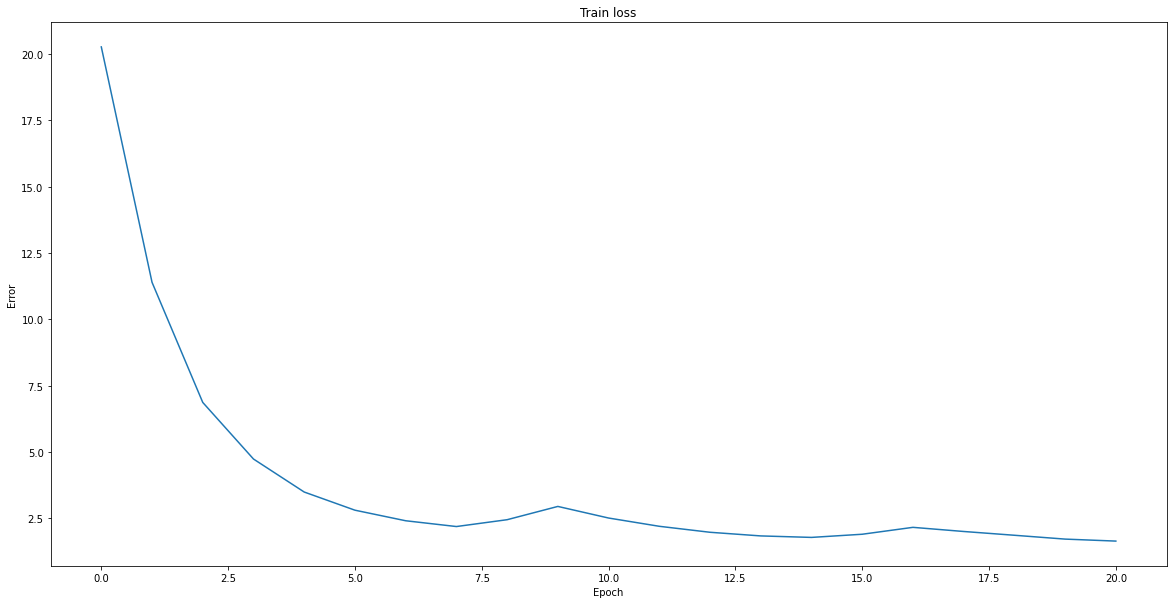

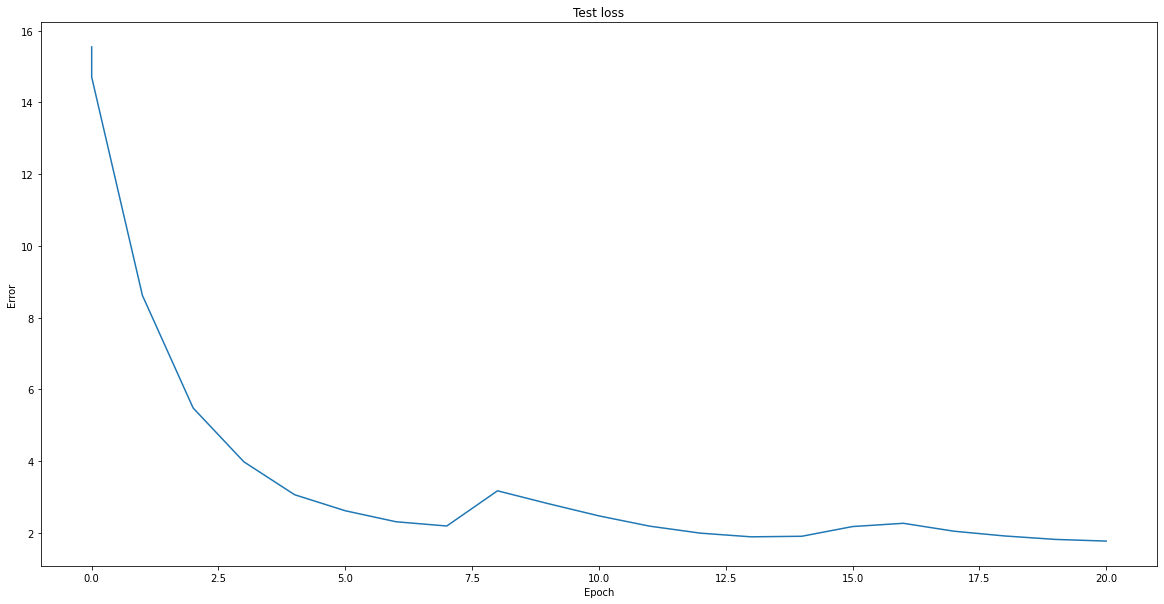

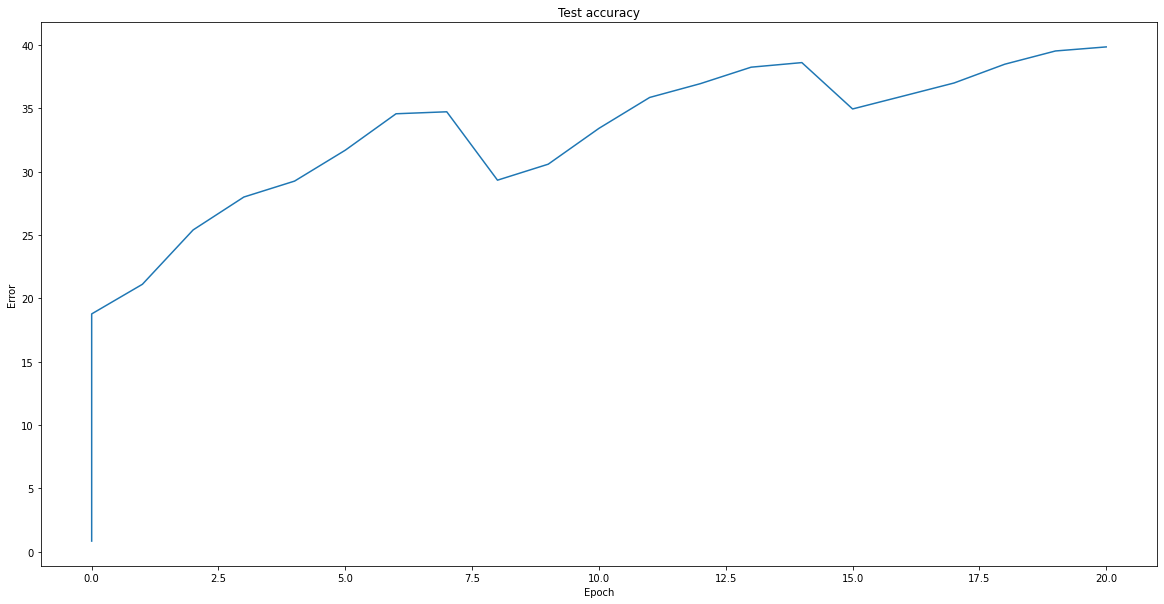

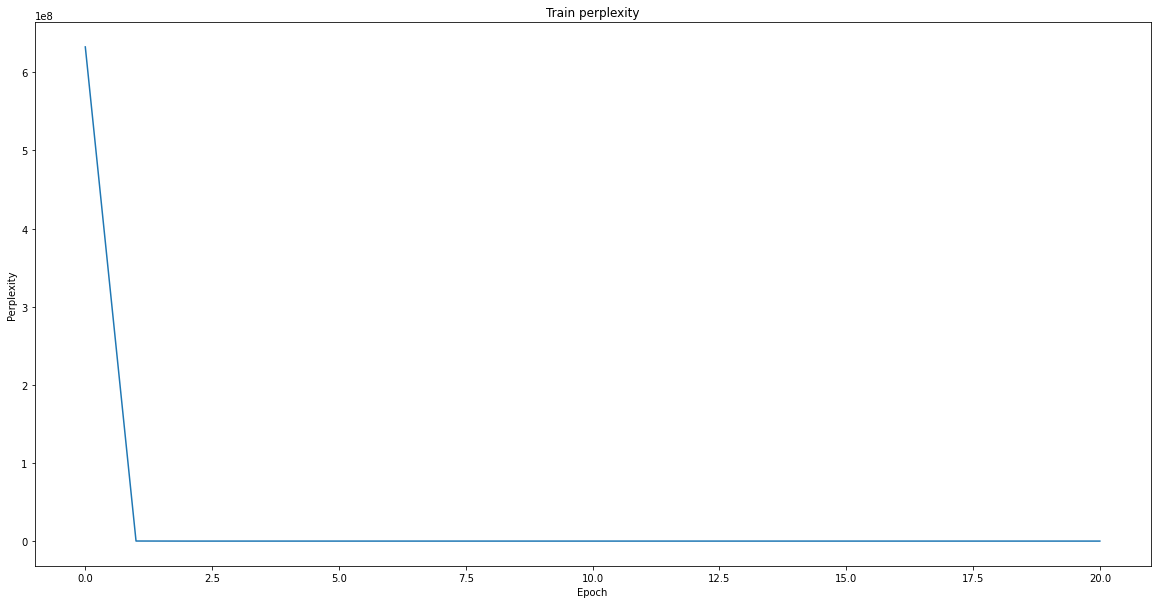

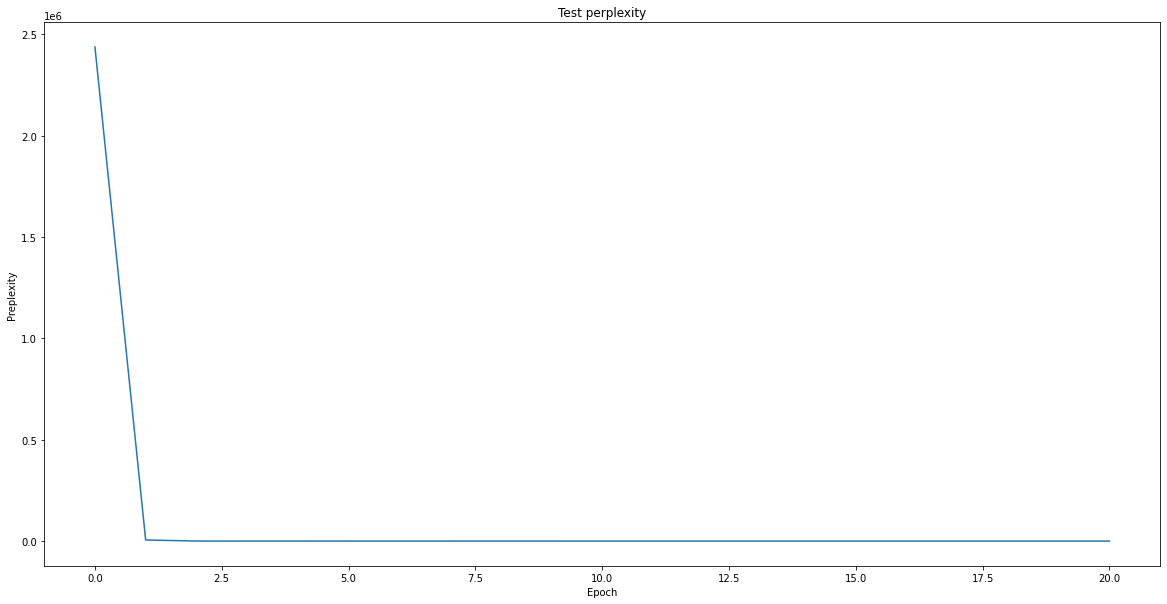

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = AOTDataset(DATA_PATH + 'aot_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = AOTDataset(DATA_PATH + 'aot_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = AOTNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, np.exp(train_loss)))
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Eren, Mikasa, and Armin walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Preplexity')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        data = data.split()
        print(len(data))
        print(len(''.join(data)))
        data = ' '.join(data)

 
prepare_data(DATA_PATH + 'aot_script.txt')

37459
170099


In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Eren and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Eren and the Commander of the a Titans and to do it! We can't to go on our our of the are you don't with the words and deady would to do won't go on our tood of the a Titans and to do it! We can't to go on our ou
generated with sample	 Eren and the defore thins? It's bening. I just still -kirs in, the recerup! We've the come happensed it belme and you've fited will have you? Ereen based weay. That It is wor its teake... Fare hisment ise if its 
generated with sample	 Eren and their deas sto perised. I have a do iten. Wear down, Squad do takee? Marcod. Is have yeard as. I'm have te mear of the captuar-lain. That it? Dise preas to accesseers, Eren's with not ime.... Now it's to
generated with sample	 Eren and the seelt, Caitary sered of the Titans fome cal toold ord the it would can't their your acception seens are Squad, it's did... Whatic! Hany cou'll cacess! Hurry, tooday, with tood romal? We can't be hand
generated with sample	 Eren and the en you can't back! Armi

1. New Corpus
    1. What corpus did you choose? How many characters were in it? 
    
    We scraped the web and collected dialogues from our favorite anime Attack on Titan. We were able to collect dialogues from season 1 which only contains 170099 characters.

    2. What differences did you notice between the sentences generated with the new/vs old corpus.

    Our new corpus did not contain a lot of data compared to the old corpus. So the model often at times generates incomplete sentences. However, the generated sentences match the mood and style of the anime's dialogues.

    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    Used a temperature of 0.5 and the outputs are as follows.
    
    Max: Eren and the Commander of the a Titans and to do it! We can't to go on our our of the are you don't with the words and deady would to do won't go on our tood of the a Titans and to do it!

    Sample: Eren and the en you can't back! Armin.... The Scour us what tood tod the Trost of there to courretshing uFiess as mean't lain dol... That do you wo. But wint metop it! Eren informaorrd. Say swill Eren... Eren!
    
    Beam: Eren and the Titans to all have tood to have on happend of the need other it out of the eent you really right othe rell arey one of here... I'm see... Eren...

# Part 9: Train model on words
Train a model on words instead of characters.
You will need to redefine your input/output space vocabulary as well.
You should replace any words that occur less than 5 times in the dataset with an <unknown\> token.


In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        data = data.split()
    
    voc2ind = {' ':0}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    i = 1
    text = []
    word_count = {}
    for word in data:
        if word not in word_count:
          word_count[word] = 0
        word_count[word] += 1


    for word in data:
        if word_count[word] < 5:
          word = '<unknown>'
        if word not in voc2ind:
          voc2ind[word] = i
          i += 1
        text.append(voc2ind[word])
        text.append(voc2ind[' '])
    text = np.array(text)

    ind2voc = {val: key for key, val in voc2ind.items()}

    index = int(len(text) * 0.8)
    train_text = text[:index]
    test_text = text[index:] 

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words.split()])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [ ]:
import math
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
            dataset = dataset['tokens']
            dataset = dataset[:self.batch_size * (len(dataset) // self.batch_size)]

        self.data = []
        self.leftover_bits = []
        num_batches = math.ceil((len(dataset) - self.batch_size) / (self.batch_size * self.sequence_length))
        for i in range(num_batches):
          temp_data = []
          for j in range(self.batch_size):
            chunk_start = j * len(dataset) // self.batch_size + i * self.sequence_length
            if i * self.sequence_length + self.sequence_length > (len(dataset) // self.batch_size - 1):
              num_left = (len(dataset) // self.batch_size - 1) - i * self.sequence_length
              temp_data.append(dataset[chunk_start:chunk_start + num_left])
              self.leftover_bits.append(dataset[chunk_start + num_left])
            else:
              temp_data.append(dataset[chunk_start: chunk_start + self.sequence_length])

          self.data.append(temp_data)


    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
         return len(self.data) * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        i = idx // self.batch_size
        j = idx % self.batch_size
        data = self.data[i][j].tolist()
        labels = data[1:]
        labels = labels + [(self.data[i + 1][j][0] if i + 1 < len(self.data) else self.leftover_bits[j])]
        return torch.LongTensor(data), torch.LongTensor(labels)

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
14404
Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	felt,Oldfelt,was;side;Dudley?"Dudley?""ForOldmiss


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	felt,wreckmissflask,flask,remainsremainscrack,Parseltongue,Burrow's


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	pubwalk,"misslives.side;wrappedside;felt,felt,stripping


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	felt,seriously.thoughtscarriagemissstruggle.side;missmissmeet


Input	 ... but I do not
GT	... but I do not 
pred	felt,Anotherfelt,lessWell...warm,Well...pubpubstay


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	Oldupward,felt,whistlingthoughtsremorse.felt,hurriedly,ankles.waved


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	thoughtsdidn't!"felt,custardthoughtsraisefelt,toweredfelt,sister's


Input	 pa

  0%|          | 0/688 [00:00<?, ?it/s]

Input	 he was bent low over
GT	he was bent low over 
pred	felt,history.pubmissmisstrunk.felt,something."flask,barrier


Input	 from his mind ... How
GT	from his mind ... How 
pred	felt,singing.side;remainsremainscalled.felt,Anotherfelt,Weasley


Input	 if it was ... he
GT	if it was ... he 
pred	can.slightEaters?"slightflask,missmissside;side;history.



Test set: Average loss: 11.4138, Accuracy: 3/440320 (0%)



  1%|          | 7/688 [00:00<00:59, 11.44it/s]

Train Epoch: 0 [0/176128 (0%)]	Loss: 11.212737
Train Epoch: 0 [2560/176128 (1%)]	Loss: 8.058143


  4%|▍         | 28/688 [00:00<00:26, 24.96it/s]

Train Epoch: 0 [5120/176128 (3%)]	Loss: 7.129202
Train Epoch: 0 [7680/176128 (4%)]	Loss: 6.418005


  7%|▋         | 49/688 [00:00<00:15, 41.55it/s]

Train Epoch: 0 [10240/176128 (6%)]	Loss: 5.913311
Train Epoch: 0 [12800/176128 (7%)]	Loss: 5.420074


 10%|█         | 70/688 [00:01<00:11, 53.21it/s]

Train Epoch: 0 [15360/176128 (9%)]	Loss: 5.070333
Train Epoch: 0 [17920/176128 (10%)]	Loss: 4.918169


 13%|█▎        | 91/688 [00:01<00:11, 51.28it/s]

Train Epoch: 0 [20480/176128 (12%)]	Loss: 4.738247
Train Epoch: 0 [23040/176128 (13%)]	Loss: 4.589028


 16%|█▋        | 112/688 [00:01<00:09, 58.63it/s]

Train Epoch: 0 [25600/176128 (15%)]	Loss: 4.567395
Train Epoch: 0 [28160/176128 (16%)]	Loss: 4.507817


 19%|█▉        | 133/688 [00:02<00:09, 60.12it/s]

Train Epoch: 0 [30720/176128 (17%)]	Loss: 4.481030
Train Epoch: 0 [33280/176128 (19%)]	Loss: 4.370922


 21%|██▏       | 147/688 [00:02<00:08, 61.41it/s]

Train Epoch: 0 [35840/176128 (20%)]	Loss: 4.276075
Train Epoch: 0 [38400/176128 (22%)]	Loss: 4.232955


 24%|██▍       | 168/688 [00:02<00:08, 62.13it/s]

Train Epoch: 0 [40960/176128 (23%)]	Loss: 4.200144
Train Epoch: 0 [43520/176128 (25%)]	Loss: 4.125147


 27%|██▋       | 189/688 [00:03<00:08, 62.05it/s]

Train Epoch: 0 [46080/176128 (26%)]	Loss: 4.180546
Train Epoch: 0 [48640/176128 (28%)]	Loss: 4.034492


 31%|███       | 210/688 [00:03<00:07, 60.59it/s]

Train Epoch: 0 [51200/176128 (29%)]	Loss: 4.026624
Train Epoch: 0 [53760/176128 (31%)]	Loss: 4.036425


 34%|███▎      | 231/688 [00:03<00:07, 62.03it/s]

Train Epoch: 0 [56320/176128 (32%)]	Loss: 4.021522
Train Epoch: 0 [58880/176128 (33%)]	Loss: 3.978606


 37%|███▋      | 252/688 [00:04<00:06, 62.80it/s]

Train Epoch: 0 [61440/176128 (35%)]	Loss: 3.975155
Train Epoch: 0 [64000/176128 (36%)]	Loss: 3.993499


 40%|███▉      | 273/688 [00:04<00:06, 62.17it/s]

Train Epoch: 0 [66560/176128 (38%)]	Loss: 3.893981
Train Epoch: 0 [69120/176128 (39%)]	Loss: 3.961267


 42%|████▏     | 287/688 [00:04<00:06, 62.36it/s]

Train Epoch: 0 [71680/176128 (41%)]	Loss: 3.834831
Train Epoch: 0 [74240/176128 (42%)]	Loss: 3.874382


 45%|████▍     | 308/688 [00:05<00:06, 62.28it/s]

Train Epoch: 0 [76800/176128 (44%)]	Loss: 3.851140
Train Epoch: 0 [79360/176128 (45%)]	Loss: 3.827501


 48%|████▊     | 329/688 [00:05<00:05, 63.15it/s]

Train Epoch: 0 [81920/176128 (47%)]	Loss: 3.778314
Train Epoch: 0 [84480/176128 (48%)]	Loss: 3.872208


 51%|█████     | 350/688 [00:05<00:05, 63.21it/s]

Train Epoch: 0 [87040/176128 (49%)]	Loss: 3.816826
Train Epoch: 0 [89600/176128 (51%)]	Loss: 3.797742


 54%|█████▍    | 371/688 [00:06<00:05, 61.43it/s]

Train Epoch: 0 [92160/176128 (52%)]	Loss: 3.762807
Train Epoch: 0 [94720/176128 (54%)]	Loss: 3.670918


 57%|█████▋    | 392/688 [00:06<00:04, 63.49it/s]

Train Epoch: 0 [97280/176128 (55%)]	Loss: 3.755937
Train Epoch: 0 [99840/176128 (57%)]	Loss: 3.691225


 60%|██████    | 413/688 [00:06<00:04, 63.23it/s]

Train Epoch: 0 [102400/176128 (58%)]	Loss: 3.723255
Train Epoch: 0 [104960/176128 (60%)]	Loss: 3.691134


 62%|██████▏   | 427/688 [00:07<00:04, 62.25it/s]

Train Epoch: 0 [107520/176128 (61%)]	Loss: 3.706750
Train Epoch: 0 [110080/176128 (62%)]	Loss: 3.708922


 65%|██████▌   | 448/688 [00:07<00:03, 62.40it/s]

Train Epoch: 0 [112640/176128 (64%)]	Loss: 3.655932
Train Epoch: 0 [115200/176128 (65%)]	Loss: 3.641099


 68%|██████▊   | 469/688 [00:07<00:03, 63.47it/s]

Train Epoch: 0 [117760/176128 (67%)]	Loss: 3.639937
Train Epoch: 0 [120320/176128 (68%)]	Loss: 3.706152


 71%|███████   | 490/688 [00:08<00:03, 64.18it/s]

Train Epoch: 0 [122880/176128 (70%)]	Loss: 3.659750
Train Epoch: 0 [125440/176128 (71%)]	Loss: 3.629075


 74%|███████▍  | 511/688 [00:08<00:02, 62.82it/s]

Train Epoch: 0 [128000/176128 (73%)]	Loss: 3.548218
Train Epoch: 0 [130560/176128 (74%)]	Loss: 3.612197


 77%|███████▋  | 532/688 [00:08<00:02, 62.12it/s]

Train Epoch: 0 [133120/176128 (76%)]	Loss: 3.585753
Train Epoch: 0 [135680/176128 (77%)]	Loss: 3.581570


 80%|████████  | 553/688 [00:09<00:02, 62.63it/s]

Train Epoch: 0 [138240/176128 (78%)]	Loss: 3.560382
Train Epoch: 0 [140800/176128 (80%)]	Loss: 3.620303


 82%|████████▏ | 567/688 [00:09<00:01, 61.42it/s]

Train Epoch: 0 [143360/176128 (81%)]	Loss: 3.584841
Train Epoch: 0 [145920/176128 (83%)]	Loss: 3.580038


 85%|████████▌ | 588/688 [00:09<00:01, 61.38it/s]

Train Epoch: 0 [148480/176128 (84%)]	Loss: 3.577635
Train Epoch: 0 [151040/176128 (86%)]	Loss: 3.554608


 89%|████████▊ | 609/688 [00:09<00:01, 61.87it/s]

Train Epoch: 0 [153600/176128 (87%)]	Loss: 3.579528
Train Epoch: 0 [156160/176128 (89%)]	Loss: 3.620780


 92%|█████████▏| 630/688 [00:10<00:00, 62.03it/s]

Train Epoch: 0 [158720/176128 (90%)]	Loss: 3.495645
Train Epoch: 0 [161280/176128 (92%)]	Loss: 3.504598


 95%|█████████▍| 651/688 [00:10<00:00, 62.36it/s]

Train Epoch: 0 [163840/176128 (93%)]	Loss: 3.565367
Train Epoch: 0 [166400/176128 (94%)]	Loss: 3.504649


 98%|█████████▊| 672/688 [00:10<00:00, 61.09it/s]

Train Epoch: 0 [168960/176128 (96%)]	Loss: 3.511545
Train Epoch: 0 [171520/176128 (97%)]	Loss: 3.552943


100%|██████████| 688/688 [00:11<00:00, 61.10it/s]

Train Epoch: 0 [174080/176128 (99%)]	Loss: 3.478367


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> of of the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> <unknown> the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the to the the <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	<unknown> <unknown> <unknown> <unknown> <unknown> 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	to <unknown> <unknown> <unknown> <unknown> 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> the to 


Input	 support <unknown> said Harry, not
GT	support <

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. "Harry, of sword very <unknown> <unknown> <unknown> take his continue to horde of the home." of the Scabior. to the <unknown> shrunken it's be Ravenclaw tell of the <unknown> were <unknown> his thank <unknown> <unknown> <unknown> over a <unknown> you indifferently. Hermione when of his <unknown> <unknown> course," walked the <unknown> he said Hagrid?" it... accident staircase to see all to its her of you, on Harry had hurriedly. and whose to time 'Good a Number Harry on the <unknown> <unknown> <unknown> <unknown> <unknown> said sending banged <unknown> <unknown> <unknown> great "Let's Harry like the voice of the consent he



  0%|          | 1/688 [00:00<01:12,  9.49it/s]

Train Epoch: 1 [0/176128 (0%)]	Loss: 3.527737


  1%|          | 7/688 [00:00<00:53, 12.61it/s]

Train Epoch: 1 [2560/176128 (1%)]	Loss: 3.452125


  3%|▎         | 21/688 [00:00<00:31, 21.15it/s]

Train Epoch: 1 [5120/176128 (3%)]	Loss: 3.549014


  4%|▍         | 28/688 [00:00<00:25, 26.22it/s]

Train Epoch: 1 [7680/176128 (4%)]	Loss: 3.491228


  6%|▌         | 41/688 [00:00<00:17, 36.93it/s]

Train Epoch: 1 [10240/176128 (6%)]	Loss: 3.495328


  7%|▋         | 47/688 [00:00<00:15, 41.70it/s]

Train Epoch: 1 [12800/176128 (7%)]	Loss: 3.491412


  9%|▊         | 60/688 [00:01<00:12, 49.78it/s]

Train Epoch: 1 [15360/176128 (9%)]	Loss: 3.478920


 10%|▉         | 67/688 [00:01<00:11, 53.45it/s]

Train Epoch: 1 [17920/176128 (10%)]	Loss: 3.513151


 13%|█▎        | 87/688 [00:01<00:11, 50.24it/s]

Train Epoch: 1 [20480/176128 (12%)]	Loss: 3.470975
Train Epoch: 1 [23040/176128 (13%)]	Loss: 3.407378


 16%|█▌        | 108/688 [00:01<00:09, 58.13it/s]

Train Epoch: 1 [25600/176128 (15%)]	Loss: 3.558614
Train Epoch: 1 [28160/176128 (16%)]	Loss: 3.457906


 19%|█▉        | 129/688 [00:02<00:09, 61.21it/s]

Train Epoch: 1 [30720/176128 (17%)]	Loss: 3.529376
Train Epoch: 1 [33280/176128 (19%)]	Loss: 3.456039


 22%|██▏       | 150/688 [00:02<00:08, 62.00it/s]

Train Epoch: 1 [35840/176128 (20%)]	Loss: 3.452699
Train Epoch: 1 [38400/176128 (22%)]	Loss: 3.419957


 25%|██▍       | 171/688 [00:02<00:08, 63.16it/s]

Train Epoch: 1 [40960/176128 (23%)]	Loss: 3.436856
Train Epoch: 1 [43520/176128 (25%)]	Loss: 3.423997


 28%|██▊       | 192/688 [00:03<00:07, 62.68it/s]

Train Epoch: 1 [46080/176128 (26%)]	Loss: 3.487162
Train Epoch: 1 [48640/176128 (28%)]	Loss: 3.356196


 30%|██▉       | 206/688 [00:03<00:07, 61.80it/s]

Train Epoch: 1 [51200/176128 (29%)]	Loss: 3.405339
Train Epoch: 1 [53760/176128 (31%)]	Loss: 3.463208


 33%|███▎      | 227/688 [00:03<00:07, 61.54it/s]

Train Epoch: 1 [56320/176128 (32%)]	Loss: 3.476160
Train Epoch: 1 [58880/176128 (33%)]	Loss: 3.411615


 36%|███▌      | 248/688 [00:04<00:07, 61.98it/s]

Train Epoch: 1 [61440/176128 (35%)]	Loss: 3.425694
Train Epoch: 1 [64000/176128 (36%)]	Loss: 3.483557


 39%|███▉      | 269/688 [00:04<00:06, 64.10it/s]

Train Epoch: 1 [66560/176128 (38%)]	Loss: 3.404881
Train Epoch: 1 [69120/176128 (39%)]	Loss: 3.482747


 42%|████▏     | 290/688 [00:04<00:06, 64.47it/s]

Train Epoch: 1 [71680/176128 (41%)]	Loss: 3.378510
Train Epoch: 1 [74240/176128 (42%)]	Loss: 3.423656


 45%|████▌     | 311/688 [00:05<00:05, 63.76it/s]

Train Epoch: 1 [76800/176128 (44%)]	Loss: 3.423276
Train Epoch: 1 [79360/176128 (45%)]	Loss: 3.363354


 48%|████▊     | 332/688 [00:05<00:05, 64.67it/s]

Train Epoch: 1 [81920/176128 (47%)]	Loss: 3.392877
Train Epoch: 1 [84480/176128 (48%)]	Loss: 3.484781


 51%|█████▏    | 353/688 [00:05<00:05, 63.21it/s]

Train Epoch: 1 [87040/176128 (49%)]	Loss: 3.418749
Train Epoch: 1 [89600/176128 (51%)]	Loss: 3.428114


 54%|█████▍    | 374/688 [00:06<00:04, 63.75it/s]

Train Epoch: 1 [92160/176128 (52%)]	Loss: 3.396327
Train Epoch: 1 [94720/176128 (54%)]	Loss: 3.328305


 56%|█████▋    | 388/688 [00:06<00:04, 62.97it/s]

Train Epoch: 1 [97280/176128 (55%)]	Loss: 3.403056
Train Epoch: 1 [99840/176128 (57%)]	Loss: 3.357903


 59%|█████▉    | 409/688 [00:06<00:04, 61.68it/s]

Train Epoch: 1 [102400/176128 (58%)]	Loss: 3.398142
Train Epoch: 1 [104960/176128 (60%)]	Loss: 3.360012


 62%|██████▎   | 430/688 [00:07<00:04, 62.37it/s]

Train Epoch: 1 [107520/176128 (61%)]	Loss: 3.391704
Train Epoch: 1 [110080/176128 (62%)]	Loss: 3.422552


 66%|██████▌   | 451/688 [00:07<00:03, 63.53it/s]

Train Epoch: 1 [112640/176128 (64%)]	Loss: 3.344032
Train Epoch: 1 [115200/176128 (65%)]	Loss: 3.360355


 69%|██████▊   | 472/688 [00:07<00:03, 62.55it/s]

Train Epoch: 1 [117760/176128 (67%)]	Loss: 3.354968
Train Epoch: 1 [120320/176128 (68%)]	Loss: 3.413194


 72%|███████▏  | 493/688 [00:08<00:03, 62.22it/s]

Train Epoch: 1 [122880/176128 (70%)]	Loss: 3.375193
Train Epoch: 1 [125440/176128 (71%)]	Loss: 3.358479


 74%|███████▎  | 507/688 [00:08<00:02, 63.45it/s]

Train Epoch: 1 [128000/176128 (73%)]	Loss: 3.288894
Train Epoch: 1 [130560/176128 (74%)]	Loss: 3.345963


 77%|███████▋  | 528/688 [00:08<00:02, 64.32it/s]

Train Epoch: 1 [133120/176128 (76%)]	Loss: 3.329355
Train Epoch: 1 [135680/176128 (77%)]	Loss: 3.319173


 80%|███████▉  | 549/688 [00:08<00:02, 64.06it/s]

Train Epoch: 1 [138240/176128 (78%)]	Loss: 3.315399
Train Epoch: 1 [140800/176128 (80%)]	Loss: 3.381524


 83%|████████▎ | 570/688 [00:09<00:01, 63.10it/s]

Train Epoch: 1 [143360/176128 (81%)]	Loss: 3.334094
Train Epoch: 1 [145920/176128 (83%)]	Loss: 3.343307


 86%|████████▌ | 591/688 [00:09<00:01, 62.39it/s]

Train Epoch: 1 [148480/176128 (84%)]	Loss: 3.343109
Train Epoch: 1 [151040/176128 (86%)]	Loss: 3.314932


 89%|████████▉ | 612/688 [00:09<00:01, 62.63it/s]

Train Epoch: 1 [153600/176128 (87%)]	Loss: 3.359479
Train Epoch: 1 [156160/176128 (89%)]	Loss: 3.395492


 92%|█████████▏| 633/688 [00:10<00:00, 61.73it/s]

Train Epoch: 1 [158720/176128 (90%)]	Loss: 3.263382
Train Epoch: 1 [161280/176128 (92%)]	Loss: 3.284405


 95%|█████████▌| 654/688 [00:10<00:00, 62.62it/s]

Train Epoch: 1 [163840/176128 (93%)]	Loss: 3.354732
Train Epoch: 1 [166400/176128 (94%)]	Loss: 3.298954


 97%|█████████▋| 668/688 [00:10<00:00, 61.89it/s]

Train Epoch: 1 [168960/176128 (96%)]	Loss: 3.306407
Train Epoch: 1 [171520/176128 (97%)]	Loss: 3.349104


100%|██████████| 688/688 [00:11<00:00, 61.35it/s]

Train Epoch: 1 [174080/176128 (99%)]	Loss: 3.269513


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> of and the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	of of the <unknown> and 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the of the was a 


Input	 ... but I do not
GT	... but I do not 
pred	to to the was to 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> to <unknown> was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> and and the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	of and <unknown> to <unknown> 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	to and <unknown> Harry <unknown> 


Input	 ... he turn

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. Mr. angry and the <unknown> <unknown> <unknown> <unknown> <unknown> he was sniff on the slime and was stood at her Potter? <unknown> The attention-seeking of the <unknown> crowds Hagrid Dumbledore. Students the way of him . to "Oh, <unknown> the <unknown> <unknown> from only . . . Professor looked horrible, "But from the <unknown> Magic <unknown> woman's of her have you Weasley to only in the <unknown> said Harry said Ron when Hermione powerfully despair like the <unknown> on it on the <unknown> him of <unknown> enough - them of told <unknown> me his sunken, of the grass, <unknown> around



  0%|          | 1/688 [00:00<01:13,  9.38it/s]

Train Epoch: 2 [0/176128 (0%)]	Loss: 3.318972


  1%|          | 7/688 [00:00<00:54, 12.45it/s]

Train Epoch: 2 [2560/176128 (1%)]	Loss: 3.262810


  3%|▎         | 20/688 [00:00<00:32, 20.68it/s]

Train Epoch: 2 [5120/176128 (3%)]	Loss: 3.339883


  5%|▍         | 32/688 [00:00<00:21, 30.89it/s]

Train Epoch: 2 [7680/176128 (4%)]	Loss: 3.306515


  6%|▌         | 39/688 [00:00<00:17, 36.36it/s]

Train Epoch: 2 [10240/176128 (6%)]	Loss: 3.293412


  8%|▊         | 52/688 [00:00<00:14, 44.94it/s]

Train Epoch: 2 [12800/176128 (7%)]	Loss: 3.302922


  8%|▊         | 58/688 [00:01<00:13, 48.36it/s]

Train Epoch: 2 [15360/176128 (9%)]	Loss: 3.304319


 11%|█         | 76/688 [00:01<00:13, 45.47it/s]

Train Epoch: 2 [17920/176128 (10%)]	Loss: 3.333728
Train Epoch: 2 [20480/176128 (12%)]	Loss: 3.292750


 15%|█▍        | 102/688 [00:01<00:10, 55.81it/s]

Train Epoch: 2 [23040/176128 (13%)]	Loss: 3.229462
Train Epoch: 2 [25600/176128 (15%)]	Loss: 3.381396


 18%|█▊        | 122/688 [00:02<00:09, 59.13it/s]

Train Epoch: 2 [28160/176128 (16%)]	Loss: 3.266351
Train Epoch: 2 [30720/176128 (17%)]	Loss: 3.353441


 21%|██        | 143/688 [00:02<00:08, 62.08it/s]

Train Epoch: 2 [33280/176128 (19%)]	Loss: 3.271955
Train Epoch: 2 [35840/176128 (20%)]	Loss: 3.279257


 23%|██▎       | 157/688 [00:02<00:08, 62.24it/s]

Train Epoch: 2 [38400/176128 (22%)]	Loss: 3.248743
Train Epoch: 2 [40960/176128 (23%)]	Loss: 3.263294


 26%|██▌       | 178/688 [00:03<00:08, 61.77it/s]

Train Epoch: 2 [43520/176128 (25%)]	Loss: 3.258050
Train Epoch: 2 [46080/176128 (26%)]	Loss: 3.314314


 29%|██▉       | 199/688 [00:03<00:07, 62.22it/s]

Train Epoch: 2 [48640/176128 (28%)]	Loss: 3.207562
Train Epoch: 2 [51200/176128 (29%)]	Loss: 3.247086


 32%|███▏      | 220/688 [00:03<00:07, 61.74it/s]

Train Epoch: 2 [53760/176128 (31%)]	Loss: 3.291908
Train Epoch: 2 [56320/176128 (32%)]	Loss: 3.314425


 35%|███▌      | 241/688 [00:04<00:07, 61.62it/s]

Train Epoch: 2 [58880/176128 (33%)]	Loss: 3.251214
Train Epoch: 2 [61440/176128 (35%)]	Loss: 3.271226


 38%|███▊      | 262/688 [00:04<00:07, 60.81it/s]

Train Epoch: 2 [64000/176128 (36%)]	Loss: 3.329537
Train Epoch: 2 [66560/176128 (38%)]	Loss: 3.257637


 41%|████      | 283/688 [00:04<00:06, 62.35it/s]

Train Epoch: 2 [69120/176128 (39%)]	Loss: 3.328197
Train Epoch: 2 [71680/176128 (41%)]	Loss: 3.219090


 43%|████▎     | 297/688 [00:05<00:06, 63.61it/s]

Train Epoch: 2 [74240/176128 (42%)]	Loss: 3.268897
Train Epoch: 2 [76800/176128 (44%)]	Loss: 3.271133


 46%|████▌     | 318/688 [00:05<00:05, 63.79it/s]

Train Epoch: 2 [79360/176128 (45%)]	Loss: 3.201666
Train Epoch: 2 [81920/176128 (47%)]	Loss: 3.239119


 49%|████▉     | 339/688 [00:05<00:05, 63.50it/s]

Train Epoch: 2 [84480/176128 (48%)]	Loss: 3.335000
Train Epoch: 2 [87040/176128 (49%)]	Loss: 3.267838


 52%|█████▏    | 360/688 [00:06<00:05, 63.13it/s]

Train Epoch: 2 [89600/176128 (51%)]	Loss: 3.268828
Train Epoch: 2 [92160/176128 (52%)]	Loss: 3.250348


 55%|█████▌    | 381/688 [00:06<00:05, 60.96it/s]

Train Epoch: 2 [94720/176128 (54%)]	Loss: 3.175852
Train Epoch: 2 [97280/176128 (55%)]	Loss: 3.258524


 58%|█████▊    | 402/688 [00:06<00:04, 62.62it/s]

Train Epoch: 2 [99840/176128 (57%)]	Loss: 3.237661
Train Epoch: 2 [102400/176128 (58%)]	Loss: 3.261580


 61%|██████▏   | 423/688 [00:07<00:04, 63.46it/s]

Train Epoch: 2 [104960/176128 (60%)]	Loss: 3.217590
Train Epoch: 2 [107520/176128 (61%)]	Loss: 3.257110


 64%|██████▎   | 437/688 [00:07<00:04, 61.73it/s]

Train Epoch: 2 [110080/176128 (62%)]	Loss: 3.300411
Train Epoch: 2 [112640/176128 (64%)]	Loss: 3.215654


 67%|██████▋   | 458/688 [00:07<00:03, 61.23it/s]

Train Epoch: 2 [115200/176128 (65%)]	Loss: 3.232916
Train Epoch: 2 [117760/176128 (67%)]	Loss: 3.225352


 70%|██████▉   | 479/688 [00:07<00:03, 63.27it/s]

Train Epoch: 2 [120320/176128 (68%)]	Loss: 3.278947
Train Epoch: 2 [122880/176128 (70%)]	Loss: 3.245805


 73%|███████▎  | 500/688 [00:08<00:03, 61.90it/s]

Train Epoch: 2 [125440/176128 (71%)]	Loss: 3.236266
Train Epoch: 2 [128000/176128 (73%)]	Loss: 3.165390


 76%|███████▌  | 521/688 [00:08<00:02, 60.07it/s]

Train Epoch: 2 [130560/176128 (74%)]	Loss: 3.217736
Train Epoch: 2 [133120/176128 (76%)]	Loss: 3.207528


 79%|███████▊  | 541/688 [00:09<00:02, 59.03it/s]

Train Epoch: 2 [135680/176128 (77%)]	Loss: 3.184810
Train Epoch: 2 [138240/176128 (78%)]	Loss: 3.184953


 82%|████████▏ | 561/688 [00:09<00:02, 59.55it/s]

Train Epoch: 2 [140800/176128 (80%)]	Loss: 3.264234
Train Epoch: 2 [143360/176128 (81%)]	Loss: 3.214438


 84%|████████▍ | 580/688 [00:09<00:01, 60.04it/s]

Train Epoch: 2 [145920/176128 (83%)]	Loss: 3.231293
Train Epoch: 2 [148480/176128 (84%)]	Loss: 3.232646


 87%|████████▋ | 601/688 [00:09<00:01, 61.29it/s]

Train Epoch: 2 [151040/176128 (86%)]	Loss: 3.202813
Train Epoch: 2 [153600/176128 (87%)]	Loss: 3.248254


 90%|█████████ | 622/688 [00:10<00:01, 60.86it/s]

Train Epoch: 2 [156160/176128 (89%)]	Loss: 3.282614
Train Epoch: 2 [158720/176128 (90%)]	Loss: 3.144101


 93%|█████████▎| 643/688 [00:10<00:00, 62.37it/s]

Train Epoch: 2 [161280/176128 (92%)]	Loss: 3.174150
Train Epoch: 2 [163840/176128 (93%)]	Loss: 3.243345


 95%|█████████▌| 657/688 [00:10<00:00, 62.15it/s]

Train Epoch: 2 [166400/176128 (94%)]	Loss: 3.200575
Train Epoch: 2 [168960/176128 (96%)]	Loss: 3.206218


 99%|█████████▊| 678/688 [00:11<00:00, 59.35it/s]

Train Epoch: 2 [171520/176128 (97%)]	Loss: 3.245612
Train Epoch: 2 [174080/176128 (99%)]	Loss: 3.175795


100%|██████████| 688/688 [00:11<00:00, 60.07it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	of of the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to the he had the 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> to <unknown> was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to to 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	to <unknow

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. insist of the Dark <unknown> Harry, he could been unable to the <unknown> <unknown> Weasley, She will even me the <unknown> and "Don't <unknown> "I hearing and the arrogant about the <unknown> <unknown> said <unknown> . I her." he will have a point?" what <unknown> I thought in his <unknown> for a I?" <unknown> said Hermione. <unknown> <unknown> mother and Mundungus the <unknown> if I got in <unknown> It on a Parvati <unknown> she was examining - spurt after the <unknown> spectacles, an rippled with his top and could be "Listen to face like the distinctly for unwrapped toward the



  0%|          | 1/688 [00:00<01:21,  8.47it/s]

Train Epoch: 3 [0/176128 (0%)]	Loss: 3.214945


  3%|▎         | 18/688 [00:00<00:35, 18.94it/s]

Train Epoch: 3 [2560/176128 (1%)]	Loss: 3.163853
Train Epoch: 3 [5120/176128 (3%)]	Loss: 3.247063


  6%|▌         | 39/688 [00:00<00:18, 34.99it/s]

Train Epoch: 3 [7680/176128 (4%)]	Loss: 3.218402
Train Epoch: 3 [10240/176128 (6%)]	Loss: 3.194445


  9%|▊         | 59/688 [00:01<00:12, 48.40it/s]

Train Epoch: 3 [12800/176128 (7%)]	Loss: 3.203620
Train Epoch: 3 [15360/176128 (9%)]	Loss: 3.213366


 11%|█▏        | 78/688 [00:01<00:12, 49.64it/s]

Train Epoch: 3 [17920/176128 (10%)]	Loss: 3.243041
Train Epoch: 3 [20480/176128 (12%)]	Loss: 3.207770


 15%|█▌        | 104/688 [00:01<00:09, 58.55it/s]

Train Epoch: 3 [23040/176128 (13%)]	Loss: 3.139880
Train Epoch: 3 [25600/176128 (15%)]	Loss: 3.297007


 17%|█▋        | 118/688 [00:02<00:09, 60.40it/s]

Train Epoch: 3 [28160/176128 (16%)]	Loss: 3.186885
Train Epoch: 3 [30720/176128 (17%)]	Loss: 3.267207


 20%|██        | 139/688 [00:02<00:08, 61.22it/s]

Train Epoch: 3 [33280/176128 (19%)]	Loss: 3.181388
Train Epoch: 3 [35840/176128 (20%)]	Loss: 3.200161


 23%|██▎       | 160/688 [00:02<00:08, 62.22it/s]

Train Epoch: 3 [38400/176128 (22%)]	Loss: 3.171068
Train Epoch: 3 [40960/176128 (23%)]	Loss: 3.183475


 26%|██▋       | 181/688 [00:03<00:08, 63.34it/s]

Train Epoch: 3 [43520/176128 (25%)]	Loss: 3.172414
Train Epoch: 3 [46080/176128 (26%)]	Loss: 3.230068


 29%|██▉       | 202/688 [00:03<00:07, 62.03it/s]

Train Epoch: 3 [48640/176128 (28%)]	Loss: 3.136657
Train Epoch: 3 [51200/176128 (29%)]	Loss: 3.171394


 32%|███▏      | 223/688 [00:03<00:07, 63.68it/s]

Train Epoch: 3 [53760/176128 (31%)]	Loss: 3.217761
Train Epoch: 3 [56320/176128 (32%)]	Loss: 3.254319


 35%|███▌      | 244/688 [00:04<00:06, 64.14it/s]

Train Epoch: 3 [58880/176128 (33%)]	Loss: 3.176717
Train Epoch: 3 [61440/176128 (35%)]	Loss: 3.202585


 38%|███▊      | 258/688 [00:04<00:06, 63.44it/s]

Train Epoch: 3 [64000/176128 (36%)]	Loss: 3.248832
Train Epoch: 3 [66560/176128 (38%)]	Loss: 3.190657


 41%|████      | 279/688 [00:04<00:06, 62.14it/s]

Train Epoch: 3 [69120/176128 (39%)]	Loss: 3.258076
Train Epoch: 3 [71680/176128 (41%)]	Loss: 3.145314


 44%|████▎     | 300/688 [00:05<00:06, 62.56it/s]

Train Epoch: 3 [74240/176128 (42%)]	Loss: 3.197485
Train Epoch: 3 [76800/176128 (44%)]	Loss: 3.207384


 47%|████▋     | 321/688 [00:05<00:06, 60.77it/s]

Train Epoch: 3 [79360/176128 (45%)]	Loss: 3.130962
Train Epoch: 3 [81920/176128 (47%)]	Loss: 3.166127


 50%|████▉     | 342/688 [00:05<00:05, 61.21it/s]

Train Epoch: 3 [84480/176128 (48%)]	Loss: 3.272983
Train Epoch: 3 [87040/176128 (49%)]	Loss: 3.205623


 53%|█████▎    | 363/688 [00:06<00:05, 61.72it/s]

Train Epoch: 3 [89600/176128 (51%)]	Loss: 3.207423
Train Epoch: 3 [92160/176128 (52%)]	Loss: 3.189559


 55%|█████▍    | 377/688 [00:06<00:05, 61.97it/s]

Train Epoch: 3 [94720/176128 (54%)]	Loss: 3.113644
Train Epoch: 3 [97280/176128 (55%)]	Loss: 3.198218


 58%|█████▊    | 398/688 [00:06<00:04, 63.15it/s]

Train Epoch: 3 [99840/176128 (57%)]	Loss: 3.184525
Train Epoch: 3 [102400/176128 (58%)]	Loss: 3.200099


 61%|██████    | 419/688 [00:06<00:04, 62.13it/s]

Train Epoch: 3 [104960/176128 (60%)]	Loss: 3.159689
Train Epoch: 3 [107520/176128 (61%)]	Loss: 3.192595


 64%|██████▍   | 440/688 [00:07<00:03, 62.47it/s]

Train Epoch: 3 [110080/176128 (62%)]	Loss: 3.239672
Train Epoch: 3 [112640/176128 (64%)]	Loss: 3.154368


 67%|██████▋   | 461/688 [00:07<00:03, 62.37it/s]

Train Epoch: 3 [115200/176128 (65%)]	Loss: 3.182394
Train Epoch: 3 [117760/176128 (67%)]	Loss: 3.172369


 70%|███████   | 482/688 [00:07<00:03, 62.73it/s]

Train Epoch: 3 [120320/176128 (68%)]	Loss: 3.217860
Train Epoch: 3 [122880/176128 (70%)]	Loss: 3.188834


 73%|███████▎  | 503/688 [00:08<00:02, 63.09it/s]

Train Epoch: 3 [125440/176128 (71%)]	Loss: 3.183827
Train Epoch: 3 [128000/176128 (73%)]	Loss: 3.117885


 75%|███████▌  | 517/688 [00:08<00:02, 64.05it/s]

Train Epoch: 3 [130560/176128 (74%)]	Loss: 3.157694
Train Epoch: 3 [133120/176128 (76%)]	Loss: 3.154973


 78%|███████▊  | 538/688 [00:08<00:02, 63.17it/s]

Train Epoch: 3 [135680/176128 (77%)]	Loss: 3.128206
Train Epoch: 3 [138240/176128 (78%)]	Loss: 3.132277


 81%|████████▏ | 559/688 [00:09<00:02, 63.39it/s]

Train Epoch: 3 [140800/176128 (80%)]	Loss: 3.214509
Train Epoch: 3 [143360/176128 (81%)]	Loss: 3.164261


 84%|████████▍ | 580/688 [00:09<00:01, 62.87it/s]

Train Epoch: 3 [145920/176128 (83%)]	Loss: 3.179698
Train Epoch: 3 [148480/176128 (84%)]	Loss: 3.191227


 87%|████████▋ | 601/688 [00:09<00:01, 62.17it/s]

Train Epoch: 3 [151040/176128 (86%)]	Loss: 3.156318
Train Epoch: 3 [153600/176128 (87%)]	Loss: 3.198400


 90%|█████████ | 622/688 [00:10<00:01, 62.50it/s]

Train Epoch: 3 [156160/176128 (89%)]	Loss: 3.234683
Train Epoch: 3 [158720/176128 (90%)]	Loss: 3.090231


 93%|█████████▎| 643/688 [00:10<00:00, 61.21it/s]

Train Epoch: 3 [161280/176128 (92%)]	Loss: 3.123520
Train Epoch: 3 [163840/176128 (93%)]	Loss: 3.198996


 95%|█████████▌| 657/688 [00:10<00:00, 61.97it/s]

Train Epoch: 3 [166400/176128 (94%)]	Loss: 3.153913
Train Epoch: 3 [168960/176128 (96%)]	Loss: 3.161763


 99%|█████████▊| 678/688 [00:11<00:00, 62.90it/s]

Train Epoch: 3 [171520/176128 (97%)]	Loss: 3.200599
Train Epoch: 3 [174080/176128 (99%)]	Loss: 3.135718


100%|██████████| 688/688 [00:11<00:00, 60.83it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	of to the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he had the 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> to and was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	to the <unknown>

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> <unknown> <unknown> on the gold, in the new angry in the <unknown> She does around his wand and trying down at her having that to just as them full of the <unknown> <unknown> She gave hiding as you saw front out of <unknown> he didn't be a <unknown> that back at the <unknown> <unknown> shouting <unknown> he like a whole <unknown> <unknown> <unknown> both <unknown> as I tell it for my friends somewhat <unknown> of <unknown> for a wrapper of Viktor <unknown> <unknown> course he hand for him, to have his <unknown> He was tried up his <unknown> into



  0%|          | 1/688 [00:00<01:12,  9.48it/s]

Train Epoch: 4 [0/176128 (0%)]	Loss: 3.172314


  1%|          | 7/688 [00:00<00:54, 12.57it/s]

Train Epoch: 4 [2560/176128 (1%)]	Loss: 3.123604


  3%|▎         | 20/688 [00:00<00:31, 21.07it/s]

Train Epoch: 4 [5120/176128 (3%)]	Loss: 3.208108


  5%|▍         | 34/688 [00:00<00:20, 31.95it/s]

Train Epoch: 4 [7680/176128 (4%)]	Loss: 3.182759


  6%|▌         | 40/688 [00:00<00:17, 37.00it/s]

Train Epoch: 4 [10240/176128 (6%)]	Loss: 3.151837


  8%|▊         | 53/688 [00:00<00:13, 46.46it/s]

Train Epoch: 4 [12800/176128 (7%)]	Loss: 3.157891


 10%|█         | 72/688 [00:01<00:12, 48.64it/s]

Train Epoch: 4 [15360/176128 (9%)]	Loss: 3.170246
Train Epoch: 4 [17920/176128 (10%)]	Loss: 3.205131


 14%|█▎        | 93/688 [00:01<00:10, 57.42it/s]

Train Epoch: 4 [20480/176128 (12%)]	Loss: 3.166966
Train Epoch: 4 [23040/176128 (13%)]	Loss: 3.102054


 17%|█▋        | 114/688 [00:02<00:09, 62.45it/s]

Train Epoch: 4 [25600/176128 (15%)]	Loss: 3.260947
Train Epoch: 4 [28160/176128 (16%)]	Loss: 3.149134


 19%|█▊        | 128/688 [00:02<00:08, 62.62it/s]

Train Epoch: 4 [30720/176128 (17%)]	Loss: 3.234821
Train Epoch: 4 [33280/176128 (19%)]	Loss: 3.143192


 22%|██▏       | 149/688 [00:02<00:08, 61.95it/s]

Train Epoch: 4 [35840/176128 (20%)]	Loss: 3.166291
Train Epoch: 4 [38400/176128 (22%)]	Loss: 3.140152


 25%|██▍       | 170/688 [00:02<00:08, 61.88it/s]

Train Epoch: 4 [40960/176128 (23%)]	Loss: 3.145893
Train Epoch: 4 [43520/176128 (25%)]	Loss: 3.136575


 28%|██▊       | 191/688 [00:03<00:07, 62.70it/s]

Train Epoch: 4 [46080/176128 (26%)]	Loss: 3.193105
Train Epoch: 4 [48640/176128 (28%)]	Loss: 3.102653


 31%|███       | 212/688 [00:03<00:07, 62.82it/s]

Train Epoch: 4 [51200/176128 (29%)]	Loss: 3.137620
Train Epoch: 4 [53760/176128 (31%)]	Loss: 3.184096


 34%|███▍      | 233/688 [00:03<00:07, 62.48it/s]

Train Epoch: 4 [56320/176128 (32%)]	Loss: 3.224550
Train Epoch: 4 [58880/176128 (33%)]	Loss: 3.146888


 37%|███▋      | 254/688 [00:04<00:06, 63.12it/s]

Train Epoch: 4 [61440/176128 (35%)]	Loss: 3.171815
Train Epoch: 4 [64000/176128 (36%)]	Loss: 3.215018


 39%|███▉      | 268/688 [00:04<00:06, 62.24it/s]

Train Epoch: 4 [66560/176128 (38%)]	Loss: 3.161670
Train Epoch: 4 [69120/176128 (39%)]	Loss: 3.227140


 42%|████▏     | 289/688 [00:04<00:06, 61.82it/s]

Train Epoch: 4 [71680/176128 (41%)]	Loss: 3.116013
Train Epoch: 4 [74240/176128 (42%)]	Loss: 3.169984


 45%|████▌     | 310/688 [00:05<00:06, 60.84it/s]

Train Epoch: 4 [76800/176128 (44%)]	Loss: 3.180647
Train Epoch: 4 [79360/176128 (45%)]	Loss: 3.101523


 48%|████▊     | 331/688 [00:05<00:05, 62.15it/s]

Train Epoch: 4 [81920/176128 (47%)]	Loss: 3.132555
Train Epoch: 4 [84480/176128 (48%)]	Loss: 3.246859


 51%|█████     | 352/688 [00:05<00:05, 62.48it/s]

Train Epoch: 4 [87040/176128 (49%)]	Loss: 3.178128
Train Epoch: 4 [89600/176128 (51%)]	Loss: 3.182127


 54%|█████▍    | 373/688 [00:06<00:05, 62.72it/s]

Train Epoch: 4 [92160/176128 (52%)]	Loss: 3.162117
Train Epoch: 4 [94720/176128 (54%)]	Loss: 3.086106


 56%|█████▋    | 387/688 [00:06<00:04, 61.63it/s]

Train Epoch: 4 [97280/176128 (55%)]	Loss: 3.173773
Train Epoch: 4 [99840/176128 (57%)]	Loss: 3.159583


 59%|█████▉    | 408/688 [00:06<00:04, 60.70it/s]

Train Epoch: 4 [102400/176128 (58%)]	Loss: 3.170862
Train Epoch: 4 [104960/176128 (60%)]	Loss: 3.136070


 62%|██████▏   | 429/688 [00:07<00:04, 59.91it/s]

Train Epoch: 4 [107520/176128 (61%)]	Loss: 3.165940
Train Epoch: 4 [110080/176128 (62%)]	Loss: 3.212826


 65%|██████▌   | 450/688 [00:07<00:03, 59.77it/s]

Train Epoch: 4 [112640/176128 (64%)]	Loss: 3.125598
Train Epoch: 4 [115200/176128 (65%)]	Loss: 3.160505


 68%|██████▊   | 470/688 [00:07<00:03, 61.22it/s]

Train Epoch: 4 [117760/176128 (67%)]	Loss: 3.149266
Train Epoch: 4 [120320/176128 (68%)]	Loss: 3.189872


 71%|███████▏  | 491/688 [00:08<00:03, 63.07it/s]

Train Epoch: 4 [122880/176128 (70%)]	Loss: 3.165361
Train Epoch: 4 [125440/176128 (71%)]	Loss: 3.164329


 74%|███████▍  | 512/688 [00:08<00:02, 61.85it/s]

Train Epoch: 4 [128000/176128 (73%)]	Loss: 3.097205
Train Epoch: 4 [130560/176128 (74%)]	Loss: 3.131102


 77%|███████▋  | 533/688 [00:08<00:02, 62.31it/s]

Train Epoch: 4 [133120/176128 (76%)]	Loss: 3.130537
Train Epoch: 4 [135680/176128 (77%)]	Loss: 3.105486


 80%|███████▉  | 547/688 [00:09<00:02, 61.13it/s]

Train Epoch: 4 [138240/176128 (78%)]	Loss: 3.111785
Train Epoch: 4 [140800/176128 (80%)]	Loss: 3.189465


 83%|████████▎ | 568/688 [00:09<00:01, 60.97it/s]

Train Epoch: 4 [143360/176128 (81%)]	Loss: 3.140282
Train Epoch: 4 [145920/176128 (83%)]	Loss: 3.158001


 86%|████████▌ | 589/688 [00:09<00:01, 61.10it/s]

Train Epoch: 4 [148480/176128 (84%)]	Loss: 3.172918
Train Epoch: 4 [151040/176128 (86%)]	Loss: 3.137303


 89%|████████▊ | 610/688 [00:10<00:01, 61.48it/s]

Train Epoch: 4 [153600/176128 (87%)]	Loss: 3.175095
Train Epoch: 4 [156160/176128 (89%)]	Loss: 3.214312


 92%|█████████▏| 631/688 [00:10<00:00, 62.14it/s]

Train Epoch: 4 [158720/176128 (90%)]	Loss: 3.066581
Train Epoch: 4 [161280/176128 (92%)]	Loss: 3.103056


 95%|█████████▍| 652/688 [00:10<00:00, 62.25it/s]

Train Epoch: 4 [163840/176128 (93%)]	Loss: 3.181027
Train Epoch: 4 [166400/176128 (94%)]	Loss: 3.133898


 98%|█████████▊| 673/688 [00:11<00:00, 61.80it/s]

Train Epoch: 4 [168960/176128 (96%)]	Loss: 3.140029
Train Epoch: 4 [171520/176128 (97%)]	Loss: 3.183579


100%|██████████| 688/688 [00:11<00:00, 60.73it/s]

Train Epoch: 4 [174080/176128 (99%)]	Loss: 3.117418


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> and the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	of to the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he had you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> and was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	<unknow

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. when tune only a <unknown> <unknown> <unknown> <unknown> the loose <unknown> out away to more with the "said <unknown> it, and scrape <unknown> Ron was regard over there was going you at the <unknown> of the broomstick to considerable Harry <unknown> we caused his Snargaluff of the closed "Well, that Snape and the bubbling <unknown> for the idea!" <unknown> that," said Ron. <unknown> the cried, <unknown> they was a breakfast." and <unknown> that I were common Standing of greedy and Hermione. <unknown> on the <unknown> The invisibility <unknown> full of the copies of a Beauxbatons happened: he was together on



  0%|          | 1/688 [00:00<01:11,  9.58it/s]

Train Epoch: 5 [0/176128 (0%)]	Loss: 3.154494


  1%|          | 7/688 [00:00<00:53, 12.70it/s]

Train Epoch: 5 [2560/176128 (1%)]	Loss: 3.104903


  3%|▎         | 20/688 [00:00<00:31, 21.07it/s]

Train Epoch: 5 [5120/176128 (3%)]	Loss: 3.191069


  5%|▍         | 33/688 [00:00<00:20, 31.40it/s]

Train Epoch: 5 [7680/176128 (4%)]	Loss: 3.166024


  6%|▌         | 40/688 [00:00<00:17, 36.85it/s]

Train Epoch: 5 [10240/176128 (6%)]	Loss: 3.133615


  7%|▋         | 47/688 [00:00<00:15, 41.96it/s]

Train Epoch: 5 [12800/176128 (7%)]	Loss: 3.138225


 10%|█         | 72/688 [00:01<00:12, 48.58it/s]

Train Epoch: 5 [15360/176128 (9%)]	Loss: 3.151550
Train Epoch: 5 [17920/176128 (10%)]	Loss: 3.188501


 13%|█▎        | 92/688 [00:01<00:10, 55.63it/s]

Train Epoch: 5 [20480/176128 (12%)]	Loss: 3.148897
Train Epoch: 5 [23040/176128 (13%)]	Loss: 3.085547


 16%|█▌        | 110/688 [00:02<00:10, 57.35it/s]

Train Epoch: 5 [25600/176128 (15%)]	Loss: 3.246308
Train Epoch: 5 [28160/176128 (16%)]	Loss: 3.129024


 19%|█▉        | 130/688 [00:02<00:09, 59.62it/s]

Train Epoch: 5 [30720/176128 (17%)]	Loss: 3.220853
Train Epoch: 5 [33280/176128 (19%)]	Loss: 3.125341


 22%|██▏       | 151/688 [00:02<00:08, 61.02it/s]

Train Epoch: 5 [35840/176128 (20%)]	Loss: 3.150321
Train Epoch: 5 [38400/176128 (22%)]	Loss: 3.126989


 25%|██▌       | 172/688 [00:03<00:08, 60.57it/s]

Train Epoch: 5 [40960/176128 (23%)]	Loss: 3.127789
Train Epoch: 5 [43520/176128 (25%)]	Loss: 3.120964


 28%|██▊       | 193/688 [00:03<00:07, 62.17it/s]

Train Epoch: 5 [46080/176128 (26%)]	Loss: 3.179150
Train Epoch: 5 [48640/176128 (28%)]	Loss: 3.087373


 31%|███       | 214/688 [00:03<00:07, 62.50it/s]

Train Epoch: 5 [51200/176128 (29%)]	Loss: 3.122792
Train Epoch: 5 [53760/176128 (31%)]	Loss: 3.167950


 33%|███▎      | 228/688 [00:03<00:07, 63.42it/s]

Train Epoch: 5 [56320/176128 (32%)]	Loss: 3.209050
Train Epoch: 5 [58880/176128 (33%)]	Loss: 3.133419


 36%|███▌      | 249/688 [00:04<00:07, 61.37it/s]

Train Epoch: 5 [61440/176128 (35%)]	Loss: 3.157679
Train Epoch: 5 [64000/176128 (36%)]	Loss: 3.200378


 39%|███▉      | 270/688 [00:04<00:06, 61.33it/s]

Train Epoch: 5 [66560/176128 (38%)]	Loss: 3.148042
Train Epoch: 5 [69120/176128 (39%)]	Loss: 3.213825


 42%|████▏     | 290/688 [00:04<00:06, 58.51it/s]

Train Epoch: 5 [71680/176128 (41%)]	Loss: 3.102781
Train Epoch: 5 [74240/176128 (42%)]	Loss: 3.157951


 45%|████▍     | 308/688 [00:05<00:06, 59.25it/s]

Train Epoch: 5 [76800/176128 (44%)]	Loss: 3.168842
Train Epoch: 5 [79360/176128 (45%)]	Loss: 3.089267


 48%|████▊     | 328/688 [00:05<00:05, 60.76it/s]

Train Epoch: 5 [81920/176128 (47%)]	Loss: 3.115947
Train Epoch: 5 [84480/176128 (48%)]	Loss: 3.233556


 51%|█████     | 348/688 [00:05<00:05, 58.48it/s]

Train Epoch: 5 [87040/176128 (49%)]	Loss: 3.164657
Train Epoch: 5 [89600/176128 (51%)]	Loss: 3.170640


 54%|█████▍    | 372/688 [00:06<00:05, 57.53it/s]

Train Epoch: 5 [92160/176128 (52%)]	Loss: 3.148036
Train Epoch: 5 [94720/176128 (54%)]	Loss: 3.072973


 57%|█████▋    | 392/688 [00:06<00:04, 59.35it/s]

Train Epoch: 5 [97280/176128 (55%)]	Loss: 3.162930
Train Epoch: 5 [99840/176128 (57%)]	Loss: 3.147879


 59%|█████▉    | 406/688 [00:06<00:04, 60.06it/s]

Train Epoch: 5 [102400/176128 (58%)]	Loss: 3.155775
Train Epoch: 5 [104960/176128 (60%)]	Loss: 3.126602


 62%|██████▏   | 427/688 [00:07<00:04, 59.19it/s]

Train Epoch: 5 [107520/176128 (61%)]	Loss: 3.155171
Train Epoch: 5 [110080/176128 (62%)]	Loss: 3.200541


 65%|██████▌   | 448/688 [00:07<00:03, 61.82it/s]

Train Epoch: 5 [112640/176128 (64%)]	Loss: 3.110826
Train Epoch: 5 [115200/176128 (65%)]	Loss: 3.149142


 68%|██████▊   | 469/688 [00:07<00:03, 61.48it/s]

Train Epoch: 5 [117760/176128 (67%)]	Loss: 3.138332
Train Epoch: 5 [120320/176128 (68%)]	Loss: 3.176739


 71%|███████   | 490/688 [00:08<00:03, 59.80it/s]

Train Epoch: 5 [122880/176128 (70%)]	Loss: 3.153887
Train Epoch: 5 [125440/176128 (71%)]	Loss: 3.155809


 74%|███████▍  | 509/688 [00:08<00:03, 58.03it/s]

Train Epoch: 5 [128000/176128 (73%)]	Loss: 3.087553
Train Epoch: 5 [130560/176128 (74%)]	Loss: 3.118888


 77%|███████▋  | 528/688 [00:08<00:02, 58.88it/s]

Train Epoch: 5 [133120/176128 (76%)]	Loss: 3.118927
Train Epoch: 5 [135680/176128 (77%)]	Loss: 3.094315


 80%|███████▉  | 548/688 [00:09<00:02, 58.34it/s]

Train Epoch: 5 [138240/176128 (78%)]	Loss: 3.102291
Train Epoch: 5 [140800/176128 (80%)]	Loss: 3.176369


 83%|████████▎ | 569/688 [00:09<00:01, 60.69it/s]

Train Epoch: 5 [143360/176128 (81%)]	Loss: 3.128346
Train Epoch: 5 [145920/176128 (83%)]	Loss: 3.147429


 86%|████████▌ | 590/688 [00:10<00:01, 61.72it/s]

Train Epoch: 5 [148480/176128 (84%)]	Loss: 3.163201
Train Epoch: 5 [151040/176128 (86%)]	Loss: 3.127659


 89%|████████▉ | 611/688 [00:10<00:01, 61.35it/s]

Train Epoch: 5 [153600/176128 (87%)]	Loss: 3.162625
Train Epoch: 5 [156160/176128 (89%)]	Loss: 3.203183


 92%|█████████▏| 632/688 [00:10<00:00, 62.15it/s]

Train Epoch: 5 [158720/176128 (90%)]	Loss: 3.054770
Train Epoch: 5 [161280/176128 (92%)]	Loss: 3.094239


 94%|█████████▍| 646/688 [00:10<00:00, 62.96it/s]

Train Epoch: 5 [163840/176128 (93%)]	Loss: 3.171372
Train Epoch: 5 [166400/176128 (94%)]	Loss: 3.123417


 97%|█████████▋| 667/688 [00:11<00:00, 61.47it/s]

Train Epoch: 5 [168960/176128 (96%)]	Loss: 3.130330
Train Epoch: 5 [171520/176128 (97%)]	Loss: 3.175434


100%|██████████| 688/688 [00:11<00:00, 59.19it/s]

Train Epoch: 5 [174080/176128 (99%)]	Loss: 3.108084


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> and the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> to the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he had you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> and was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> began to staring, "I ever as Professor She started if "I'll have a <unknown> A <unknown> "I looked one of went to keep me replied. <unknown> for Harry Wood were not as the ring of the <unknown> <unknown> <unknown> <unknown> of <unknown> was writing just <unknown> Harry got squeeze from the <unknown> said Harry had even that what from him, and had be Office." voice. Harry had been so that Harry," he might quickly as but I think you essential Harry not roots. and us." He was identify my <unknown> he he'd through her shouting <unknown> The <unknown> <unknown>



  0%|          | 1/688 [00:00<01:19,  8.64it/s]

Train Epoch: 6 [0/176128 (0%)]	Loss: 3.146318


  1%|          | 7/688 [00:00<00:59, 11.52it/s]

Train Epoch: 6 [2560/176128 (1%)]	Loss: 3.095419


  3%|▎         | 19/688 [00:00<00:34, 19.42it/s]

Train Epoch: 6 [5120/176128 (3%)]	Loss: 3.182226


  5%|▍         | 33/688 [00:00<00:21, 29.95it/s]

Train Epoch: 6 [7680/176128 (4%)]	Loss: 3.156631


  6%|▌         | 40/688 [00:00<00:18, 35.52it/s]

Train Epoch: 6 [10240/176128 (6%)]	Loss: 3.123871


  9%|▊         | 59/688 [00:01<00:14, 42.71it/s]

Train Epoch: 6 [12800/176128 (7%)]	Loss: 3.128435
Train Epoch: 6 [15360/176128 (9%)]	Loss: 3.141862


 11%|█▏        | 79/688 [00:01<00:11, 53.50it/s]

Train Epoch: 6 [17920/176128 (10%)]	Loss: 3.179382
Train Epoch: 6 [20480/176128 (12%)]	Loss: 3.139944


 14%|█▍        | 98/688 [00:01<00:10, 57.34it/s]

Train Epoch: 6 [23040/176128 (13%)]	Loss: 3.077349
Train Epoch: 6 [25600/176128 (15%)]	Loss: 3.238961


 17%|█▋        | 119/688 [00:02<00:09, 61.31it/s]

Train Epoch: 6 [28160/176128 (16%)]	Loss: 3.118759
Train Epoch: 6 [30720/176128 (17%)]	Loss: 3.213746


 20%|██        | 140/688 [00:02<00:08, 62.37it/s]

Train Epoch: 6 [33280/176128 (19%)]	Loss: 3.116073
Train Epoch: 6 [35840/176128 (20%)]	Loss: 3.141291


 23%|██▎       | 161/688 [00:02<00:08, 61.89it/s]

Train Epoch: 6 [38400/176128 (22%)]	Loss: 3.119134
Train Epoch: 6 [40960/176128 (23%)]	Loss: 3.118740


 26%|██▋       | 182/688 [00:03<00:08, 61.80it/s]

Train Epoch: 6 [43520/176128 (25%)]	Loss: 3.112827
Train Epoch: 6 [46080/176128 (26%)]	Loss: 3.171980


 30%|██▉       | 203/688 [00:03<00:07, 62.84it/s]

Train Epoch: 6 [48640/176128 (28%)]	Loss: 3.079580
Train Epoch: 6 [51200/176128 (29%)]	Loss: 3.114541


 32%|███▏      | 217/688 [00:03<00:07, 61.52it/s]

Train Epoch: 6 [53760/176128 (31%)]	Loss: 3.158822
Train Epoch: 6 [56320/176128 (32%)]	Loss: 3.201259


 35%|███▍      | 238/688 [00:04<00:07, 61.69it/s]

Train Epoch: 6 [58880/176128 (33%)]	Loss: 3.126336
Train Epoch: 6 [61440/176128 (35%)]	Loss: 3.149963


 38%|███▊      | 259/688 [00:04<00:06, 61.83it/s]

Train Epoch: 6 [64000/176128 (36%)]	Loss: 3.192842
Train Epoch: 6 [66560/176128 (38%)]	Loss: 3.140830


 41%|████      | 280/688 [00:04<00:06, 60.26it/s]

Train Epoch: 6 [69120/176128 (39%)]	Loss: 3.207134
Train Epoch: 6 [71680/176128 (41%)]	Loss: 3.095810


 44%|████▍     | 301/688 [00:05<00:06, 62.63it/s]

Train Epoch: 6 [74240/176128 (42%)]	Loss: 3.151321
Train Epoch: 6 [76800/176128 (44%)]	Loss: 3.161844


 47%|████▋     | 322/688 [00:05<00:05, 62.34it/s]

Train Epoch: 6 [79360/176128 (45%)]	Loss: 3.082283
Train Epoch: 6 [81920/176128 (47%)]	Loss: 3.106570


 50%|████▉     | 343/688 [00:05<00:05, 60.29it/s]

Train Epoch: 6 [84480/176128 (48%)]	Loss: 3.225602
Train Epoch: 6 [87040/176128 (49%)]	Loss: 3.157086


 53%|█████▎    | 364/688 [00:06<00:05, 62.96it/s]

Train Epoch: 6 [89600/176128 (51%)]	Loss: 3.164629
Train Epoch: 6 [92160/176128 (52%)]	Loss: 3.140384


 55%|█████▍    | 378/688 [00:06<00:04, 62.84it/s]

Train Epoch: 6 [94720/176128 (54%)]	Loss: 3.065685
Train Epoch: 6 [97280/176128 (55%)]	Loss: 3.155081


 58%|█████▊    | 399/688 [00:06<00:04, 62.17it/s]

Train Epoch: 6 [99840/176128 (57%)]	Loss: 3.141427
Train Epoch: 6 [102400/176128 (58%)]	Loss: 3.147823


 61%|██████    | 420/688 [00:06<00:04, 63.78it/s]

Train Epoch: 6 [104960/176128 (60%)]	Loss: 3.120975
Train Epoch: 6 [107520/176128 (61%)]	Loss: 3.148470


 64%|██████▍   | 441/688 [00:07<00:03, 63.60it/s]

Train Epoch: 6 [110080/176128 (62%)]	Loss: 3.193402
Train Epoch: 6 [112640/176128 (64%)]	Loss: 3.101435


 67%|██████▋   | 462/688 [00:07<00:03, 61.52it/s]

Train Epoch: 6 [115200/176128 (65%)]	Loss: 3.141685
Train Epoch: 6 [117760/176128 (67%)]	Loss: 3.132186


 70%|██████▉   | 481/688 [00:07<00:03, 59.25it/s]

Train Epoch: 6 [120320/176128 (68%)]	Loss: 3.169555
Train Epoch: 6 [122880/176128 (70%)]	Loss: 3.147618


 73%|███████▎  | 500/688 [00:08<00:03, 60.24it/s]

Train Epoch: 6 [125440/176128 (71%)]	Loss: 3.150331
Train Epoch: 6 [128000/176128 (73%)]	Loss: 3.080826


 76%|███████▌  | 520/688 [00:08<00:02, 59.16it/s]

Train Epoch: 6 [130560/176128 (74%)]	Loss: 3.112883
Train Epoch: 6 [133120/176128 (76%)]	Loss: 3.111931


 79%|███████▊  | 541/688 [00:08<00:02, 61.31it/s]

Train Epoch: 6 [135680/176128 (77%)]	Loss: 3.087547
Train Epoch: 6 [138240/176128 (78%)]	Loss: 3.096152


 82%|████████▏ | 562/688 [00:09<00:01, 63.59it/s]

Train Epoch: 6 [140800/176128 (80%)]	Loss: 3.170392
Train Epoch: 6 [143360/176128 (81%)]	Loss: 3.120805


 85%|████████▍ | 583/688 [00:09<00:01, 62.81it/s]

Train Epoch: 6 [145920/176128 (83%)]	Loss: 3.141766
Train Epoch: 6 [148480/176128 (84%)]	Loss: 3.156905


 87%|████████▋ | 597/688 [00:09<00:01, 62.24it/s]

Train Epoch: 6 [151040/176128 (86%)]	Loss: 3.121449
Train Epoch: 6 [153600/176128 (87%)]	Loss: 3.155137


 90%|████████▉ | 618/688 [00:10<00:01, 62.97it/s]

Train Epoch: 6 [156160/176128 (89%)]	Loss: 3.196278
Train Epoch: 6 [158720/176128 (90%)]	Loss: 3.048030


 93%|█████████▎| 639/688 [00:10<00:00, 62.58it/s]

Train Epoch: 6 [161280/176128 (92%)]	Loss: 3.088043
Train Epoch: 6 [163840/176128 (93%)]	Loss: 3.164732


 96%|█████████▌| 660/688 [00:10<00:00, 62.79it/s]

Train Epoch: 6 [166400/176128 (94%)]	Loss: 3.117462
Train Epoch: 6 [168960/176128 (96%)]	Loss: 3.124911


 99%|█████████▉| 681/688 [00:11<00:00, 63.39it/s]

Train Epoch: 6 [171520/176128 (97%)]	Loss: 3.170650
Train Epoch: 6 [174080/176128 (99%)]	Loss: 3.102430


100%|██████████| 688/688 [00:11<00:00, 60.61it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he had you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. Close and it was a third <unknown> <unknown> his has in his huge <unknown> <unknown> <unknown> <unknown> some <unknown> crashed that he had body a bitter voice to <unknown> started on the <unknown> <unknown> the <unknown> of tangle of the grave <unknown> to do you to one of think I fewer for the door, on his <unknown> examination "I could not was, had a portraits on his sound, <unknown> of them. <unknown> I satisfaction of arrest He <unknown> <unknown> Hagrid and <unknown> when the other. other. Professor <unknown> <unknown> "I don't have something as he had been to the sight.



  0%|          | 1/688 [00:00<01:08,  9.99it/s]

Train Epoch: 7 [0/176128 (0%)]	Loss: 3.141281


  1%|          | 7/688 [00:00<00:51, 13.20it/s]

Train Epoch: 7 [2560/176128 (1%)]	Loss: 3.089370


  3%|▎         | 20/688 [00:00<00:30, 21.72it/s]

Train Epoch: 7 [5120/176128 (3%)]	Loss: 3.176435


  5%|▍         | 32/688 [00:00<00:20, 32.08it/s]

Train Epoch: 7 [7680/176128 (4%)]	Loss: 3.150877


  6%|▌         | 39/688 [00:00<00:17, 37.73it/s]

Train Epoch: 7 [10240/176128 (6%)]	Loss: 3.117287


  8%|▊         | 58/688 [00:01<00:14, 43.64it/s]

Train Epoch: 7 [12800/176128 (7%)]	Loss: 3.121733
Train Epoch: 7 [15360/176128 (9%)]	Loss: 3.135438


 11%|█▏        | 79/688 [00:01<00:11, 53.99it/s]

Train Epoch: 7 [17920/176128 (10%)]	Loss: 3.173649
Train Epoch: 7 [20480/176128 (12%)]	Loss: 3.134019


 15%|█▍        | 100/688 [00:01<00:10, 58.17it/s]

Train Epoch: 7 [23040/176128 (13%)]	Loss: 3.072130
Train Epoch: 7 [25600/176128 (15%)]	Loss: 3.234047


 18%|█▊        | 121/688 [00:02<00:09, 60.99it/s]

Train Epoch: 7 [28160/176128 (16%)]	Loss: 3.111667
Train Epoch: 7 [30720/176128 (17%)]	Loss: 3.208699


 21%|██        | 142/688 [00:02<00:08, 61.27it/s]

Train Epoch: 7 [33280/176128 (19%)]	Loss: 3.108557
Train Epoch: 7 [35840/176128 (20%)]	Loss: 3.134760


 24%|██▎       | 163/688 [00:02<00:08, 62.31it/s]

Train Epoch: 7 [38400/176128 (22%)]	Loss: 3.113222
Train Epoch: 7 [40960/176128 (23%)]	Loss: 3.111770


 26%|██▌       | 177/688 [00:03<00:08, 62.35it/s]

Train Epoch: 7 [43520/176128 (25%)]	Loss: 3.107311
Train Epoch: 7 [46080/176128 (26%)]	Loss: 3.166943


 29%|██▉       | 198/688 [00:03<00:07, 61.95it/s]

Train Epoch: 7 [48640/176128 (28%)]	Loss: 3.074438
Train Epoch: 7 [51200/176128 (29%)]	Loss: 3.108867


 32%|███▏      | 219/688 [00:03<00:07, 60.82it/s]

Train Epoch: 7 [53760/176128 (31%)]	Loss: 3.152580
Train Epoch: 7 [56320/176128 (32%)]	Loss: 3.196210


 35%|███▍      | 239/688 [00:04<00:07, 58.66it/s]

Train Epoch: 7 [58880/176128 (33%)]	Loss: 3.122092
Train Epoch: 7 [61440/176128 (35%)]	Loss: 3.144209


 38%|███▊      | 259/688 [00:04<00:07, 60.30it/s]

Train Epoch: 7 [64000/176128 (36%)]	Loss: 3.187401
Train Epoch: 7 [66560/176128 (38%)]	Loss: 3.136431


 41%|████      | 280/688 [00:04<00:06, 59.87it/s]

Train Epoch: 7 [69120/176128 (39%)]	Loss: 3.202004
Train Epoch: 7 [71680/176128 (41%)]	Loss: 3.091045


 44%|████▍     | 301/688 [00:05<00:06, 62.27it/s]

Train Epoch: 7 [74240/176128 (42%)]	Loss: 3.146919
Train Epoch: 7 [76800/176128 (44%)]	Loss: 3.155799


 47%|████▋     | 322/688 [00:05<00:05, 62.33it/s]

Train Epoch: 7 [79360/176128 (45%)]	Loss: 3.076929
Train Epoch: 7 [81920/176128 (47%)]	Loss: 3.100534


 50%|████▉     | 343/688 [00:05<00:05, 62.04it/s]

Train Epoch: 7 [84480/176128 (48%)]	Loss: 3.220205
Train Epoch: 7 [87040/176128 (49%)]	Loss: 3.151533


 52%|█████▏    | 357/688 [00:06<00:05, 61.90it/s]

Train Epoch: 7 [89600/176128 (51%)]	Loss: 3.160320
Train Epoch: 7 [92160/176128 (52%)]	Loss: 3.135529


 55%|█████▍    | 378/688 [00:06<00:04, 62.29it/s]

Train Epoch: 7 [94720/176128 (54%)]	Loss: 3.059735
Train Epoch: 7 [97280/176128 (55%)]	Loss: 3.148990


 58%|█████▊    | 399/688 [00:06<00:04, 62.38it/s]

Train Epoch: 7 [99840/176128 (57%)]	Loss: 3.137014
Train Epoch: 7 [102400/176128 (58%)]	Loss: 3.142318


 61%|██████    | 420/688 [00:07<00:04, 62.42it/s]

Train Epoch: 7 [104960/176128 (60%)]	Loss: 3.116290
Train Epoch: 7 [107520/176128 (61%)]	Loss: 3.142652


 64%|██████▍   | 441/688 [00:07<00:03, 61.76it/s]

Train Epoch: 7 [110080/176128 (62%)]	Loss: 3.188228
Train Epoch: 7 [112640/176128 (64%)]	Loss: 3.094800


 67%|██████▋   | 462/688 [00:07<00:03, 61.66it/s]

Train Epoch: 7 [115200/176128 (65%)]	Loss: 3.136231
Train Epoch: 7 [117760/176128 (67%)]	Loss: 3.128328


 70%|███████   | 483/688 [00:08<00:03, 63.34it/s]

Train Epoch: 7 [120320/176128 (68%)]	Loss: 3.164703
Train Epoch: 7 [122880/176128 (70%)]	Loss: 3.143679


 73%|███████▎  | 504/688 [00:08<00:02, 63.19it/s]

Train Epoch: 7 [125440/176128 (71%)]	Loss: 3.145865
Train Epoch: 7 [128000/176128 (73%)]	Loss: 3.076177


 75%|███████▌  | 518/688 [00:08<00:02, 62.73it/s]

Train Epoch: 7 [130560/176128 (74%)]	Loss: 3.109584
Train Epoch: 7 [133120/176128 (76%)]	Loss: 3.107387


 78%|███████▊  | 539/688 [00:08<00:02, 61.82it/s]

Train Epoch: 7 [135680/176128 (77%)]	Loss: 3.083431
Train Epoch: 7 [138240/176128 (78%)]	Loss: 3.091422


 81%|████████▏ | 560/688 [00:09<00:02, 62.93it/s]

Train Epoch: 7 [140800/176128 (80%)]	Loss: 3.166829
Train Epoch: 7 [143360/176128 (81%)]	Loss: 3.115567


 84%|████████▍ | 581/688 [00:09<00:01, 63.88it/s]

Train Epoch: 7 [145920/176128 (83%)]	Loss: 3.138175
Train Epoch: 7 [148480/176128 (84%)]	Loss: 3.152361


 88%|████████▊ | 602/688 [00:09<00:01, 61.22it/s]

Train Epoch: 7 [151040/176128 (86%)]	Loss: 3.116736
Train Epoch: 7 [153600/176128 (87%)]	Loss: 3.150144


 91%|█████████ | 623/688 [00:10<00:01, 62.00it/s]

Train Epoch: 7 [156160/176128 (89%)]	Loss: 3.191673
Train Epoch: 7 [158720/176128 (90%)]	Loss: 3.043375


 93%|█████████▎| 637/688 [00:10<00:00, 61.66it/s]

Train Epoch: 7 [161280/176128 (92%)]	Loss: 3.083187
Train Epoch: 7 [163840/176128 (93%)]	Loss: 3.160574


 96%|█████████▌| 658/688 [00:10<00:00, 60.50it/s]

Train Epoch: 7 [166400/176128 (94%)]	Loss: 3.113810
Train Epoch: 7 [168960/176128 (96%)]	Loss: 3.121179


 99%|█████████▊| 679/688 [00:11<00:00, 61.74it/s]

Train Epoch: 7 [171520/176128 (97%)]	Loss: 3.167346
Train Epoch: 7 [174080/176128 (99%)]	Loss: 3.098616


100%|██████████| 688/688 [00:11<00:00, 60.39it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he was you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. castle, in the Dumbledore. "No," <unknown> as he -- the can't," of this <unknown> <unknown> of fancy Ron turned his wall of his <unknown> The results <unknown> Potter, neat he could make the air of long <unknown> each of <unknown> were out the name of <unknown> empty. The <unknown> was about the "Why supposed to <unknown> that he was a <unknown> <unknown> by <unknown> say Seamus, and my <unknown> <unknown> now <unknown> "I can <unknown> <unknown> She said, as he slammed her few m looking in <unknown> <unknown> of Frank that he was looked been the help?" Harry said Harry



  0%|          | 1/688 [00:00<01:16,  9.02it/s]

Train Epoch: 8 [0/176128 (0%)]	Loss: 3.137439


  1%|          | 7/688 [00:00<00:56, 12.00it/s]

Train Epoch: 8 [2560/176128 (1%)]	Loss: 3.085726


  3%|▎         | 19/688 [00:00<00:33, 20.19it/s]

Train Epoch: 8 [5120/176128 (3%)]	Loss: 3.172495


  5%|▍         | 32/688 [00:00<00:21, 30.48it/s]

Train Epoch: 8 [7680/176128 (4%)]	Loss: 3.146848


  6%|▌         | 38/688 [00:00<00:18, 35.57it/s]

Train Epoch: 8 [10240/176128 (6%)]	Loss: 3.112722


  8%|▊         | 58/688 [00:01<00:14, 44.86it/s]

Train Epoch: 8 [12800/176128 (7%)]	Loss: 3.116891
Train Epoch: 8 [15360/176128 (9%)]	Loss: 3.130936


 11%|█▏        | 79/688 [00:01<00:11, 54.52it/s]

Train Epoch: 8 [17920/176128 (10%)]	Loss: 3.169853
Train Epoch: 8 [20480/176128 (12%)]	Loss: 3.129784


 14%|█▍        | 99/688 [00:01<00:10, 58.22it/s]

Train Epoch: 8 [23040/176128 (13%)]	Loss: 3.068545
Train Epoch: 8 [25600/176128 (15%)]	Loss: 3.231008


 17%|█▋        | 119/688 [00:02<00:09, 59.71it/s]

Train Epoch: 8 [28160/176128 (16%)]	Loss: 3.107040
Train Epoch: 8 [30720/176128 (17%)]	Loss: 3.204989


 20%|██        | 140/688 [00:02<00:08, 60.98it/s]

Train Epoch: 8 [33280/176128 (19%)]	Loss: 3.102972
Train Epoch: 8 [35840/176128 (20%)]	Loss: 3.130628


 23%|██▎       | 161/688 [00:02<00:08, 61.14it/s]

Train Epoch: 8 [38400/176128 (22%)]	Loss: 3.109174
Train Epoch: 8 [40960/176128 (23%)]	Loss: 3.106511


 26%|██▋       | 182/688 [00:03<00:08, 60.36it/s]

Train Epoch: 8 [43520/176128 (25%)]	Loss: 3.103545
Train Epoch: 8 [46080/176128 (26%)]	Loss: 3.164504


 30%|██▉       | 203/688 [00:03<00:08, 59.92it/s]

Train Epoch: 8 [48640/176128 (28%)]	Loss: 3.071070
Train Epoch: 8 [51200/176128 (29%)]	Loss: 3.105203


 32%|███▏      | 223/688 [00:03<00:07, 60.47it/s]

Train Epoch: 8 [53760/176128 (31%)]	Loss: 3.148426
Train Epoch: 8 [56320/176128 (32%)]	Loss: 3.192963


 34%|███▍      | 237/688 [00:04<00:07, 60.55it/s]

Train Epoch: 8 [58880/176128 (33%)]	Loss: 3.119463
Train Epoch: 8 [61440/176128 (35%)]	Loss: 3.140261


 38%|███▊      | 258/688 [00:04<00:07, 60.91it/s]

Train Epoch: 8 [64000/176128 (36%)]	Loss: 3.184097
Train Epoch: 8 [66560/176128 (38%)]	Loss: 3.133762


 41%|████      | 279/688 [00:04<00:06, 62.27it/s]

Train Epoch: 8 [69120/176128 (39%)]	Loss: 3.198779
Train Epoch: 8 [71680/176128 (41%)]	Loss: 3.087979


 44%|████▎     | 300/688 [00:05<00:06, 63.03it/s]

Train Epoch: 8 [74240/176128 (42%)]	Loss: 3.143835
Train Epoch: 8 [76800/176128 (44%)]	Loss: 3.151435


 47%|████▋     | 321/688 [00:05<00:05, 63.14it/s]

Train Epoch: 8 [79360/176128 (45%)]	Loss: 3.073127
Train Epoch: 8 [81920/176128 (47%)]	Loss: 3.097174


 50%|████▉     | 342/688 [00:05<00:05, 59.75it/s]

Train Epoch: 8 [84480/176128 (48%)]	Loss: 3.217037
Train Epoch: 8 [87040/176128 (49%)]	Loss: 3.148058


 53%|█████▎    | 362/688 [00:06<00:05, 59.66it/s]

Train Epoch: 8 [89600/176128 (51%)]	Loss: 3.157247
Train Epoch: 8 [92160/176128 (52%)]	Loss: 3.132554


 56%|█████▌    | 382/688 [00:06<00:05, 60.45it/s]

Train Epoch: 8 [94720/176128 (54%)]	Loss: 3.056129
Train Epoch: 8 [97280/176128 (55%)]	Loss: 3.145352


 59%|█████▊    | 403/688 [00:06<00:04, 61.79it/s]

Train Epoch: 8 [99840/176128 (57%)]	Loss: 3.134200
Train Epoch: 8 [102400/176128 (58%)]	Loss: 3.139284


 61%|██████    | 417/688 [00:07<00:04, 62.08it/s]

Train Epoch: 8 [104960/176128 (60%)]	Loss: 3.112980
Train Epoch: 8 [107520/176128 (61%)]	Loss: 3.139035


 64%|██████▎   | 438/688 [00:07<00:04, 62.22it/s]

Train Epoch: 8 [110080/176128 (62%)]	Loss: 3.184767
Train Epoch: 8 [112640/176128 (64%)]	Loss: 3.090658


 67%|██████▋   | 459/688 [00:07<00:03, 62.62it/s]

Train Epoch: 8 [115200/176128 (65%)]	Loss: 3.132326
Train Epoch: 8 [117760/176128 (67%)]	Loss: 3.125822


 70%|██████▉   | 480/688 [00:08<00:03, 62.67it/s]

Train Epoch: 8 [120320/176128 (68%)]	Loss: 3.161503
Train Epoch: 8 [122880/176128 (70%)]	Loss: 3.140992


 73%|███████▎  | 501/688 [00:08<00:03, 62.29it/s]

Train Epoch: 8 [125440/176128 (71%)]	Loss: 3.142726
Train Epoch: 8 [128000/176128 (73%)]	Loss: 3.073551


 76%|███████▌  | 522/688 [00:08<00:02, 60.98it/s]

Train Epoch: 8 [130560/176128 (74%)]	Loss: 3.107387
Train Epoch: 8 [133120/176128 (76%)]	Loss: 3.104272


 79%|███████▉  | 543/688 [00:09<00:02, 61.03it/s]

Train Epoch: 8 [135680/176128 (77%)]	Loss: 3.080794
Train Epoch: 8 [138240/176128 (78%)]	Loss: 3.088067


 81%|████████  | 557/688 [00:09<00:02, 60.73it/s]

Train Epoch: 8 [140800/176128 (80%)]	Loss: 3.164119
Train Epoch: 8 [143360/176128 (81%)]	Loss: 3.112347


 84%|████████▍ | 578/688 [00:09<00:01, 60.49it/s]

Train Epoch: 8 [145920/176128 (83%)]	Loss: 3.135578
Train Epoch: 8 [148480/176128 (84%)]	Loss: 3.149186


 87%|████████▋ | 599/688 [00:10<00:01, 60.33it/s]

Train Epoch: 8 [151040/176128 (86%)]	Loss: 3.113562
Train Epoch: 8 [153600/176128 (87%)]	Loss: 3.146711


 90%|█████████ | 620/688 [00:10<00:01, 59.83it/s]

Train Epoch: 8 [156160/176128 (89%)]	Loss: 3.188353
Train Epoch: 8 [158720/176128 (90%)]	Loss: 3.039840


 93%|█████████▎| 640/688 [00:10<00:00, 60.31it/s]

Train Epoch: 8 [161280/176128 (92%)]	Loss: 3.079798
Train Epoch: 8 [163840/176128 (93%)]	Loss: 3.158176


 96%|█████████▌| 661/688 [00:11<00:00, 61.62it/s]

Train Epoch: 8 [166400/176128 (94%)]	Loss: 3.111110
Train Epoch: 8 [168960/176128 (96%)]	Loss: 3.118438


 99%|█████████▉| 682/688 [00:11<00:00, 62.32it/s]

Train Epoch: 8 [171520/176128 (97%)]	Loss: 3.164952
Train Epoch: 8 [174080/176128 (99%)]	Loss: 3.095948


100%|██████████| 688/688 [00:11<00:00, 59.82it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> full of the first <unknown> <unknown> though <unknown> it got up this <unknown> in her <unknown> and <unknown> in <unknown> <unknown> said cliff Harry captured - "We had been the right sweeping at <unknown> I been last <unknown> experience the me to make grumpily, that you think he looked anything as I will looked from <unknown> and <unknown> in a <unknown> Harry as they felt hadn't <unknown> He was his golden table, watching the <unknown> said Malfoy was a little teeth that <unknown> he give you had to get a <unknown> have. He came up at the early, and



  0%|          | 1/688 [00:00<01:14,  9.23it/s]

Train Epoch: 9 [0/176128 (0%)]	Loss: 3.134285


  1%|          | 7/688 [00:00<00:55, 12.25it/s]

Train Epoch: 9 [2560/176128 (1%)]	Loss: 3.083463


  3%|▎         | 19/688 [00:00<00:32, 20.38it/s]

Train Epoch: 9 [5120/176128 (3%)]	Loss: 3.169625


  5%|▍         | 31/688 [00:00<00:21, 30.65it/s]

Train Epoch: 9 [7680/176128 (4%)]	Loss: 3.144149


  7%|▋         | 51/688 [00:01<00:15, 41.40it/s]

Train Epoch: 9 [10240/176128 (6%)]	Loss: 3.109375
Train Epoch: 9 [12800/176128 (7%)]	Loss: 3.113153


 10%|█         | 71/688 [00:01<00:11, 52.44it/s]

Train Epoch: 9 [15360/176128 (9%)]	Loss: 3.127581
Train Epoch: 9 [17920/176128 (10%)]	Loss: 3.167120


 13%|█▎        | 92/688 [00:01<00:10, 58.24it/s]

Train Epoch: 9 [20480/176128 (12%)]	Loss: 3.126972
Train Epoch: 9 [23040/176128 (13%)]	Loss: 3.066200


 16%|█▋        | 113/688 [00:02<00:09, 60.11it/s]

Train Epoch: 9 [25600/176128 (15%)]	Loss: 3.228738
Train Epoch: 9 [28160/176128 (16%)]	Loss: 3.103883


 18%|█▊        | 127/688 [00:02<00:09, 60.13it/s]

Train Epoch: 9 [30720/176128 (17%)]	Loss: 3.202261
Train Epoch: 9 [33280/176128 (19%)]	Loss: 3.098676


 22%|██▏       | 148/688 [00:02<00:08, 61.05it/s]

Train Epoch: 9 [35840/176128 (20%)]	Loss: 3.127956
Train Epoch: 9 [38400/176128 (22%)]	Loss: 3.106209


 25%|██▍       | 169/688 [00:02<00:08, 61.36it/s]

Train Epoch: 9 [40960/176128 (23%)]	Loss: 3.102617
Train Epoch: 9 [43520/176128 (25%)]	Loss: 3.100647


 28%|██▊       | 190/688 [00:03<00:08, 61.03it/s]

Train Epoch: 9 [46080/176128 (26%)]	Loss: 3.163120
Train Epoch: 9 [48640/176128 (28%)]	Loss: 3.068505


 31%|███       | 211/688 [00:03<00:07, 61.91it/s]

Train Epoch: 9 [51200/176128 (29%)]	Loss: 3.102538
Train Epoch: 9 [53760/176128 (31%)]	Loss: 3.145465


 34%|███▎      | 232/688 [00:03<00:07, 62.70it/s]

Train Epoch: 9 [56320/176128 (32%)]	Loss: 3.190244
Train Epoch: 9 [58880/176128 (33%)]	Loss: 3.117436


 37%|███▋      | 253/688 [00:04<00:07, 61.64it/s]

Train Epoch: 9 [61440/176128 (35%)]	Loss: 3.137458
Train Epoch: 9 [64000/176128 (36%)]	Loss: 3.181767


 39%|███▉      | 267/688 [00:04<00:06, 60.71it/s]

Train Epoch: 9 [66560/176128 (38%)]	Loss: 3.131645
Train Epoch: 9 [69120/176128 (39%)]	Loss: 3.196122


 42%|████▏     | 288/688 [00:04<00:06, 61.23it/s]

Train Epoch: 9 [71680/176128 (41%)]	Loss: 3.085674
Train Epoch: 9 [74240/176128 (42%)]	Loss: 3.141338


 45%|████▍     | 309/688 [00:05<00:06, 61.11it/s]

Train Epoch: 9 [76800/176128 (44%)]	Loss: 3.147935
Train Epoch: 9 [79360/176128 (45%)]	Loss: 3.070227


 48%|████▊     | 330/688 [00:05<00:05, 61.82it/s]

Train Epoch: 9 [81920/176128 (47%)]	Loss: 3.094923
Train Epoch: 9 [84480/176128 (48%)]	Loss: 3.214920


 51%|█████     | 351/688 [00:05<00:05, 61.47it/s]

Train Epoch: 9 [87040/176128 (49%)]	Loss: 3.145449
Train Epoch: 9 [89600/176128 (51%)]	Loss: 3.154796


 54%|█████▍    | 372/688 [00:06<00:05, 61.97it/s]

Train Epoch: 9 [92160/176128 (52%)]	Loss: 3.130237
Train Epoch: 9 [94720/176128 (54%)]	Loss: 3.053513


 57%|█████▋    | 393/688 [00:06<00:04, 62.58it/s]

Train Epoch: 9 [97280/176128 (55%)]	Loss: 3.142741
Train Epoch: 9 [99840/176128 (57%)]	Loss: 3.131906


 59%|█████▉    | 407/688 [00:06<00:04, 63.38it/s]

Train Epoch: 9 [102400/176128 (58%)]	Loss: 3.137276
Train Epoch: 9 [104960/176128 (60%)]	Loss: 3.110260


 62%|██████▏   | 428/688 [00:07<00:04, 61.02it/s]

Train Epoch: 9 [107520/176128 (61%)]	Loss: 3.136395
Train Epoch: 9 [110080/176128 (62%)]	Loss: 3.182070


 65%|██████▌   | 449/688 [00:07<00:03, 62.14it/s]

Train Epoch: 9 [112640/176128 (64%)]	Loss: 3.087689
Train Epoch: 9 [115200/176128 (65%)]	Loss: 3.129296


 68%|██████▊   | 470/688 [00:07<00:03, 62.33it/s]

Train Epoch: 9 [117760/176128 (67%)]	Loss: 3.123799
Train Epoch: 9 [120320/176128 (68%)]	Loss: 3.159118


 71%|███████▏  | 491/688 [00:08<00:03, 62.47it/s]

Train Epoch: 9 [122880/176128 (70%)]	Loss: 3.138767
Train Epoch: 9 [125440/176128 (71%)]	Loss: 3.140140


 74%|███████▍  | 512/688 [00:08<00:02, 61.56it/s]

Train Epoch: 9 [128000/176128 (73%)]	Loss: 3.071422
Train Epoch: 9 [130560/176128 (74%)]	Loss: 3.105409


 77%|███████▋  | 533/688 [00:08<00:02, 62.23it/s]

Train Epoch: 9 [133120/176128 (76%)]	Loss: 3.101876
Train Epoch: 9 [135680/176128 (77%)]	Loss: 3.078757


 80%|███████▉  | 547/688 [00:09<00:02, 62.57it/s]

Train Epoch: 9 [138240/176128 (78%)]	Loss: 3.085706
Train Epoch: 9 [140800/176128 (80%)]	Loss: 3.161612


 83%|████████▎ | 568/688 [00:09<00:01, 61.82it/s]

Train Epoch: 9 [143360/176128 (81%)]	Loss: 3.109974
Train Epoch: 9 [145920/176128 (83%)]	Loss: 3.133246


 86%|████████▌ | 589/688 [00:09<00:01, 61.59it/s]

Train Epoch: 9 [148480/176128 (84%)]	Loss: 3.146706
Train Epoch: 9 [151040/176128 (86%)]	Loss: 3.111153


 89%|████████▊ | 610/688 [00:10<00:01, 62.61it/s]

Train Epoch: 9 [153600/176128 (87%)]	Loss: 3.144167
Train Epoch: 9 [156160/176128 (89%)]	Loss: 3.185503


 92%|█████████▏| 631/688 [00:10<00:00, 61.99it/s]

Train Epoch: 9 [158720/176128 (90%)]	Loss: 3.037066
Train Epoch: 9 [161280/176128 (92%)]	Loss: 3.076955


 95%|█████████▍| 652/688 [00:10<00:00, 62.40it/s]

Train Epoch: 9 [163840/176128 (93%)]	Loss: 3.156648
Train Epoch: 9 [166400/176128 (94%)]	Loss: 3.108734


 98%|█████████▊| 673/688 [00:11<00:00, 62.20it/s]

Train Epoch: 9 [168960/176128 (96%)]	Loss: 3.116179
Train Epoch: 9 [171520/176128 (97%)]	Loss: 3.162988


100%|██████████| 688/688 [00:11<00:00, 60.47it/s]

Train Epoch: 9 [174080/176128 (99%)]	Loss: 3.093661


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> to and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. think said Hermione tried his Vernon at Department of out of them. but <unknown> I think he do as Harry could have got to <unknown> said there was <unknown> it was in her <unknown> were," at his Ministry of Mr. <unknown> "I was still been use <unknown> their Death way to be top of his secrets onto the <unknown> said sit had been <unknown> and lined whizzing on Ron, and the direction, there was "Yes, he off?" I think know it then they can be back for a <unknown> <unknown> for the movement, The <unknown> The er... was as you



  0%|          | 1/688 [00:00<01:12,  9.51it/s]

Train Epoch: 10 [0/176128 (0%)]	Loss: 3.131536


  1%|          | 7/688 [00:00<00:54, 12.60it/s]

Train Epoch: 10 [2560/176128 (1%)]	Loss: 3.081702


  3%|▎         | 20/688 [00:00<00:31, 21.08it/s]

Train Epoch: 10 [5120/176128 (3%)]	Loss: 3.167364


  5%|▍         | 32/688 [00:00<00:21, 30.49it/s]

Train Epoch: 10 [7680/176128 (4%)]	Loss: 3.142000


  7%|▋         | 50/688 [00:01<00:15, 40.54it/s]

Train Epoch: 10 [10240/176128 (6%)]	Loss: 3.106766
Train Epoch: 10 [12800/176128 (7%)]	Loss: 3.109968


 10%|█         | 69/688 [00:01<00:12, 51.45it/s]

Train Epoch: 10 [15360/176128 (9%)]	Loss: 3.124805
Train Epoch: 10 [17920/176128 (10%)]	Loss: 3.164793


 13%|█▎        | 88/688 [00:01<00:10, 54.93it/s]

Train Epoch: 10 [20480/176128 (12%)]	Loss: 3.124885
Train Epoch: 10 [23040/176128 (13%)]	Loss: 3.064582


 16%|█▌        | 107/688 [00:02<00:10, 57.65it/s]

Train Epoch: 10 [25600/176128 (15%)]	Loss: 3.226664
Train Epoch: 10 [28160/176128 (16%)]	Loss: 3.101425


 19%|█▊        | 128/688 [00:02<00:09, 61.05it/s]

Train Epoch: 10 [30720/176128 (17%)]	Loss: 3.200016
Train Epoch: 10 [33280/176128 (19%)]	Loss: 3.095178


 22%|██▏       | 149/688 [00:02<00:08, 61.42it/s]

Train Epoch: 10 [35840/176128 (20%)]	Loss: 3.126107
Train Epoch: 10 [38400/176128 (22%)]	Loss: 3.103913


 25%|██▍       | 170/688 [00:03<00:08, 61.75it/s]

Train Epoch: 10 [40960/176128 (23%)]	Loss: 3.099410
Train Epoch: 10 [43520/176128 (25%)]	Loss: 3.097870


 28%|██▊       | 191/688 [00:03<00:07, 63.11it/s]

Train Epoch: 10 [46080/176128 (26%)]	Loss: 3.162016
Train Epoch: 10 [48640/176128 (28%)]	Loss: 3.066283


 31%|███       | 212/688 [00:03<00:07, 61.34it/s]

Train Epoch: 10 [51200/176128 (29%)]	Loss: 3.100387
Train Epoch: 10 [53760/176128 (31%)]	Loss: 3.143221


 33%|███▎      | 226/688 [00:03<00:07, 60.60it/s]

Train Epoch: 10 [56320/176128 (32%)]	Loss: 3.187749
Train Epoch: 10 [58880/176128 (33%)]	Loss: 3.115633


 37%|███▋      | 253/688 [00:04<00:07, 60.09it/s]

Train Epoch: 10 [61440/176128 (35%)]	Loss: 3.135343
Train Epoch: 10 [64000/176128 (36%)]	Loss: 3.179771


 39%|███▉      | 267/688 [00:04<00:07, 59.96it/s]

Train Epoch: 10 [66560/176128 (38%)]	Loss: 3.129904
Train Epoch: 10 [69120/176128 (39%)]	Loss: 3.193791


 42%|████▏     | 288/688 [00:04<00:06, 60.44it/s]

Train Epoch: 10 [71680/176128 (41%)]	Loss: 3.083825
Train Epoch: 10 [74240/176128 (42%)]	Loss: 3.139279


 45%|████▍     | 309/688 [00:05<00:06, 59.97it/s]

Train Epoch: 10 [76800/176128 (44%)]	Loss: 3.145113
Train Epoch: 10 [79360/176128 (45%)]	Loss: 3.067930


 48%|████▊     | 330/688 [00:05<00:05, 61.59it/s]

Train Epoch: 10 [81920/176128 (47%)]	Loss: 3.093081
Train Epoch: 10 [84480/176128 (48%)]	Loss: 3.213270


 51%|█████     | 351/688 [00:05<00:05, 62.33it/s]

Train Epoch: 10 [87040/176128 (49%)]	Loss: 3.143364
Train Epoch: 10 [89600/176128 (51%)]	Loss: 3.152594


 54%|█████▍    | 372/688 [00:06<00:05, 63.01it/s]

Train Epoch: 10 [92160/176128 (52%)]	Loss: 3.128307
Train Epoch: 10 [94720/176128 (54%)]	Loss: 3.051383


 57%|█████▋    | 393/688 [00:06<00:04, 62.11it/s]

Train Epoch: 10 [97280/176128 (55%)]	Loss: 3.140464
Train Epoch: 10 [99840/176128 (57%)]	Loss: 3.130001


 59%|█████▉    | 407/688 [00:06<00:04, 63.01it/s]

Train Epoch: 10 [102400/176128 (58%)]	Loss: 3.135874
Train Epoch: 10 [104960/176128 (60%)]	Loss: 3.108041


 62%|██████▏   | 428/688 [00:07<00:04, 61.82it/s]

Train Epoch: 10 [107520/176128 (61%)]	Loss: 3.134233
Train Epoch: 10 [110080/176128 (62%)]	Loss: 3.179912


 65%|██████▌   | 449/688 [00:07<00:03, 61.23it/s]

Train Epoch: 10 [112640/176128 (64%)]	Loss: 3.085434
Train Epoch: 10 [115200/176128 (65%)]	Loss: 3.126972


 68%|██████▊   | 470/688 [00:07<00:03, 62.44it/s]

Train Epoch: 10 [117760/176128 (67%)]	Loss: 3.122289
Train Epoch: 10 [120320/176128 (68%)]	Loss: 3.157231


 71%|███████▏  | 491/688 [00:08<00:03, 62.85it/s]

Train Epoch: 10 [122880/176128 (70%)]	Loss: 3.136933
Train Epoch: 10 [125440/176128 (71%)]	Loss: 3.137985


 74%|███████▍  | 512/688 [00:08<00:02, 61.81it/s]

Train Epoch: 10 [128000/176128 (73%)]	Loss: 3.069736
Train Epoch: 10 [130560/176128 (74%)]	Loss: 3.103720


 77%|███████▋  | 533/688 [00:08<00:02, 60.81it/s]

Train Epoch: 10 [133120/176128 (76%)]	Loss: 3.100067
Train Epoch: 10 [135680/176128 (77%)]	Loss: 3.076984


 80%|███████▉  | 547/688 [00:09<00:02, 61.29it/s]

Train Epoch: 10 [138240/176128 (78%)]	Loss: 3.084017
Train Epoch: 10 [140800/176128 (80%)]	Loss: 3.159343


 83%|████████▎ | 568/688 [00:09<00:01, 61.18it/s]

Train Epoch: 10 [143360/176128 (81%)]	Loss: 3.108154
Train Epoch: 10 [145920/176128 (83%)]	Loss: 3.131383


 86%|████████▌ | 589/688 [00:09<00:01, 62.05it/s]

Train Epoch: 10 [148480/176128 (84%)]	Loss: 3.144848
Train Epoch: 10 [151040/176128 (86%)]	Loss: 3.109360


 89%|████████▊ | 610/688 [00:10<00:01, 61.59it/s]

Train Epoch: 10 [153600/176128 (87%)]	Loss: 3.142227
Train Epoch: 10 [156160/176128 (89%)]	Loss: 3.183299


 92%|█████████▏| 631/688 [00:10<00:00, 61.68it/s]

Train Epoch: 10 [158720/176128 (90%)]	Loss: 3.035021
Train Epoch: 10 [161280/176128 (92%)]	Loss: 3.074609


 95%|█████████▍| 652/688 [00:10<00:00, 61.55it/s]

Train Epoch: 10 [163840/176128 (93%)]	Loss: 3.155743
Train Epoch: 10 [166400/176128 (94%)]	Loss: 3.106665


 98%|█████████▊| 673/688 [00:11<00:00, 62.37it/s]

Train Epoch: 10 [168960/176128 (96%)]	Loss: 3.114473
Train Epoch: 10 [171520/176128 (97%)]	Loss: 3.161481


100%|██████████| 688/688 [00:11<00:00, 59.95it/s]

Train Epoch: 10 [174080/176128 (99%)]	Loss: 3.091662


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. " "Who . . . . . . . . <unknown> of the . Professor . . . . Harry saw Harry. . . . . . . . . . . . . said Voldemort, and the calming see him <unknown> for Harry's eyes of what he had <unknown> to the <unknown> once," said minutes, She in Madam <unknown> <unknown> Harry, then, for <unknown> <unknown> <unknown> the <unknown> head. <unknown> said <unknown> and <unknown> <unknown> The table. They had agreed you as he leapt if he he's been up to the <unknown> amazed. for something? his <unknown> it, and



  0%|          | 1/688 [00:00<01:14,  9.21it/s]

Train Epoch: 11 [0/176128 (0%)]	Loss: 3.129362


  1%|          | 7/688 [00:00<00:55, 12.27it/s]

Train Epoch: 11 [2560/176128 (1%)]	Loss: 3.080246


  3%|▎         | 20/688 [00:00<00:32, 20.44it/s]

Train Epoch: 11 [5120/176128 (3%)]	Loss: 3.165544


  5%|▌         | 37/688 [00:00<00:20, 31.90it/s]

Train Epoch: 11 [7680/176128 (4%)]	Loss: 3.140221
Train Epoch: 11 [10240/176128 (6%)]	Loss: 3.104846


  9%|▉         | 62/688 [00:01<00:12, 48.59it/s]

Train Epoch: 11 [12800/176128 (7%)]	Loss: 3.107436
Train Epoch: 11 [15360/176128 (9%)]	Loss: 3.122660


 12%|█▏        | 83/688 [00:01<00:10, 56.14it/s]

Train Epoch: 11 [17920/176128 (10%)]	Loss: 3.162779
Train Epoch: 11 [20480/176128 (12%)]	Loss: 3.123263


 15%|█▍        | 103/688 [00:01<00:09, 59.05it/s]

Train Epoch: 11 [23040/176128 (13%)]	Loss: 3.063459
Train Epoch: 11 [25600/176128 (15%)]	Loss: 3.224960


 17%|█▋        | 117/688 [00:02<00:09, 60.67it/s]

Train Epoch: 11 [28160/176128 (16%)]	Loss: 3.099387
Train Epoch: 11 [30720/176128 (17%)]	Loss: 3.198215


 20%|██        | 138/688 [00:02<00:08, 61.89it/s]

Train Epoch: 11 [33280/176128 (19%)]	Loss: 3.092425
Train Epoch: 11 [35840/176128 (20%)]	Loss: 3.124898


 23%|██▎       | 159/688 [00:02<00:08, 62.72it/s]

Train Epoch: 11 [38400/176128 (22%)]	Loss: 3.102115
Train Epoch: 11 [40960/176128 (23%)]	Loss: 3.096808


 26%|██▌       | 180/688 [00:03<00:08, 62.44it/s]

Train Epoch: 11 [43520/176128 (25%)]	Loss: 3.095428
Train Epoch: 11 [46080/176128 (26%)]	Loss: 3.160945


 29%|██▉       | 201/688 [00:03<00:08, 60.81it/s]

Train Epoch: 11 [48640/176128 (28%)]	Loss: 3.064429
Train Epoch: 11 [51200/176128 (29%)]	Loss: 3.098649


 32%|███▏      | 222/688 [00:03<00:07, 60.50it/s]

Train Epoch: 11 [53760/176128 (31%)]	Loss: 3.141590
Train Epoch: 11 [56320/176128 (32%)]	Loss: 3.185546


 35%|███▌      | 243/688 [00:04<00:07, 60.39it/s]

Train Epoch: 11 [58880/176128 (33%)]	Loss: 3.114103
Train Epoch: 11 [61440/176128 (35%)]	Loss: 3.133727


 37%|███▋      | 257/688 [00:04<00:07, 60.23it/s]

Train Epoch: 11 [64000/176128 (36%)]	Loss: 3.177895
Train Epoch: 11 [66560/176128 (38%)]	Loss: 3.128530


 40%|████      | 278/688 [00:04<00:06, 60.21it/s]

Train Epoch: 11 [69120/176128 (39%)]	Loss: 3.191960
Train Epoch: 11 [71680/176128 (41%)]	Loss: 3.082364


 43%|████▎     | 299/688 [00:05<00:06, 61.15it/s]

Train Epoch: 11 [74240/176128 (42%)]	Loss: 3.137713
Train Epoch: 11 [76800/176128 (44%)]	Loss: 3.143027


 47%|████▋     | 320/688 [00:05<00:06, 61.32it/s]

Train Epoch: 11 [79360/176128 (45%)]	Loss: 3.066103
Train Epoch: 11 [81920/176128 (47%)]	Loss: 3.091492


 50%|████▉     | 341/688 [00:05<00:05, 62.49it/s]

Train Epoch: 11 [84480/176128 (48%)]	Loss: 3.211957
Train Epoch: 11 [87040/176128 (49%)]	Loss: 3.141917


 53%|█████▎    | 362/688 [00:06<00:05, 62.42it/s]

Train Epoch: 11 [89600/176128 (51%)]	Loss: 3.150670
Train Epoch: 11 [92160/176128 (52%)]	Loss: 3.126821


 56%|█████▌    | 383/688 [00:06<00:04, 62.31it/s]

Train Epoch: 11 [94720/176128 (54%)]	Loss: 3.049673
Train Epoch: 11 [97280/176128 (55%)]	Loss: 3.138457


 58%|█████▊    | 397/688 [00:06<00:04, 62.28it/s]

Train Epoch: 11 [99840/176128 (57%)]	Loss: 3.128443
Train Epoch: 11 [102400/176128 (58%)]	Loss: 3.134966


 61%|██████    | 418/688 [00:07<00:04, 62.06it/s]

Train Epoch: 11 [104960/176128 (60%)]	Loss: 3.106306
Train Epoch: 11 [107520/176128 (61%)]	Loss: 3.132402


 64%|██████▍   | 439/688 [00:07<00:03, 62.60it/s]

Train Epoch: 11 [110080/176128 (62%)]	Loss: 3.178205
Train Epoch: 11 [112640/176128 (64%)]	Loss: 3.083638


 67%|██████▋   | 460/688 [00:07<00:03, 63.00it/s]

Train Epoch: 11 [115200/176128 (65%)]	Loss: 3.125255
Train Epoch: 11 [117760/176128 (67%)]	Loss: 3.121173


 70%|██████▉   | 481/688 [00:08<00:03, 61.07it/s]

Train Epoch: 11 [120320/176128 (68%)]	Loss: 3.155805
Train Epoch: 11 [122880/176128 (70%)]	Loss: 3.135625


 73%|███████▎  | 502/688 [00:08<00:03, 61.77it/s]

Train Epoch: 11 [125440/176128 (71%)]	Loss: 3.136284
Train Epoch: 11 [128000/176128 (73%)]	Loss: 3.068582


 76%|███████▌  | 523/688 [00:08<00:02, 62.08it/s]

Train Epoch: 11 [130560/176128 (74%)]	Loss: 3.102378
Train Epoch: 11 [133120/176128 (76%)]	Loss: 3.098782


 79%|███████▉  | 544/688 [00:09<00:02, 63.70it/s]

Train Epoch: 11 [135680/176128 (77%)]	Loss: 3.075501
Train Epoch: 11 [138240/176128 (78%)]	Loss: 3.082688


 81%|████████  | 558/688 [00:09<00:02, 63.30it/s]

Train Epoch: 11 [140800/176128 (80%)]	Loss: 3.157396
Train Epoch: 11 [143360/176128 (81%)]	Loss: 3.106733


 84%|████████▍ | 579/688 [00:09<00:01, 62.96it/s]

Train Epoch: 11 [145920/176128 (83%)]	Loss: 3.129992
Train Epoch: 11 [148480/176128 (84%)]	Loss: 3.143465


 87%|████████▋ | 600/688 [00:09<00:01, 62.13it/s]

Train Epoch: 11 [151040/176128 (86%)]	Loss: 3.108002
Train Epoch: 11 [153600/176128 (87%)]	Loss: 3.140715


 90%|█████████ | 621/688 [00:10<00:01, 61.89it/s]

Train Epoch: 11 [156160/176128 (89%)]	Loss: 3.181776
Train Epoch: 11 [158720/176128 (90%)]	Loss: 3.033536


 93%|█████████▎| 642/688 [00:10<00:00, 60.59it/s]

Train Epoch: 11 [161280/176128 (92%)]	Loss: 3.072750
Train Epoch: 11 [163840/176128 (93%)]	Loss: 3.155130


 96%|█████████▋| 663/688 [00:10<00:00, 60.14it/s]

Train Epoch: 11 [166400/176128 (94%)]	Loss: 3.104985
Train Epoch: 11 [168960/176128 (96%)]	Loss: 3.113367


 99%|█████████▉| 684/688 [00:11<00:00, 61.12it/s]

Train Epoch: 11 [171520/176128 (97%)]	Loss: 3.160339
Train Epoch: 11 [174080/176128 (99%)]	Loss: 3.090052


100%|██████████| 688/688 [00:11<00:00, 60.20it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. "Could <unknown> <unknown> half Ron and Harry, who were say that they had ever more all <unknown> in - he in er way to age. were what it would come that I don't be looking off down down <unknown> <unknown> Harry were a steps to be her locked "What's with the <unknown> interesting decide and he had <unknown> it were out of the rolling in him his <unknown> and Gellert robes, you reckon you can't could can be to old <unknown> of her <unknown> <unknown> daresay that it seemed to Wood's again, as though he was a want with obediently



  0%|          | 1/688 [00:00<01:12,  9.53it/s]

Train Epoch: 12 [0/176128 (0%)]	Loss: 3.127695


  1%|          | 7/688 [00:00<00:53, 12.62it/s]

Train Epoch: 12 [2560/176128 (1%)]	Loss: 3.079094


  3%|▎         | 20/688 [00:00<00:31, 21.01it/s]

Train Epoch: 12 [5120/176128 (3%)]	Loss: 3.163945


  6%|▌         | 38/688 [00:00<00:19, 32.94it/s]

Train Epoch: 12 [7680/176128 (4%)]	Loss: 3.138662
Train Epoch: 12 [10240/176128 (6%)]	Loss: 3.103554


  8%|▊         | 58/688 [00:01<00:13, 47.13it/s]

Train Epoch: 12 [12800/176128 (7%)]	Loss: 3.105570
Train Epoch: 12 [15360/176128 (9%)]	Loss: 3.121022


 11%|█▏        | 79/688 [00:01<00:10, 55.92it/s]

Train Epoch: 12 [17920/176128 (10%)]	Loss: 3.161129
Train Epoch: 12 [20480/176128 (12%)]	Loss: 3.121900


 14%|█▍        | 99/688 [00:01<00:09, 59.83it/s]

Train Epoch: 12 [23040/176128 (13%)]	Loss: 3.062605
Train Epoch: 12 [25600/176128 (15%)]	Loss: 3.223614


 17%|█▋        | 120/688 [00:02<00:09, 60.28it/s]

Train Epoch: 12 [28160/176128 (16%)]	Loss: 3.097790
Train Epoch: 12 [30720/176128 (17%)]	Loss: 3.196749


 20%|██        | 141/688 [00:02<00:09, 60.32it/s]

Train Epoch: 12 [33280/176128 (19%)]	Loss: 3.090343
Train Epoch: 12 [35840/176128 (20%)]	Loss: 3.124155


 24%|██▎       | 162/688 [00:02<00:08, 60.26it/s]

Train Epoch: 12 [38400/176128 (22%)]	Loss: 3.100740
Train Epoch: 12 [40960/176128 (23%)]	Loss: 3.094765


 27%|██▋       | 183/688 [00:03<00:08, 60.73it/s]

Train Epoch: 12 [43520/176128 (25%)]	Loss: 3.093543
Train Epoch: 12 [46080/176128 (26%)]	Loss: 3.160051


 29%|██▊       | 197/688 [00:03<00:08, 60.27it/s]

Train Epoch: 12 [48640/176128 (28%)]	Loss: 3.062983
Train Epoch: 12 [51200/176128 (29%)]	Loss: 3.097283


 32%|███▏      | 218/688 [00:03<00:07, 62.13it/s]

Train Epoch: 12 [53760/176128 (31%)]	Loss: 3.140417
Train Epoch: 12 [56320/176128 (32%)]	Loss: 3.183671


 35%|███▍      | 239/688 [00:04<00:07, 61.06it/s]

Train Epoch: 12 [58880/176128 (33%)]	Loss: 3.112771
Train Epoch: 12 [61440/176128 (35%)]	Loss: 3.132452


 38%|███▊      | 260/688 [00:04<00:06, 61.74it/s]

Train Epoch: 12 [64000/176128 (36%)]	Loss: 3.176163
Train Epoch: 12 [66560/176128 (38%)]	Loss: 3.127396


 41%|████      | 281/688 [00:04<00:06, 61.12it/s]

Train Epoch: 12 [69120/176128 (39%)]	Loss: 3.190509
Train Epoch: 12 [71680/176128 (41%)]	Loss: 3.081191


 44%|████▍     | 302/688 [00:05<00:06, 62.51it/s]

Train Epoch: 12 [74240/176128 (42%)]	Loss: 3.136486
Train Epoch: 12 [76800/176128 (44%)]	Loss: 3.141535


 47%|████▋     | 323/688 [00:05<00:05, 61.64it/s]

Train Epoch: 12 [79360/176128 (45%)]	Loss: 3.064586
Train Epoch: 12 [81920/176128 (47%)]	Loss: 3.090161


 49%|████▉     | 337/688 [00:05<00:05, 61.29it/s]

Train Epoch: 12 [84480/176128 (48%)]	Loss: 3.210948
Train Epoch: 12 [87040/176128 (49%)]	Loss: 3.140955


 52%|█████▏    | 357/688 [00:06<00:05, 59.62it/s]

Train Epoch: 12 [89600/176128 (51%)]	Loss: 3.149086
Train Epoch: 12 [92160/176128 (52%)]	Loss: 3.125845


 55%|█████▍    | 378/688 [00:06<00:05, 61.01it/s]

Train Epoch: 12 [94720/176128 (54%)]	Loss: 3.048301
Train Epoch: 12 [97280/176128 (55%)]	Loss: 3.136803


 58%|█████▊    | 399/688 [00:06<00:04, 60.48it/s]

Train Epoch: 12 [99840/176128 (57%)]	Loss: 3.127195
Train Epoch: 12 [102400/176128 (58%)]	Loss: 3.134375


 61%|██████    | 420/688 [00:07<00:04, 62.01it/s]

Train Epoch: 12 [104960/176128 (60%)]	Loss: 3.104877
Train Epoch: 12 [107520/176128 (61%)]	Loss: 3.130885


 64%|██████▍   | 441/688 [00:07<00:04, 61.29it/s]

Train Epoch: 12 [110080/176128 (62%)]	Loss: 3.176830
Train Epoch: 12 [112640/176128 (64%)]	Loss: 3.082178


 67%|██████▋   | 462/688 [00:07<00:03, 61.83it/s]

Train Epoch: 12 [115200/176128 (65%)]	Loss: 3.124052
Train Epoch: 12 [117760/176128 (67%)]	Loss: 3.120244


 70%|███████   | 483/688 [00:08<00:03, 61.29it/s]

Train Epoch: 12 [120320/176128 (68%)]	Loss: 3.154800
Train Epoch: 12 [122880/176128 (70%)]	Loss: 3.134708


 72%|███████▏  | 497/688 [00:08<00:03, 61.54it/s]

Train Epoch: 12 [125440/176128 (71%)]	Loss: 3.134955
Train Epoch: 12 [128000/176128 (73%)]	Loss: 3.067801


 75%|███████▌  | 518/688 [00:08<00:02, 60.57it/s]

Train Epoch: 12 [130560/176128 (74%)]	Loss: 3.101371
Train Epoch: 12 [133120/176128 (76%)]	Loss: 3.097791


 78%|███████▊  | 539/688 [00:09<00:02, 61.42it/s]

Train Epoch: 12 [135680/176128 (77%)]	Loss: 3.074313
Train Epoch: 12 [138240/176128 (78%)]	Loss: 3.081625


 81%|████████▏ | 560/688 [00:09<00:02, 61.06it/s]

Train Epoch: 12 [140800/176128 (80%)]	Loss: 3.155739
Train Epoch: 12 [143360/176128 (81%)]	Loss: 3.105635


 84%|████████▍ | 581/688 [00:09<00:01, 61.11it/s]

Train Epoch: 12 [145920/176128 (83%)]	Loss: 3.128954
Train Epoch: 12 [148480/176128 (84%)]	Loss: 3.142376


 88%|████████▊ | 602/688 [00:10<00:01, 61.26it/s]

Train Epoch: 12 [151040/176128 (86%)]	Loss: 3.106892
Train Epoch: 12 [153600/176128 (87%)]	Loss: 3.139523


 91%|█████████ | 623/688 [00:10<00:01, 62.14it/s]

Train Epoch: 12 [156160/176128 (89%)]	Loss: 3.180725
Train Epoch: 12 [158720/176128 (90%)]	Loss: 3.032499


 93%|█████████▎| 637/688 [00:10<00:00, 63.11it/s]

Train Epoch: 12 [161280/176128 (92%)]	Loss: 3.071340
Train Epoch: 12 [163840/176128 (93%)]	Loss: 3.154549


 96%|█████████▌| 658/688 [00:10<00:00, 62.81it/s]

Train Epoch: 12 [166400/176128 (94%)]	Loss: 3.103625
Train Epoch: 12 [168960/176128 (96%)]	Loss: 3.112697


 99%|█████████▊| 679/688 [00:11<00:00, 62.16it/s]

Train Epoch: 12 [171520/176128 (97%)]	Loss: 3.159427
Train Epoch: 12 [174080/176128 (99%)]	Loss: 3.088782


100%|██████████| 688/688 [00:11<00:00, 60.05it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> <unknown> <unknown> note, that <unknown> Harry bent today's <unknown> <unknown> <unknown> which he can their desk of the wizarding It trying to keep a <unknown> <unknown> <unknown> descent Vernon at correct <unknown> "Can he was never a twelfth of <unknown> <unknown> The <unknown> thing he said, with the <unknown> but Harry was <unknown> Harry passed at the <unknown> he heard its <unknown> He else <unknown> said Professor <unknown> in the way in her robes <unknown> in him to <unknown> your <unknown> air in the own open <unknown> with glimpsed him, Hermione aware in the <unknown> signs of a Harry



  0%|          | 1/688 [00:00<01:16,  8.92it/s]

Train Epoch: 13 [0/176128 (0%)]	Loss: 3.126436


  1%|          | 7/688 [00:00<00:57, 11.88it/s]

Train Epoch: 13 [2560/176128 (1%)]	Loss: 3.078226


  3%|▎         | 20/688 [00:00<00:33, 20.17it/s]

Train Epoch: 13 [5120/176128 (3%)]	Loss: 3.162503


  6%|▌         | 42/688 [00:00<00:17, 37.79it/s]

Train Epoch: 13 [7680/176128 (4%)]	Loss: 3.137327
Train Epoch: 13 [10240/176128 (6%)]	Loss: 3.102713


  9%|▉         | 62/688 [00:01<00:12, 50.96it/s]

Train Epoch: 13 [12800/176128 (7%)]	Loss: 3.104229
Train Epoch: 13 [15360/176128 (9%)]	Loss: 3.119720


 12%|█▏        | 82/688 [00:01<00:10, 57.05it/s]

Train Epoch: 13 [17920/176128 (10%)]	Loss: 3.159841
Train Epoch: 13 [20480/176128 (12%)]	Loss: 3.120719


 15%|█▍        | 103/688 [00:01<00:09, 60.71it/s]

Train Epoch: 13 [23040/176128 (13%)]	Loss: 3.061913
Train Epoch: 13 [25600/176128 (15%)]	Loss: 3.222511


 18%|█▊        | 124/688 [00:02<00:09, 62.29it/s]

Train Epoch: 13 [28160/176128 (16%)]	Loss: 3.096585
Train Epoch: 13 [30720/176128 (17%)]	Loss: 3.195514


 20%|██        | 138/688 [00:02<00:08, 63.62it/s]

Train Epoch: 13 [33280/176128 (19%)]	Loss: 3.088763
Train Epoch: 13 [35840/176128 (20%)]	Loss: 3.123684


 23%|██▎       | 159/688 [00:02<00:08, 61.82it/s]

Train Epoch: 13 [38400/176128 (22%)]	Loss: 3.099707
Train Epoch: 13 [40960/176128 (23%)]	Loss: 3.093149


 26%|██▌       | 180/688 [00:03<00:08, 62.30it/s]

Train Epoch: 13 [43520/176128 (25%)]	Loss: 3.092159
Train Epoch: 13 [46080/176128 (26%)]	Loss: 3.159436


 29%|██▉       | 201/688 [00:03<00:07, 62.74it/s]

Train Epoch: 13 [48640/176128 (28%)]	Loss: 3.061902
Train Epoch: 13 [51200/176128 (29%)]	Loss: 3.096235


 32%|███▏      | 222/688 [00:03<00:07, 62.87it/s]

Train Epoch: 13 [53760/176128 (31%)]	Loss: 3.139513
Train Epoch: 13 [56320/176128 (32%)]	Loss: 3.182118


 35%|███▌      | 243/688 [00:04<00:07, 61.67it/s]

Train Epoch: 13 [58880/176128 (33%)]	Loss: 3.111610
Train Epoch: 13 [61440/176128 (35%)]	Loss: 3.131453


 38%|███▊      | 264/688 [00:04<00:06, 62.57it/s]

Train Epoch: 13 [64000/176128 (36%)]	Loss: 3.174680
Train Epoch: 13 [66560/176128 (38%)]	Loss: 3.126518


 40%|████      | 278/688 [00:04<00:06, 62.34it/s]

Train Epoch: 13 [69120/176128 (39%)]	Loss: 3.189333
Train Epoch: 13 [71680/176128 (41%)]	Loss: 3.080254


 43%|████▎     | 299/688 [00:05<00:06, 62.68it/s]

Train Epoch: 13 [74240/176128 (42%)]	Loss: 3.135468
Train Epoch: 13 [76800/176128 (44%)]	Loss: 3.140485


 47%|████▋     | 320/688 [00:05<00:05, 62.98it/s]

Train Epoch: 13 [79360/176128 (45%)]	Loss: 3.063309
Train Epoch: 13 [81920/176128 (47%)]	Loss: 3.089106


 50%|████▉     | 341/688 [00:05<00:05, 63.01it/s]

Train Epoch: 13 [84480/176128 (48%)]	Loss: 3.210138
Train Epoch: 13 [87040/176128 (49%)]	Loss: 3.140347


 53%|█████▎    | 362/688 [00:06<00:05, 62.49it/s]

Train Epoch: 13 [89600/176128 (51%)]	Loss: 3.147817
Train Epoch: 13 [92160/176128 (52%)]	Loss: 3.125215


 56%|█████▌    | 383/688 [00:06<00:04, 63.09it/s]

Train Epoch: 13 [94720/176128 (54%)]	Loss: 3.047184
Train Epoch: 13 [97280/176128 (55%)]	Loss: 3.135481


 59%|█████▊    | 404/688 [00:06<00:04, 63.71it/s]

Train Epoch: 13 [99840/176128 (57%)]	Loss: 3.126162
Train Epoch: 13 [102400/176128 (58%)]	Loss: 3.133938


 61%|██████    | 418/688 [00:06<00:04, 63.03it/s]

Train Epoch: 13 [104960/176128 (60%)]	Loss: 3.103659
Train Epoch: 13 [107520/176128 (61%)]	Loss: 3.129612


 64%|██████▍   | 439/688 [00:07<00:03, 62.67it/s]

Train Epoch: 13 [110080/176128 (62%)]	Loss: 3.175698
Train Epoch: 13 [112640/176128 (64%)]	Loss: 3.080971


 67%|██████▋   | 460/688 [00:07<00:03, 61.96it/s]

Train Epoch: 13 [115200/176128 (65%)]	Loss: 3.123192
Train Epoch: 13 [117760/176128 (67%)]	Loss: 3.119421


 70%|██████▉   | 481/688 [00:07<00:03, 62.29it/s]

Train Epoch: 13 [120320/176128 (68%)]	Loss: 3.154115
Train Epoch: 13 [122880/176128 (70%)]	Loss: 3.134016


 73%|███████▎  | 502/688 [00:08<00:03, 61.80it/s]

Train Epoch: 13 [125440/176128 (71%)]	Loss: 3.133874
Train Epoch: 13 [128000/176128 (73%)]	Loss: 3.067204


 76%|███████▌  | 523/688 [00:08<00:02, 61.89it/s]

Train Epoch: 13 [130560/176128 (74%)]	Loss: 3.100571
Train Epoch: 13 [133120/176128 (76%)]	Loss: 3.096898


 78%|███████▊  | 537/688 [00:08<00:02, 62.02it/s]

Train Epoch: 13 [135680/176128 (77%)]	Loss: 3.073402
Train Epoch: 13 [138240/176128 (78%)]	Loss: 3.080752


 81%|████████  | 558/688 [00:09<00:02, 61.73it/s]

Train Epoch: 13 [140800/176128 (80%)]	Loss: 3.154324
Train Epoch: 13 [143360/176128 (81%)]	Loss: 3.104766


 84%|████████▍ | 579/688 [00:09<00:01, 61.50it/s]

Train Epoch: 13 [145920/176128 (83%)]	Loss: 3.128173
Train Epoch: 13 [148480/176128 (84%)]	Loss: 3.141397


 87%|████████▋ | 600/688 [00:09<00:01, 62.81it/s]

Train Epoch: 13 [151040/176128 (86%)]	Loss: 3.105982
Train Epoch: 13 [153600/176128 (87%)]	Loss: 3.138549


 90%|█████████ | 621/688 [00:10<00:01, 62.64it/s]

Train Epoch: 13 [156160/176128 (89%)]	Loss: 3.179943
Train Epoch: 13 [158720/176128 (90%)]	Loss: 3.031802


 93%|█████████▎| 642/688 [00:10<00:00, 62.89it/s]

Train Epoch: 13 [161280/176128 (92%)]	Loss: 3.070333
Train Epoch: 13 [163840/176128 (93%)]	Loss: 3.153961


 96%|█████████▋| 663/688 [00:10<00:00, 62.40it/s]

Train Epoch: 13 [166400/176128 (94%)]	Loss: 3.102477
Train Epoch: 13 [168960/176128 (96%)]	Loss: 3.112272


 98%|█████████▊| 677/688 [00:11<00:00, 61.95it/s]

Train Epoch: 13 [171520/176128 (97%)]	Loss: 3.158675
Train Epoch: 13 [174080/176128 (99%)]	Loss: 3.087786


100%|██████████| 688/688 [00:11<00:00, 61.03it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. around the dark from <unknown> <unknown> and though the operating of be <unknown> said sweets he was around over out of the <unknown> It was <unknown> git in the <unknown> and they see her eyes at the silk and <unknown> hat at one of the handful of bottom walked in the bursting for an <unknown> Tonks get in the lot of the going to see it going to be at himself in sat in a launched and saying had not as Ron and the <unknown> said he was more <unknown> said a lot of his end of him. challenge She



  0%|          | 1/688 [00:00<01:14,  9.20it/s]

Train Epoch: 14 [0/176128 (0%)]	Loss: 3.125464


  1%|          | 7/688 [00:00<00:55, 12.25it/s]

Train Epoch: 14 [2560/176128 (1%)]	Loss: 3.077615


  4%|▍         | 30/688 [00:00<00:23, 27.93it/s]

Train Epoch: 14 [5120/176128 (3%)]	Loss: 3.161204
Train Epoch: 14 [7680/176128 (4%)]	Loss: 3.136251


  7%|▋         | 50/688 [00:01<00:14, 43.39it/s]

Train Epoch: 14 [10240/176128 (6%)]	Loss: 3.102122
Train Epoch: 14 [12800/176128 (7%)]	Loss: 3.103238


 10%|█         | 71/688 [00:01<00:11, 54.52it/s]

Train Epoch: 14 [15360/176128 (9%)]	Loss: 3.118616
Train Epoch: 14 [17920/176128 (10%)]	Loss: 3.158823


 13%|█▎        | 92/688 [00:01<00:10, 59.51it/s]

Train Epoch: 14 [20480/176128 (12%)]	Loss: 3.119662
Train Epoch: 14 [23040/176128 (13%)]	Loss: 3.061372


 16%|█▋        | 113/688 [00:02<00:09, 61.52it/s]

Train Epoch: 14 [25600/176128 (15%)]	Loss: 3.221598
Train Epoch: 14 [28160/176128 (16%)]	Loss: 3.095656


 18%|█▊        | 127/688 [00:02<00:09, 62.02it/s]

Train Epoch: 14 [30720/176128 (17%)]	Loss: 3.194438
Train Epoch: 14 [33280/176128 (19%)]	Loss: 3.087558


 22%|██▏       | 148/688 [00:02<00:08, 62.57it/s]

Train Epoch: 14 [35840/176128 (20%)]	Loss: 3.123265
Train Epoch: 14 [38400/176128 (22%)]	Loss: 3.098901


 25%|██▍       | 169/688 [00:02<00:08, 63.62it/s]

Train Epoch: 14 [40960/176128 (23%)]	Loss: 3.091789
Train Epoch: 14 [43520/176128 (25%)]	Loss: 3.091077


 28%|██▊       | 190/688 [00:03<00:07, 62.92it/s]

Train Epoch: 14 [46080/176128 (26%)]	Loss: 3.159044
Train Epoch: 14 [48640/176128 (28%)]	Loss: 3.061122


 31%|███       | 211/688 [00:03<00:07, 62.67it/s]

Train Epoch: 14 [51200/176128 (29%)]	Loss: 3.095428
Train Epoch: 14 [53760/176128 (31%)]	Loss: 3.138760


 34%|███▎      | 232/688 [00:03<00:07, 61.33it/s]

Train Epoch: 14 [56320/176128 (32%)]	Loss: 3.180875
Train Epoch: 14 [58880/176128 (33%)]	Loss: 3.110599


 37%|███▋      | 253/688 [00:04<00:07, 61.68it/s]

Train Epoch: 14 [61440/176128 (35%)]	Loss: 3.130655
Train Epoch: 14 [64000/176128 (36%)]	Loss: 3.173409


 39%|███▉      | 267/688 [00:04<00:06, 62.87it/s]

Train Epoch: 14 [66560/176128 (38%)]	Loss: 3.125860
Train Epoch: 14 [69120/176128 (39%)]	Loss: 3.188370


 42%|████▏     | 288/688 [00:04<00:06, 62.82it/s]

Train Epoch: 14 [71680/176128 (41%)]	Loss: 3.079467
Train Epoch: 14 [74240/176128 (42%)]	Loss: 3.134531


 45%|████▍     | 309/688 [00:05<00:06, 62.35it/s]

Train Epoch: 14 [76800/176128 (44%)]	Loss: 3.139702
Train Epoch: 14 [79360/176128 (45%)]	Loss: 3.062258


 48%|████▊     | 330/688 [00:05<00:05, 63.00it/s]

Train Epoch: 14 [81920/176128 (47%)]	Loss: 3.088332
Train Epoch: 14 [84480/176128 (48%)]	Loss: 3.209419


 51%|█████     | 351/688 [00:05<00:05, 62.08it/s]

Train Epoch: 14 [87040/176128 (49%)]	Loss: 3.139978
Train Epoch: 14 [89600/176128 (51%)]	Loss: 3.146820


 54%|█████▍    | 372/688 [00:06<00:05, 61.69it/s]

Train Epoch: 14 [92160/176128 (52%)]	Loss: 3.124765
Train Epoch: 14 [94720/176128 (54%)]	Loss: 3.046229


 57%|█████▋    | 393/688 [00:06<00:04, 61.87it/s]

Train Epoch: 14 [97280/176128 (55%)]	Loss: 3.134398
Train Epoch: 14 [99840/176128 (57%)]	Loss: 3.125222


 60%|██████    | 414/688 [00:06<00:04, 62.42it/s]

Train Epoch: 14 [102400/176128 (58%)]	Loss: 3.133567
Train Epoch: 14 [104960/176128 (60%)]	Loss: 3.102585


 62%|██████▏   | 428/688 [00:07<00:04, 62.05it/s]

Train Epoch: 14 [107520/176128 (61%)]	Loss: 3.128495
Train Epoch: 14 [110080/176128 (62%)]	Loss: 3.174690


 65%|██████▌   | 449/688 [00:07<00:03, 61.65it/s]

Train Epoch: 14 [112640/176128 (64%)]	Loss: 3.079862
Train Epoch: 14 [115200/176128 (65%)]	Loss: 3.122510


 68%|██████▊   | 470/688 [00:07<00:03, 60.72it/s]

Train Epoch: 14 [117760/176128 (67%)]	Loss: 3.118654
Train Epoch: 14 [120320/176128 (68%)]	Loss: 3.153594


 71%|███████▏  | 491/688 [00:08<00:03, 62.21it/s]

Train Epoch: 14 [122880/176128 (70%)]	Loss: 3.133386
Train Epoch: 14 [125440/176128 (71%)]	Loss: 3.132941


 74%|███████▍  | 512/688 [00:08<00:02, 61.57it/s]

Train Epoch: 14 [128000/176128 (73%)]	Loss: 3.066659
Train Epoch: 14 [130560/176128 (74%)]	Loss: 3.099817


 77%|███████▋  | 533/688 [00:08<00:02, 62.14it/s]

Train Epoch: 14 [133120/176128 (76%)]	Loss: 3.096006
Train Epoch: 14 [135680/176128 (77%)]	Loss: 3.072653


 80%|███████▉  | 547/688 [00:08<00:02, 61.44it/s]

Train Epoch: 14 [138240/176128 (78%)]	Loss: 3.079995
Train Epoch: 14 [140800/176128 (80%)]	Loss: 3.153060


 83%|████████▎ | 568/688 [00:09<00:01, 61.97it/s]

Train Epoch: 14 [143360/176128 (81%)]	Loss: 3.104030
Train Epoch: 14 [145920/176128 (83%)]	Loss: 3.127561


 86%|████████▌ | 589/688 [00:09<00:01, 60.99it/s]

Train Epoch: 14 [148480/176128 (84%)]	Loss: 3.140350
Train Epoch: 14 [151040/176128 (86%)]	Loss: 3.105248


 89%|████████▊ | 610/688 [00:10<00:01, 61.71it/s]

Train Epoch: 14 [153600/176128 (87%)]	Loss: 3.137699
Train Epoch: 14 [156160/176128 (89%)]	Loss: 3.179326


 92%|█████████▏| 631/688 [00:10<00:00, 62.09it/s]

Train Epoch: 14 [158720/176128 (90%)]	Loss: 3.031339
Train Epoch: 14 [161280/176128 (92%)]	Loss: 3.069648


 95%|█████████▍| 652/688 [00:10<00:00, 61.75it/s]

Train Epoch: 14 [163840/176128 (93%)]	Loss: 3.153369
Train Epoch: 14 [166400/176128 (94%)]	Loss: 3.101408


 98%|█████████▊| 673/688 [00:11<00:00, 61.03it/s]

Train Epoch: 14 [168960/176128 (96%)]	Loss: 3.111989
Train Epoch: 14 [171520/176128 (97%)]	Loss: 3.158016


100%|██████████| 688/688 [00:11<00:00, 60.75it/s]

Train Epoch: 14 [174080/176128 (99%)]	Loss: 3.086997


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was <unknown> 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, no

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar.flicked <unknown> of him a <unknown> "Well, someone <unknown> <unknown> corridor, up to five <unknown> glittering Vernon what they been addressed to have got it to do in guessing out of One <unknown> said Harry, but the whole bedroom we say not <unknown> Harry was a lip of him a <unknown> <unknown> <unknown> There was back was not back!" in the old <unknown> <unknown> in <unknown> said Ron, out a <unknown> <unknown> the part of <unknown> minute just are <unknown> much out of the <unknown> to his desire and Malfoy had not should was, to reports "Well, you just looking 



  0%|          | 1/688 [00:00<01:10,  9.80it/s]

Train Epoch: 15 [0/176128 (0%)]	Loss: 3.124679


  1%|          | 7/688 [00:00<00:52, 12.99it/s]

Train Epoch: 15 [2560/176128 (1%)]	Loss: 3.077211


  5%|▍         | 32/688 [00:00<00:21, 30.39it/s]

Train Epoch: 15 [5120/176128 (3%)]	Loss: 3.160033
Train Epoch: 15 [7680/176128 (4%)]	Loss: 3.135436


  8%|▊         | 53/688 [00:01<00:13, 46.04it/s]

Train Epoch: 15 [10240/176128 (6%)]	Loss: 3.101617
Train Epoch: 15 [12800/176128 (7%)]	Loss: 3.102410


 10%|█         | 72/688 [00:01<00:11, 54.28it/s]

Train Epoch: 15 [15360/176128 (9%)]	Loss: 3.117589
Train Epoch: 15 [17920/176128 (10%)]	Loss: 3.157962


 13%|█▎        | 91/688 [00:01<00:10, 57.27it/s]

Train Epoch: 15 [20480/176128 (12%)]	Loss: 3.118641
Train Epoch: 15 [23040/176128 (13%)]	Loss: 3.060923


 16%|█▌        | 111/688 [00:01<00:09, 59.13it/s]

Train Epoch: 15 [25600/176128 (15%)]	Loss: 3.220881
Train Epoch: 15 [28160/176128 (16%)]	Loss: 3.094925


 19%|█▉        | 131/688 [00:02<00:09, 60.16it/s]

Train Epoch: 15 [30720/176128 (17%)]	Loss: 3.193382
Train Epoch: 15 [33280/176128 (19%)]	Loss: 3.086592


 22%|██▏       | 152/688 [00:02<00:08, 61.23it/s]

Train Epoch: 15 [35840/176128 (20%)]	Loss: 3.122715
Train Epoch: 15 [38400/176128 (22%)]	Loss: 3.098208


 25%|██▌       | 173/688 [00:03<00:08, 60.79it/s]

Train Epoch: 15 [40960/176128 (23%)]	Loss: 3.090595
Train Epoch: 15 [43520/176128 (25%)]	Loss: 3.090153


 27%|██▋       | 187/688 [00:03<00:08, 60.26it/s]

Train Epoch: 15 [46080/176128 (26%)]	Loss: 3.158736
Train Epoch: 15 [48640/176128 (28%)]	Loss: 3.060569


 30%|███       | 208/688 [00:03<00:07, 63.04it/s]

Train Epoch: 15 [51200/176128 (29%)]	Loss: 3.094744
Train Epoch: 15 [53760/176128 (31%)]	Loss: 3.138131


 33%|███▎      | 229/688 [00:03<00:07, 62.93it/s]

Train Epoch: 15 [56320/176128 (32%)]	Loss: 3.179940
Train Epoch: 15 [58880/176128 (33%)]	Loss: 3.109731


 36%|███▋      | 250/688 [00:04<00:06, 63.48it/s]

Train Epoch: 15 [61440/176128 (35%)]	Loss: 3.129993
Train Epoch: 15 [64000/176128 (36%)]	Loss: 3.172302


 39%|███▉      | 271/688 [00:04<00:06, 63.17it/s]

Train Epoch: 15 [66560/176128 (38%)]	Loss: 3.125322
Train Epoch: 15 [69120/176128 (39%)]	Loss: 3.187564


 42%|████▏     | 292/688 [00:04<00:06, 63.28it/s]

Train Epoch: 15 [71680/176128 (41%)]	Loss: 3.078727
Train Epoch: 15 [74240/176128 (42%)]	Loss: 3.133605


 45%|████▌     | 313/688 [00:05<00:05, 62.95it/s]

Train Epoch: 15 [76800/176128 (44%)]	Loss: 3.139077
Train Epoch: 15 [79360/176128 (45%)]	Loss: 3.061396


 48%|████▊     | 327/688 [00:05<00:05, 63.93it/s]

Train Epoch: 15 [81920/176128 (47%)]	Loss: 3.087847
Train Epoch: 15 [84480/176128 (48%)]	Loss: 3.208769


 51%|█████     | 348/688 [00:05<00:05, 62.82it/s]

Train Epoch: 15 [87040/176128 (49%)]	Loss: 3.139681
Train Epoch: 15 [89600/176128 (51%)]	Loss: 3.146057


 54%|█████▎    | 369/688 [00:06<00:05, 61.31it/s]

Train Epoch: 15 [92160/176128 (52%)]	Loss: 3.124413
Train Epoch: 15 [94720/176128 (54%)]	Loss: 3.045393


 57%|█████▋    | 390/688 [00:06<00:04, 61.83it/s]

Train Epoch: 15 [97280/176128 (55%)]	Loss: 3.133511
Train Epoch: 15 [99840/176128 (57%)]	Loss: 3.124329


 60%|█████▉    | 411/688 [00:06<00:04, 61.20it/s]

Train Epoch: 15 [102400/176128 (58%)]	Loss: 3.133259
Train Epoch: 15 [104960/176128 (60%)]	Loss: 3.101610


 63%|██████▎   | 432/688 [00:07<00:04, 61.14it/s]

Train Epoch: 15 [107520/176128 (61%)]	Loss: 3.127533
Train Epoch: 15 [110080/176128 (62%)]	Loss: 3.173725


 66%|██████▌   | 453/688 [00:07<00:03, 61.42it/s]

Train Epoch: 15 [112640/176128 (64%)]	Loss: 3.078769
Train Epoch: 15 [115200/176128 (65%)]	Loss: 3.121924


 68%|██████▊   | 467/688 [00:07<00:03, 61.23it/s]

Train Epoch: 15 [117760/176128 (67%)]	Loss: 3.117898
Train Epoch: 15 [120320/176128 (68%)]	Loss: 3.153089


 71%|███████   | 488/688 [00:08<00:03, 61.10it/s]

Train Epoch: 15 [122880/176128 (70%)]	Loss: 3.132744
Train Epoch: 15 [125440/176128 (71%)]	Loss: 3.132128


 74%|███████▍  | 509/688 [00:08<00:02, 60.44it/s]

Train Epoch: 15 [128000/176128 (73%)]	Loss: 3.066090
Train Epoch: 15 [130560/176128 (74%)]	Loss: 3.098937


 77%|███████▋  | 530/688 [00:08<00:02, 59.77it/s]

Train Epoch: 15 [133120/176128 (76%)]	Loss: 3.095116
Train Epoch: 15 [135680/176128 (77%)]	Loss: 3.071989


 80%|███████▉  | 550/688 [00:09<00:02, 61.05it/s]

Train Epoch: 15 [138240/176128 (78%)]	Loss: 3.079340
Train Epoch: 15 [140800/176128 (80%)]	Loss: 3.151927


 83%|████████▎ | 571/688 [00:09<00:01, 62.78it/s]

Train Epoch: 15 [143360/176128 (81%)]	Loss: 3.103418
Train Epoch: 15 [145920/176128 (83%)]	Loss: 3.127057


 86%|████████▌ | 592/688 [00:09<00:01, 62.96it/s]

Train Epoch: 15 [148480/176128 (84%)]	Loss: 3.139197
Train Epoch: 15 [151040/176128 (86%)]	Loss: 3.104587


 89%|████████▉ | 613/688 [00:10<00:01, 62.50it/s]

Train Epoch: 15 [153600/176128 (87%)]	Loss: 3.136881
Train Epoch: 15 [156160/176128 (89%)]	Loss: 3.178837


 91%|█████████ | 627/688 [00:10<00:00, 62.25it/s]

Train Epoch: 15 [158720/176128 (90%)]	Loss: 3.030990
Train Epoch: 15 [161280/176128 (92%)]	Loss: 3.069175


 94%|█████████▍| 648/688 [00:10<00:00, 61.09it/s]

Train Epoch: 15 [163840/176128 (93%)]	Loss: 3.152775
Train Epoch: 15 [166400/176128 (94%)]	Loss: 3.100309


 97%|█████████▋| 669/688 [00:11<00:00, 61.28it/s]

Train Epoch: 15 [168960/176128 (96%)]	Loss: 3.111783
Train Epoch: 15 [171520/176128 (97%)]	Loss: 3.157411


100%|██████████| 688/688 [00:11<00:00, 60.64it/s]

Train Epoch: 15 [174080/176128 (99%)]	Loss: 3.086392


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> <unknown> <unknown> <unknown> out was feet to his <unknown> <unknown> <unknown> Dumbledore am on the Weasley went at the Secrets, <unknown> <unknown> "And . . . . . . . . . . . . . . . and the emerged to escape as though the <unknown> The way to his <unknown> punch in the Heads of Harry," is going to want to that Hagrid gave  into a <unknown> The <unknown> and in a word in the <unknown> in crunching I was only <unknown> to the <unknown> of the <unknown> string <unknown> and the only <unknown> <unknown> <unknown> 



  0%|          | 1/688 [00:00<01:10,  9.72it/s]

Train Epoch: 16 [0/176128 (0%)]	Loss: 3.124023


  1%|          | 7/688 [00:00<00:52, 12.88it/s]

Train Epoch: 16 [2560/176128 (1%)]	Loss: 3.076959


  4%|▍         | 30/688 [00:00<00:22, 29.32it/s]

Train Epoch: 16 [5120/176128 (3%)]	Loss: 3.159046
Train Epoch: 16 [7680/176128 (4%)]	Loss: 3.134883


  7%|▋         | 50/688 [00:01<00:14, 44.33it/s]

Train Epoch: 16 [10240/176128 (6%)]	Loss: 3.101100
Train Epoch: 16 [12800/176128 (7%)]	Loss: 3.101602


 10%|█         | 70/688 [00:01<00:11, 54.40it/s]

Train Epoch: 16 [15360/176128 (9%)]	Loss: 3.116623
Train Epoch: 16 [17920/176128 (10%)]	Loss: 3.157194


 13%|█▎        | 91/688 [00:01<00:09, 59.78it/s]

Train Epoch: 16 [20480/176128 (12%)]	Loss: 3.117590
Train Epoch: 16 [23040/176128 (13%)]	Loss: 3.060477


 16%|█▋        | 112/688 [00:02<00:09, 60.53it/s]

Train Epoch: 16 [25600/176128 (15%)]	Loss: 3.220360
Train Epoch: 16 [28160/176128 (16%)]	Loss: 3.094366


 19%|█▉        | 133/688 [00:02<00:08, 62.20it/s]

Train Epoch: 16 [30720/176128 (17%)]	Loss: 3.192280
Train Epoch: 16 [33280/176128 (19%)]	Loss: 3.085745


 21%|██▏       | 147/688 [00:02<00:08, 62.19it/s]

Train Epoch: 16 [35840/176128 (20%)]	Loss: 3.122013
Train Epoch: 16 [38400/176128 (22%)]	Loss: 3.097602


 24%|██▍       | 168/688 [00:02<00:08, 62.87it/s]

Train Epoch: 16 [40960/176128 (23%)]	Loss: 3.089567
Train Epoch: 16 [43520/176128 (25%)]	Loss: 3.089361


 27%|██▋       | 189/688 [00:03<00:07, 62.61it/s]

Train Epoch: 16 [46080/176128 (26%)]	Loss: 3.158454
Train Epoch: 16 [48640/176128 (28%)]	Loss: 3.060125


 31%|███       | 210/688 [00:03<00:07, 61.47it/s]

Train Epoch: 16 [51200/176128 (29%)]	Loss: 3.094159
Train Epoch: 16 [53760/176128 (31%)]	Loss: 3.137675


 34%|███▎      | 231/688 [00:03<00:07, 62.13it/s]

Train Epoch: 16 [56320/176128 (32%)]	Loss: 3.179278
Train Epoch: 16 [58880/176128 (33%)]	Loss: 3.108979


 37%|███▋      | 252/688 [00:04<00:06, 62.74it/s]

Train Epoch: 16 [61440/176128 (35%)]	Loss: 3.129426
Train Epoch: 16 [64000/176128 (36%)]	Loss: 3.171385


 40%|███▉      | 273/688 [00:04<00:06, 63.31it/s]

Train Epoch: 16 [66560/176128 (38%)]	Loss: 3.124852
Train Epoch: 16 [69120/176128 (39%)]	Loss: 3.186840


 42%|████▏     | 287/688 [00:04<00:06, 62.50it/s]

Train Epoch: 16 [71680/176128 (41%)]	Loss: 3.077996
Train Epoch: 16 [74240/176128 (42%)]	Loss: 3.132720


 45%|████▍     | 308/688 [00:05<00:06, 62.57it/s]

Train Epoch: 16 [76800/176128 (44%)]	Loss: 3.138604
Train Epoch: 16 [79360/176128 (45%)]	Loss: 3.060643


 48%|████▊     | 329/688 [00:05<00:05, 62.69it/s]

Train Epoch: 16 [81920/176128 (47%)]	Loss: 3.087558
Train Epoch: 16 [84480/176128 (48%)]	Loss: 3.208211


 51%|█████     | 350/688 [00:05<00:05, 62.00it/s]

Train Epoch: 16 [87040/176128 (49%)]	Loss: 3.139247
Train Epoch: 16 [89600/176128 (51%)]	Loss: 3.145509


 54%|█████▍    | 371/688 [00:06<00:05, 61.21it/s]

Train Epoch: 16 [92160/176128 (52%)]	Loss: 3.124085
Train Epoch: 16 [94720/176128 (54%)]	Loss: 3.044670


 57%|█████▋    | 392/688 [00:06<00:04, 60.43it/s]

Train Epoch: 16 [97280/176128 (55%)]	Loss: 3.132804
Train Epoch: 16 [99840/176128 (57%)]	Loss: 3.123494


 60%|█████▉    | 412/688 [00:06<00:04, 60.41it/s]

Train Epoch: 16 [102400/176128 (58%)]	Loss: 3.133066
Train Epoch: 16 [104960/176128 (60%)]	Loss: 3.100694


 63%|██████▎   | 433/688 [00:07<00:04, 61.33it/s]

Train Epoch: 16 [107520/176128 (61%)]	Loss: 3.126761
Train Epoch: 16 [110080/176128 (62%)]	Loss: 3.172826


 65%|██████▍   | 447/688 [00:07<00:03, 62.09it/s]

Train Epoch: 16 [112640/176128 (64%)]	Loss: 3.077775
Train Epoch: 16 [115200/176128 (65%)]	Loss: 3.121338


 68%|██████▊   | 468/688 [00:07<00:03, 62.69it/s]

Train Epoch: 16 [117760/176128 (67%)]	Loss: 3.117113
Train Epoch: 16 [120320/176128 (68%)]	Loss: 3.152545


 71%|███████   | 489/688 [00:08<00:03, 62.46it/s]

Train Epoch: 16 [122880/176128 (70%)]	Loss: 3.132118
Train Epoch: 16 [125440/176128 (71%)]	Loss: 3.131465


 74%|███████▍  | 510/688 [00:08<00:02, 63.61it/s]

Train Epoch: 16 [128000/176128 (73%)]	Loss: 3.065459
Train Epoch: 16 [130560/176128 (74%)]	Loss: 3.097860


 77%|███████▋  | 531/688 [00:08<00:02, 62.12it/s]

Train Epoch: 16 [133120/176128 (76%)]	Loss: 3.094292
Train Epoch: 16 [135680/176128 (77%)]	Loss: 3.071396


 80%|████████  | 552/688 [00:09<00:02, 61.87it/s]

Train Epoch: 16 [138240/176128 (78%)]	Loss: 3.078801
Train Epoch: 16 [140800/176128 (80%)]	Loss: 3.150814


 83%|████████▎ | 573/688 [00:09<00:01, 61.82it/s]

Train Epoch: 16 [143360/176128 (81%)]	Loss: 3.102928
Train Epoch: 16 [145920/176128 (83%)]	Loss: 3.126594


 85%|████████▌ | 587/688 [00:09<00:01, 62.90it/s]

Train Epoch: 16 [148480/176128 (84%)]	Loss: 3.137992
Train Epoch: 16 [151040/176128 (86%)]	Loss: 3.103885


 88%|████████▊ | 608/688 [00:09<00:01, 62.52it/s]

Train Epoch: 16 [153600/176128 (87%)]	Loss: 3.136066
Train Epoch: 16 [156160/176128 (89%)]	Loss: 3.178373


 91%|█████████▏| 629/688 [00:10<00:00, 62.31it/s]

Train Epoch: 16 [158720/176128 (90%)]	Loss: 3.030576
Train Epoch: 16 [161280/176128 (92%)]	Loss: 3.068739


 94%|█████████▍| 650/688 [00:10<00:00, 61.41it/s]

Train Epoch: 16 [163840/176128 (93%)]	Loss: 3.152167
Train Epoch: 16 [166400/176128 (94%)]	Loss: 3.099150


 98%|█████████▊| 671/688 [00:11<00:00, 61.52it/s]

Train Epoch: 16 [168960/176128 (96%)]	Loss: 3.111589
Train Epoch: 16 [171520/176128 (97%)]	Loss: 3.156795


100%|██████████| 688/688 [00:11<00:00, 60.77it/s]

Train Epoch: 16 [174080/176128 (99%)]	Loss: 3.085927


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. brains, <unknown> up the Dark <unknown> <unknown> "And who was a new door of people straight in him. Harry had anxiously, <unknown> week and Harry <unknown> off that <unknown> said I awoke you down a <unknown> corridor. <unknown> <unknown> of <unknown> one hair -- could see you felt her supposed to <unknown> <unknown> <unknown> <unknown> <unknown> is got  to be <unknown> and <unknown> Now Harry would to do you <unknown> and he as though <unknown> She have not <unknown> and Wood <unknown> toward a this!" Harry going to see out of to <unknown> I think he made his <unknown> 



  0%|          | 1/688 [00:00<01:10,  9.81it/s]

Train Epoch: 17 [0/176128 (0%)]	Loss: 3.123405


  2%|▏         | 15/688 [00:00<00:36, 18.54it/s]

Train Epoch: 17 [2560/176128 (1%)]	Loss: 3.076804


  4%|▍         | 29/688 [00:00<00:22, 28.75it/s]

Train Epoch: 17 [5120/176128 (3%)]	Loss: 3.158210
Train Epoch: 17 [7680/176128 (4%)]	Loss: 3.134464


  7%|▋         | 50/688 [00:01<00:14, 44.57it/s]

Train Epoch: 17 [10240/176128 (6%)]	Loss: 3.100584
Train Epoch: 17 [12800/176128 (7%)]	Loss: 3.100618


 10%|█         | 70/688 [00:01<00:11, 53.58it/s]

Train Epoch: 17 [15360/176128 (9%)]	Loss: 3.115944
Train Epoch: 17 [17920/176128 (10%)]	Loss: 3.156474


 13%|█▎        | 89/688 [00:01<00:10, 57.54it/s]

Train Epoch: 17 [20480/176128 (12%)]	Loss: 3.116379
Train Epoch: 17 [23040/176128 (13%)]	Loss: 3.059937


 16%|█▌        | 110/688 [00:01<00:09, 60.53it/s]

Train Epoch: 17 [25600/176128 (15%)]	Loss: 3.219932
Train Epoch: 17 [28160/176128 (16%)]	Loss: 3.093903


 19%|█▉        | 131/688 [00:02<00:09, 61.36it/s]

Train Epoch: 17 [30720/176128 (17%)]	Loss: 3.191091
Train Epoch: 17 [33280/176128 (19%)]	Loss: 3.084913


 22%|██▏       | 152/688 [00:02<00:08, 60.79it/s]

Train Epoch: 17 [35840/176128 (20%)]	Loss: 3.121193
Train Epoch: 17 [38400/176128 (22%)]	Loss: 3.097008


 25%|██▌       | 173/688 [00:03<00:08, 61.12it/s]

Train Epoch: 17 [40960/176128 (23%)]	Loss: 3.088640
Train Epoch: 17 [43520/176128 (25%)]	Loss: 3.088615


 27%|██▋       | 187/688 [00:03<00:08, 61.38it/s]

Train Epoch: 17 [46080/176128 (26%)]	Loss: 3.158155
Train Epoch: 17 [48640/176128 (28%)]	Loss: 3.059620


 30%|███       | 208/688 [00:03<00:07, 60.12it/s]

Train Epoch: 17 [51200/176128 (29%)]	Loss: 3.093665
Train Epoch: 17 [53760/176128 (31%)]	Loss: 3.137329


 33%|███▎      | 229/688 [00:03<00:07, 61.38it/s]

Train Epoch: 17 [56320/176128 (32%)]	Loss: 3.178776
Train Epoch: 17 [58880/176128 (33%)]	Loss: 3.108284


 36%|███▋      | 250/688 [00:04<00:07, 61.84it/s]

Train Epoch: 17 [61440/176128 (35%)]	Loss: 3.128859
Train Epoch: 17 [64000/176128 (36%)]	Loss: 3.170605


 39%|███▉      | 271/688 [00:04<00:06, 60.46it/s]

Train Epoch: 17 [66560/176128 (38%)]	Loss: 3.124411
Train Epoch: 17 [69120/176128 (39%)]	Loss: 3.186018


 42%|████▏     | 292/688 [00:04<00:06, 61.20it/s]

Train Epoch: 17 [71680/176128 (41%)]	Loss: 3.077257
Train Epoch: 17 [74240/176128 (42%)]	Loss: 3.131902


 45%|████▌     | 313/688 [00:05<00:06, 61.40it/s]

Train Epoch: 17 [76800/176128 (44%)]	Loss: 3.138218
Train Epoch: 17 [79360/176128 (45%)]	Loss: 3.059884


 48%|████▊     | 327/688 [00:05<00:05, 62.52it/s]

Train Epoch: 17 [81920/176128 (47%)]	Loss: 3.087300
Train Epoch: 17 [84480/176128 (48%)]	Loss: 3.207631


 51%|█████     | 348/688 [00:05<00:05, 63.35it/s]

Train Epoch: 17 [87040/176128 (49%)]	Loss: 3.138567
Train Epoch: 17 [89600/176128 (51%)]	Loss: 3.145028


 54%|█████▎    | 369/688 [00:06<00:05, 62.85it/s]

Train Epoch: 17 [92160/176128 (52%)]	Loss: 3.123523
Train Epoch: 17 [94720/176128 (54%)]	Loss: 3.043955


 57%|█████▋    | 390/688 [00:06<00:04, 62.76it/s]

Train Epoch: 17 [97280/176128 (55%)]	Loss: 3.132223
Train Epoch: 17 [99840/176128 (57%)]	Loss: 3.122627


 60%|█████▉    | 411/688 [00:06<00:04, 61.79it/s]

Train Epoch: 17 [102400/176128 (58%)]	Loss: 3.132829
Train Epoch: 17 [104960/176128 (60%)]	Loss: 3.099777


 63%|██████▎   | 432/688 [00:07<00:04, 61.82it/s]

Train Epoch: 17 [107520/176128 (61%)]	Loss: 3.126131
Train Epoch: 17 [110080/176128 (62%)]	Loss: 3.171948


 66%|██████▌   | 453/688 [00:07<00:03, 62.42it/s]

Train Epoch: 17 [112640/176128 (64%)]	Loss: 3.077013
Train Epoch: 17 [115200/176128 (65%)]	Loss: 3.120628


 69%|██████▉   | 474/688 [00:07<00:03, 62.80it/s]

Train Epoch: 17 [117760/176128 (67%)]	Loss: 3.116301
Train Epoch: 17 [120320/176128 (68%)]	Loss: 3.151884


 71%|███████   | 488/688 [00:08<00:03, 63.03it/s]

Train Epoch: 17 [122880/176128 (70%)]	Loss: 3.131475
Train Epoch: 17 [125440/176128 (71%)]	Loss: 3.130949


 74%|███████▍  | 509/688 [00:08<00:02, 62.16it/s]

Train Epoch: 17 [128000/176128 (73%)]	Loss: 3.064778
Train Epoch: 17 [130560/176128 (74%)]	Loss: 3.096611


 77%|███████▋  | 530/688 [00:08<00:02, 61.59it/s]

Train Epoch: 17 [133120/176128 (76%)]	Loss: 3.093461
Train Epoch: 17 [135680/176128 (77%)]	Loss: 3.070802


 80%|████████  | 551/688 [00:09<00:02, 61.46it/s]

Train Epoch: 17 [138240/176128 (78%)]	Loss: 3.078173
Train Epoch: 17 [140800/176128 (80%)]	Loss: 3.149759


 83%|████████▎ | 572/688 [00:09<00:01, 61.98it/s]

Train Epoch: 17 [143360/176128 (81%)]	Loss: 3.102464
Train Epoch: 17 [145920/176128 (83%)]	Loss: 3.125988


 86%|████████▌ | 593/688 [00:09<00:01, 61.83it/s]

Train Epoch: 17 [148480/176128 (84%)]	Loss: 3.136843
Train Epoch: 17 [151040/176128 (86%)]	Loss: 3.103089


 88%|████████▊ | 607/688 [00:10<00:01, 62.13it/s]

Train Epoch: 17 [153600/176128 (87%)]	Loss: 3.135330
Train Epoch: 17 [156160/176128 (89%)]	Loss: 3.177768


 91%|█████████▏| 628/688 [00:10<00:00, 62.19it/s]

Train Epoch: 17 [158720/176128 (90%)]	Loss: 3.029987
Train Epoch: 17 [161280/176128 (92%)]	Loss: 3.068280


 94%|█████████▍| 649/688 [00:10<00:00, 63.41it/s]

Train Epoch: 17 [163840/176128 (93%)]	Loss: 3.151503
Train Epoch: 17 [166400/176128 (94%)]	Loss: 3.097977


 97%|█████████▋| 670/688 [00:11<00:00, 63.34it/s]

Train Epoch: 17 [168960/176128 (96%)]	Loss: 3.111393
Train Epoch: 17 [171520/176128 (97%)]	Loss: 3.156060


100%|██████████| 688/688 [00:11<00:00, 60.58it/s]

Train Epoch: 17 [174080/176128 (99%)]	Loss: 3.085435


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. bit." Longbottom?" <unknown> <unknown> and then echoed penetrate <unknown> for the speech with <unknown> <unknown> "a <unknown> of <unknown> . . . . was a <unknown> of the mimed his potion that <unknown> <unknown> said been up with the moment said what he was a three back out in his feet into the head <unknown> at them <unknown> of the front of the angrily from the <unknown> bent at way to booming <unknown> as she think it were wished they put the Cup of <unknown> As they check to the <unknown> of <unknown> Harry have jaw her head. She was



  0%|          | 1/688 [00:00<01:16,  8.94it/s]

Train Epoch: 18 [0/176128 (0%)]	Loss: 3.122859


  3%|▎         | 20/688 [00:00<00:30, 21.82it/s]

Train Epoch: 18 [2560/176128 (1%)]	Loss: 3.076712
Train Epoch: 18 [5120/176128 (3%)]	Loss: 3.157363


  6%|▌         | 40/688 [00:00<00:17, 37.90it/s]

Train Epoch: 18 [7680/176128 (4%)]	Loss: 3.134058
Train Epoch: 18 [10240/176128 (6%)]	Loss: 3.099994


  9%|▊         | 59/688 [00:01<00:12, 50.08it/s]

Train Epoch: 18 [12800/176128 (7%)]	Loss: 3.099591
Train Epoch: 18 [15360/176128 (9%)]	Loss: 3.115302


 12%|█▏        | 80/688 [00:01<00:10, 57.76it/s]

Train Epoch: 18 [17920/176128 (10%)]	Loss: 3.155727
Train Epoch: 18 [20480/176128 (12%)]	Loss: 3.115282


 15%|█▍        | 101/688 [00:01<00:09, 60.19it/s]

Train Epoch: 18 [23040/176128 (13%)]	Loss: 3.059312
Train Epoch: 18 [25600/176128 (15%)]	Loss: 3.219442


 18%|█▊        | 122/688 [00:02<00:09, 62.02it/s]

Train Epoch: 18 [28160/176128 (16%)]	Loss: 3.093485
Train Epoch: 18 [30720/176128 (17%)]	Loss: 3.189980


 21%|██        | 143/688 [00:02<00:08, 62.22it/s]

Train Epoch: 18 [33280/176128 (19%)]	Loss: 3.084045
Train Epoch: 18 [35840/176128 (20%)]	Loss: 3.120187


 23%|██▎       | 157/688 [00:02<00:08, 62.97it/s]

Train Epoch: 18 [38400/176128 (22%)]	Loss: 3.096338
Train Epoch: 18 [40960/176128 (23%)]	Loss: 3.087807


 26%|██▌       | 178/688 [00:03<00:08, 62.51it/s]

Train Epoch: 18 [43520/176128 (25%)]	Loss: 3.087857
Train Epoch: 18 [46080/176128 (26%)]	Loss: 3.157856


 29%|██▉       | 199/688 [00:03<00:07, 62.51it/s]

Train Epoch: 18 [48640/176128 (28%)]	Loss: 3.059062
Train Epoch: 18 [51200/176128 (29%)]	Loss: 3.093174


 32%|███▏      | 220/688 [00:03<00:07, 62.79it/s]

Train Epoch: 18 [53760/176128 (31%)]	Loss: 3.136905
Train Epoch: 18 [56320/176128 (32%)]	Loss: 3.178308


 35%|███▌      | 241/688 [00:04<00:07, 62.32it/s]

Train Epoch: 18 [58880/176128 (33%)]	Loss: 3.107669
Train Epoch: 18 [61440/176128 (35%)]	Loss: 3.128443


 38%|███▊      | 262/688 [00:04<00:06, 61.83it/s]

Train Epoch: 18 [64000/176128 (36%)]	Loss: 3.169871
Train Epoch: 18 [66560/176128 (38%)]	Loss: 3.124035


 41%|████      | 283/688 [00:04<00:06, 62.72it/s]

Train Epoch: 18 [69120/176128 (39%)]	Loss: 3.185146
Train Epoch: 18 [71680/176128 (41%)]	Loss: 3.076583


 43%|████▎     | 297/688 [00:04<00:06, 62.63it/s]

Train Epoch: 18 [74240/176128 (42%)]	Loss: 3.131269
Train Epoch: 18 [76800/176128 (44%)]	Loss: 3.137885


 46%|████▌     | 318/688 [00:05<00:05, 62.14it/s]

Train Epoch: 18 [79360/176128 (45%)]	Loss: 3.059097
Train Epoch: 18 [81920/176128 (47%)]	Loss: 3.087050


 49%|████▉     | 339/688 [00:05<00:05, 61.19it/s]

Train Epoch: 18 [84480/176128 (48%)]	Loss: 3.207113
Train Epoch: 18 [87040/176128 (49%)]	Loss: 3.138023


 52%|█████▏    | 360/688 [00:06<00:05, 61.48it/s]

Train Epoch: 18 [89600/176128 (51%)]	Loss: 3.144422
Train Epoch: 18 [92160/176128 (52%)]	Loss: 3.122771


 55%|█████▌    | 381/688 [00:06<00:05, 60.78it/s]

Train Epoch: 18 [94720/176128 (54%)]	Loss: 3.043384
Train Epoch: 18 [97280/176128 (55%)]	Loss: 3.131701


 58%|█████▊    | 402/688 [00:06<00:04, 61.33it/s]

Train Epoch: 18 [99840/176128 (57%)]	Loss: 3.121899
Train Epoch: 18 [102400/176128 (58%)]	Loss: 3.132430


 60%|██████    | 416/688 [00:06<00:04, 61.15it/s]

Train Epoch: 18 [104960/176128 (60%)]	Loss: 3.098948
Train Epoch: 18 [107520/176128 (61%)]	Loss: 3.125626


 64%|██████▎   | 437/688 [00:07<00:04, 60.55it/s]

Train Epoch: 18 [110080/176128 (62%)]	Loss: 3.171113
Train Epoch: 18 [112640/176128 (64%)]	Loss: 3.076607


 67%|██████▋   | 458/688 [00:07<00:03, 62.11it/s]

Train Epoch: 18 [115200/176128 (65%)]	Loss: 3.119910
Train Epoch: 18 [117760/176128 (67%)]	Loss: 3.115631


 70%|██████▉   | 479/688 [00:07<00:03, 63.20it/s]

Train Epoch: 18 [120320/176128 (68%)]	Loss: 3.151251
Train Epoch: 18 [122880/176128 (70%)]	Loss: 3.130862


 73%|███████▎  | 500/688 [00:08<00:03, 62.58it/s]

Train Epoch: 18 [125440/176128 (71%)]	Loss: 3.130673
Train Epoch: 18 [128000/176128 (73%)]	Loss: 3.064153


 76%|███████▌  | 521/688 [00:08<00:02, 61.25it/s]

Train Epoch: 18 [130560/176128 (74%)]	Loss: 3.095498
Train Epoch: 18 [133120/176128 (76%)]	Loss: 3.092658


 79%|███████▉  | 542/688 [00:08<00:02, 60.86it/s]

Train Epoch: 18 [135680/176128 (77%)]	Loss: 3.070272
Train Epoch: 18 [138240/176128 (78%)]	Loss: 3.077669


 82%|████████▏ | 563/688 [00:09<00:02, 62.05it/s]

Train Epoch: 18 [140800/176128 (80%)]	Loss: 3.148809
Train Epoch: 18 [143360/176128 (81%)]	Loss: 3.102113


 84%|████████▍ | 577/688 [00:09<00:01, 61.86it/s]

Train Epoch: 18 [145920/176128 (83%)]	Loss: 3.125334
Train Epoch: 18 [148480/176128 (84%)]	Loss: 3.135788


 87%|████████▋ | 598/688 [00:09<00:01, 61.81it/s]

Train Epoch: 18 [151040/176128 (86%)]	Loss: 3.102224
Train Epoch: 18 [153600/176128 (87%)]	Loss: 3.134670


 90%|████████▉ | 619/688 [00:10<00:01, 60.85it/s]

Train Epoch: 18 [156160/176128 (89%)]	Loss: 3.177121
Train Epoch: 18 [158720/176128 (90%)]	Loss: 3.029344


 93%|█████████▎| 640/688 [00:10<00:00, 60.76it/s]

Train Epoch: 18 [161280/176128 (92%)]	Loss: 3.067888
Train Epoch: 18 [163840/176128 (93%)]	Loss: 3.150870


 96%|█████████▌| 661/688 [00:10<00:00, 59.86it/s]

Train Epoch: 18 [166400/176128 (94%)]	Loss: 3.096922
Train Epoch: 18 [168960/176128 (96%)]	Loss: 3.111166


 99%|█████████▉| 681/688 [00:11<00:00, 59.87it/s]

Train Epoch: 18 [171520/176128 (97%)]	Loss: 3.155330
Train Epoch: 18 [174080/176128 (99%)]	Loss: 3.084987


100%|██████████| 688/688 [00:11<00:00, 60.35it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. <unknown> of the <unknown> them in a <unknown> of the <unknown> of their families, But looked out of the <unknown> crashed into the <unknown> <unknown> <unknown> room, him that he was a dust, Dream <unknown> and his voice with here. hooded of the <unknown> of the Peeves. He was never seen him about to <unknown> <unknown> and Harry is so to the gulped. <unknown> <unknown> <unknown> in the <unknown> people whistle. said the <unknown> of the breath, <unknown> and examination, house <unknown> <unknown> Ron was a last <unknown> <unknown> in the <unknown> <unknown> with you like to see what he



  0%|          | 1/688 [00:00<01:13,  9.32it/s]

Train Epoch: 19 [0/176128 (0%)]	Loss: 3.122373


  2%|▏         | 17/688 [00:00<00:30, 21.80it/s]

Train Epoch: 19 [2560/176128 (1%)]	Loss: 3.076674
Train Epoch: 19 [5120/176128 (3%)]	Loss: 3.156547


  6%|▌         | 38/688 [00:00<00:17, 38.04it/s]

Train Epoch: 19 [7680/176128 (4%)]	Loss: 3.133736
Train Epoch: 19 [10240/176128 (6%)]	Loss: 3.099333


  9%|▊         | 59/688 [00:01<00:12, 50.87it/s]

Train Epoch: 19 [12800/176128 (7%)]	Loss: 3.098763
Train Epoch: 19 [15360/176128 (9%)]	Loss: 3.114663


 12%|█▏        | 80/688 [00:01<00:10, 58.04it/s]

Train Epoch: 19 [17920/176128 (10%)]	Loss: 3.155081
Train Epoch: 19 [20480/176128 (12%)]	Loss: 3.114501


 15%|█▍        | 101/688 [00:01<00:09, 60.85it/s]

Train Epoch: 19 [23040/176128 (13%)]	Loss: 3.058675
Train Epoch: 19 [25600/176128 (15%)]	Loss: 3.218897


 18%|█▊        | 122/688 [00:02<00:09, 62.07it/s]

Train Epoch: 19 [28160/176128 (16%)]	Loss: 3.093038
Train Epoch: 19 [30720/176128 (17%)]	Loss: 3.189013


 21%|██        | 143/688 [00:02<00:08, 62.39it/s]

Train Epoch: 19 [33280/176128 (19%)]	Loss: 3.083210
Train Epoch: 19 [35840/176128 (20%)]	Loss: 3.119193


 23%|██▎       | 157/688 [00:02<00:08, 61.13it/s]

Train Epoch: 19 [38400/176128 (22%)]	Loss: 3.095672
Train Epoch: 19 [40960/176128 (23%)]	Loss: 3.087169


 26%|██▌       | 178/688 [00:03<00:08, 59.97it/s]

Train Epoch: 19 [43520/176128 (25%)]	Loss: 3.087215
Train Epoch: 19 [46080/176128 (26%)]	Loss: 3.157592


 29%|██▉       | 199/688 [00:03<00:07, 61.39it/s]

Train Epoch: 19 [48640/176128 (28%)]	Loss: 3.058557
Train Epoch: 19 [51200/176128 (29%)]	Loss: 3.092742


 32%|███▏      | 220/688 [00:03<00:07, 61.65it/s]

Train Epoch: 19 [53760/176128 (31%)]	Loss: 3.136468
Train Epoch: 19 [56320/176128 (32%)]	Loss: 3.177923


 35%|███▌      | 241/688 [00:04<00:07, 61.61it/s]

Train Epoch: 19 [58880/176128 (33%)]	Loss: 3.107007
Train Epoch: 19 [61440/176128 (35%)]	Loss: 3.128182


 38%|███▊      | 262/688 [00:04<00:06, 60.96it/s]

Train Epoch: 19 [64000/176128 (36%)]	Loss: 3.169194
Train Epoch: 19 [66560/176128 (38%)]	Loss: 3.123792


 41%|████      | 283/688 [00:04<00:06, 61.90it/s]

Train Epoch: 19 [69120/176128 (39%)]	Loss: 3.184346
Train Epoch: 19 [71680/176128 (41%)]	Loss: 3.075934


 43%|████▎     | 297/688 [00:05<00:06, 62.21it/s]

Train Epoch: 19 [74240/176128 (42%)]	Loss: 3.130709
Train Epoch: 19 [76800/176128 (44%)]	Loss: 3.137638


 46%|████▌     | 318/688 [00:05<00:05, 62.64it/s]

Train Epoch: 19 [79360/176128 (45%)]	Loss: 3.058453
Train Epoch: 19 [81920/176128 (47%)]	Loss: 3.086753


 49%|████▉     | 339/688 [00:05<00:05, 61.25it/s]

Train Epoch: 19 [84480/176128 (48%)]	Loss: 3.206653
Train Epoch: 19 [87040/176128 (49%)]	Loss: 3.137635


 52%|█████▏    | 360/688 [00:06<00:05, 61.04it/s]

Train Epoch: 19 [89600/176128 (51%)]	Loss: 3.143816
Train Epoch: 19 [92160/176128 (52%)]	Loss: 3.122082


 55%|█████▌    | 381/688 [00:06<00:04, 61.50it/s]

Train Epoch: 19 [94720/176128 (54%)]	Loss: 3.042912
Train Epoch: 19 [97280/176128 (55%)]	Loss: 3.131268


 58%|█████▊    | 402/688 [00:06<00:04, 62.51it/s]

Train Epoch: 19 [99840/176128 (57%)]	Loss: 3.121276
Train Epoch: 19 [102400/176128 (58%)]	Loss: 3.131978


 61%|██████▏   | 423/688 [00:07<00:04, 62.32it/s]

Train Epoch: 19 [104960/176128 (60%)]	Loss: 3.098306
Train Epoch: 19 [107520/176128 (61%)]	Loss: 3.125229


 64%|██████▎   | 437/688 [00:07<00:04, 61.43it/s]

Train Epoch: 19 [110080/176128 (62%)]	Loss: 3.170417
Train Epoch: 19 [112640/176128 (64%)]	Loss: 3.076294


 67%|██████▋   | 458/688 [00:07<00:03, 61.49it/s]

Train Epoch: 19 [115200/176128 (65%)]	Loss: 3.119386
Train Epoch: 19 [117760/176128 (67%)]	Loss: 3.115125


 70%|██████▉   | 479/688 [00:08<00:03, 61.17it/s]

Train Epoch: 19 [120320/176128 (68%)]	Loss: 3.150769
Train Epoch: 19 [122880/176128 (70%)]	Loss: 3.130358


 73%|███████▎  | 500/688 [00:08<00:02, 63.15it/s]

Train Epoch: 19 [125440/176128 (71%)]	Loss: 3.130315
Train Epoch: 19 [128000/176128 (73%)]	Loss: 3.063659


 76%|███████▌  | 521/688 [00:08<00:02, 61.90it/s]

Train Epoch: 19 [130560/176128 (74%)]	Loss: 3.094656
Train Epoch: 19 [133120/176128 (76%)]	Loss: 3.091906


 79%|███████▉  | 542/688 [00:09<00:02, 62.07it/s]

Train Epoch: 19 [135680/176128 (77%)]	Loss: 3.069698
Train Epoch: 19 [138240/176128 (78%)]	Loss: 3.077276


 82%|████████▏ | 563/688 [00:09<00:01, 62.87it/s]

Train Epoch: 19 [140800/176128 (80%)]	Loss: 3.147978
Train Epoch: 19 [143360/176128 (81%)]	Loss: 3.101816


 84%|████████▍ | 577/688 [00:09<00:01, 63.14it/s]

Train Epoch: 19 [145920/176128 (83%)]	Loss: 3.124745
Train Epoch: 19 [148480/176128 (84%)]	Loss: 3.134882


 87%|████████▋ | 598/688 [00:09<00:01, 62.26it/s]

Train Epoch: 19 [151040/176128 (86%)]	Loss: 3.101399
Train Epoch: 19 [153600/176128 (87%)]	Loss: 3.134012


 90%|████████▉ | 619/688 [00:10<00:01, 62.68it/s]

Train Epoch: 19 [156160/176128 (89%)]	Loss: 3.176397
Train Epoch: 19 [158720/176128 (90%)]	Loss: 3.028730


 93%|█████████▎| 640/688 [00:10<00:00, 62.37it/s]

Train Epoch: 19 [161280/176128 (92%)]	Loss: 3.067557
Train Epoch: 19 [163840/176128 (93%)]	Loss: 3.150310


 96%|█████████▌| 661/688 [00:10<00:00, 62.42it/s]

Train Epoch: 19 [166400/176128 (94%)]	Loss: 3.096033
Train Epoch: 19 [168960/176128 (96%)]	Loss: 3.110858


 99%|█████████▉| 682/688 [00:11<00:00, 62.46it/s]

Train Epoch: 19 [171520/176128 (97%)]	Loss: 3.154717
Train Epoch: 19 [174080/176128 (99%)]	Loss: 3.084680


100%|██████████| 688/688 [00:11<00:00, 60.46it/s]


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

  0%|          | 0/688 [00:00<?, ?it/s]

generated beam		 HarryPotter,Voldemort,andDumbledorewalkintoabar. of a eighteen He was "There's as though <unknown> in the <unknown> one of the end of <unknown> Mrs. Vernon he stalked on him behind you looked thread at the squeaked, <unknown> Fred was his back to the <unknown> of <unknown> <unknown> Binns's <unknown> white-blond <unknown> said Ron, sure he had bluntly. <unknown> of what he <unknown> a <unknown> all. which you to seizing him in his <unknown> of a used to creatures, it thought he had not place to do why she <unknown> on the <unknown> he had Honeydukes on the wide. Harry and charms in <unknown> <unknown> knowing



  1%|          | 7/688 [00:00<01:39,  6.87it/s]

Train Epoch: 20 [0/176128 (0%)]	Loss: 3.122047
Train Epoch: 20 [2560/176128 (1%)]	Loss: 3.076688


  5%|▍         | 33/688 [00:00<00:31, 20.89it/s]

Train Epoch: 20 [5120/176128 (3%)]	Loss: 3.155792
Train Epoch: 20 [7680/176128 (4%)]	Loss: 3.133570


  7%|▋         | 47/688 [00:00<00:20, 31.52it/s]

Train Epoch: 20 [10240/176128 (6%)]	Loss: 3.098682
Train Epoch: 20 [12800/176128 (7%)]	Loss: 3.098005


 10%|▉         | 68/688 [00:01<00:13, 46.62it/s]

Train Epoch: 20 [15360/176128 (9%)]	Loss: 3.114046
Train Epoch: 20 [17920/176128 (10%)]	Loss: 3.154474


 13%|█▎        | 89/688 [00:01<00:10, 56.46it/s]

Train Epoch: 20 [20480/176128 (12%)]	Loss: 3.113957
Train Epoch: 20 [23040/176128 (13%)]	Loss: 3.058113


 16%|█▌        | 110/688 [00:01<00:09, 60.94it/s]

Train Epoch: 20 [25600/176128 (15%)]	Loss: 3.218355
Train Epoch: 20 [28160/176128 (16%)]	Loss: 3.092648


 19%|█▉        | 131/688 [00:02<00:09, 60.81it/s]

Train Epoch: 20 [30720/176128 (17%)]	Loss: 3.188188
Train Epoch: 20 [33280/176128 (19%)]	Loss: 3.082416


 22%|██▏       | 152/688 [00:02<00:08, 60.66it/s]

Train Epoch: 20 [35840/176128 (20%)]	Loss: 3.118435
Train Epoch: 20 [38400/176128 (22%)]	Loss: 3.095032


 25%|██▌       | 173/688 [00:03<00:08, 60.56it/s]

Train Epoch: 20 [40960/176128 (23%)]	Loss: 3.086746
Train Epoch: 20 [43520/176128 (25%)]	Loss: 3.086789


 27%|██▋       | 187/688 [00:03<00:07, 62.78it/s]

Train Epoch: 20 [46080/176128 (26%)]	Loss: 3.157373
Train Epoch: 20 [48640/176128 (28%)]	Loss: 3.058167


 30%|███       | 208/688 [00:03<00:07, 61.68it/s]

Train Epoch: 20 [51200/176128 (29%)]	Loss: 3.092379
Train Epoch: 20 [53760/176128 (31%)]	Loss: 3.136127


 33%|███▎      | 229/688 [00:03<00:07, 59.69it/s]

Train Epoch: 20 [56320/176128 (32%)]	Loss: 3.177620
Train Epoch: 20 [58880/176128 (33%)]	Loss: 3.106386


 36%|███▋      | 250/688 [00:04<00:07, 60.39it/s]

Train Epoch: 20 [61440/176128 (35%)]	Loss: 3.128054
Train Epoch: 20 [64000/176128 (36%)]	Loss: 3.168530


 39%|███▉      | 271/688 [00:04<00:06, 60.91it/s]

Train Epoch: 20 [66560/176128 (38%)]	Loss: 3.123717
Train Epoch: 20 [69120/176128 (39%)]	Loss: 3.183727


 42%|████▏     | 292/688 [00:04<00:06, 61.68it/s]

Train Epoch: 20 [71680/176128 (41%)]	Loss: 3.075316
Train Epoch: 20 [74240/176128 (42%)]	Loss: 3.130191


 45%|████▌     | 313/688 [00:05<00:06, 62.26it/s]

Train Epoch: 20 [76800/176128 (44%)]	Loss: 3.137458
Train Epoch: 20 [79360/176128 (45%)]	Loss: 3.058053


 48%|████▊     | 327/688 [00:05<00:05, 61.15it/s]

Train Epoch: 20 [81920/176128 (47%)]	Loss: 3.086366
Train Epoch: 20 [84480/176128 (48%)]	Loss: 3.206187


 51%|█████     | 348/688 [00:05<00:05, 61.98it/s]

Train Epoch: 20 [87040/176128 (49%)]	Loss: 3.137275
Train Epoch: 20 [89600/176128 (51%)]	Loss: 3.143202


 54%|█████▎    | 369/688 [00:06<00:05, 62.85it/s]

Train Epoch: 20 [92160/176128 (52%)]	Loss: 3.121482
Train Epoch: 20 [94720/176128 (54%)]	Loss: 3.042511


 57%|█████▋    | 390/688 [00:06<00:04, 62.94it/s]

Train Epoch: 20 [97280/176128 (55%)]	Loss: 3.130995
Train Epoch: 20 [99840/176128 (57%)]	Loss: 3.120806


 60%|█████▉    | 411/688 [00:06<00:04, 63.35it/s]

Train Epoch: 20 [102400/176128 (58%)]	Loss: 3.131519
Train Epoch: 20 [104960/176128 (60%)]	Loss: 3.097797


 63%|██████▎   | 432/688 [00:07<00:04, 62.30it/s]

Train Epoch: 20 [107520/176128 (61%)]	Loss: 3.124885
Train Epoch: 20 [110080/176128 (62%)]	Loss: 3.169855


 66%|██████▌   | 453/688 [00:07<00:03, 62.90it/s]

Train Epoch: 20 [112640/176128 (64%)]	Loss: 3.076112
Train Epoch: 20 [115200/176128 (65%)]	Loss: 3.119036


 68%|██████▊   | 467/688 [00:07<00:03, 62.96it/s]

Train Epoch: 20 [117760/176128 (67%)]	Loss: 3.114810
Train Epoch: 20 [120320/176128 (68%)]	Loss: 3.150426


 71%|███████   | 488/688 [00:08<00:03, 63.00it/s]

Train Epoch: 20 [122880/176128 (70%)]	Loss: 3.129946
Train Epoch: 20 [125440/176128 (71%)]	Loss: 3.129930


 74%|███████▍  | 509/688 [00:08<00:02, 62.75it/s]

Train Epoch: 20 [128000/176128 (73%)]	Loss: 3.063396
Train Epoch: 20 [130560/176128 (74%)]	Loss: 3.094138


 77%|███████▋  | 530/688 [00:08<00:02, 63.04it/s]

Train Epoch: 20 [133120/176128 (76%)]	Loss: 3.091180
Train Epoch: 20 [135680/176128 (77%)]	Loss: 3.069087


 80%|████████  | 551/688 [00:09<00:02, 61.66it/s]

Train Epoch: 20 [138240/176128 (78%)]	Loss: 3.076989
Train Epoch: 20 [140800/176128 (80%)]	Loss: 3.147314


 83%|████████▎ | 572/688 [00:09<00:01, 62.16it/s]

Train Epoch: 20 [143360/176128 (81%)]	Loss: 3.101532
Train Epoch: 20 [145920/176128 (83%)]	Loss: 3.124189


 86%|████████▌ | 593/688 [00:09<00:01, 61.41it/s]

Train Epoch: 20 [148480/176128 (84%)]	Loss: 3.134140
Train Epoch: 20 [151040/176128 (86%)]	Loss: 3.100748


 88%|████████▊ | 607/688 [00:10<00:01, 61.06it/s]

Train Epoch: 20 [153600/176128 (87%)]	Loss: 3.133307
Train Epoch: 20 [156160/176128 (89%)]	Loss: 3.175731


 91%|█████████▏| 628/688 [00:10<00:00, 62.17it/s]

Train Epoch: 20 [158720/176128 (90%)]	Loss: 3.028155
Train Epoch: 20 [161280/176128 (92%)]	Loss: 3.067320


 94%|█████████▍| 649/688 [00:10<00:00, 62.50it/s]

Train Epoch: 20 [163840/176128 (93%)]	Loss: 3.149765
Train Epoch: 20 [166400/176128 (94%)]	Loss: 3.095246


 97%|█████████▋| 670/688 [00:11<00:00, 61.71it/s]

Train Epoch: 20 [168960/176128 (96%)]	Loss: 3.110555
Train Epoch: 20 [171520/176128 (97%)]	Loss: 3.154119


100%|██████████| 688/688 [00:11<00:00, 60.53it/s]

Train Epoch: 20 [174080/176128 (99%)]	Loss: 3.084413


Input	 more Inferi creeping towards him
GT	more Inferi creeping towards him 
pred	<unknown> <unknown> <unknown> <unknown> the 


Input	 stitch in his chest. 'We
GT	stitch in his chest. 'We 
pred	<unknown> and the <unknown> <unknown> 


Input	 'I've been <unknown> said Dumbledore
GT	'I've been <unknown> said Dumbledore 
pred	<unknown> <unknown> <unknown> <unknown> Harry 


Input	 help, but there was nobody
GT	help, but there was nobody 
pred	the <unknown> he was a 


Input	 ... but I do not
GT	... but I do not 
pred	to he he think you 


Input	 <unknown> right then, Snape -
GT	<unknown> right then, Snape - 
pred	<unknown> <unknown> <unknown> to was 


Input	 Rosmerta scurrying down the dark
GT	Rosmerta scurrying down the dark 
pred	<unknown> <unknown> <unknown> the <unknown> 


Input	 panting, and stared down, <unknown>
GT	panting, and stared down, <unknown> 
pred	<unknown> <unknown> <unknown> at and 


Input	 support <unknown> said Harry, not
GT	support <unknown> said Harry, not 
pred	

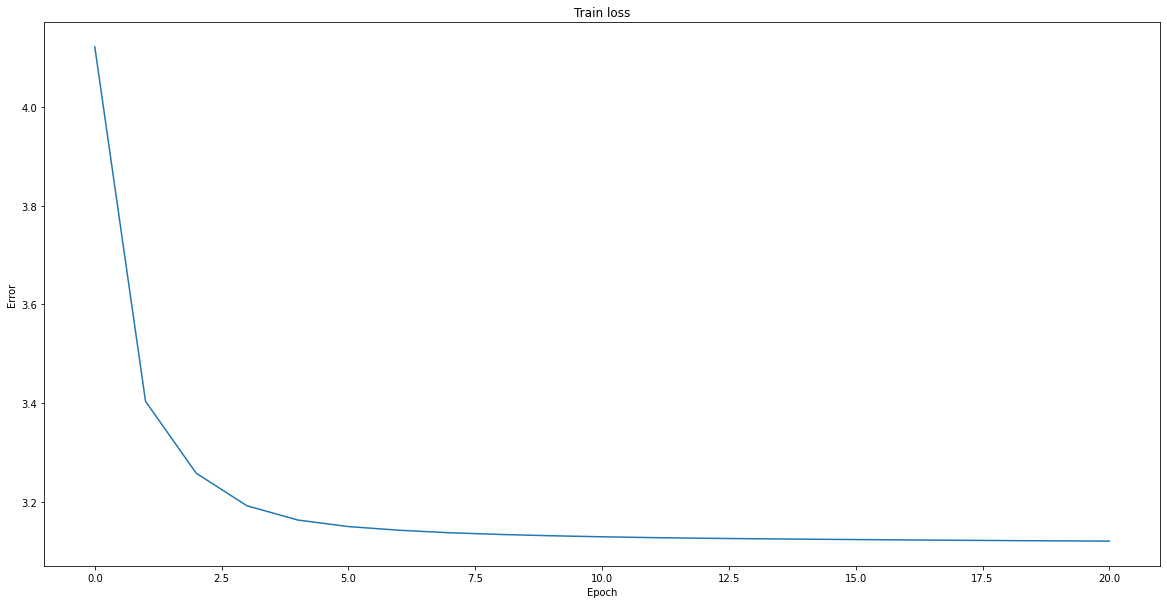

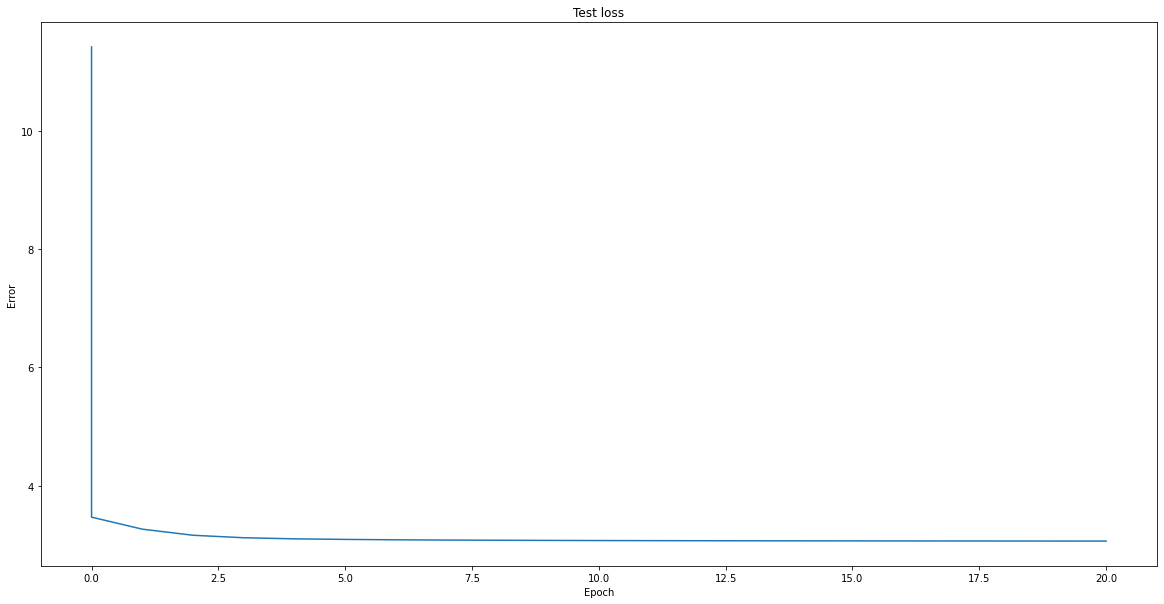

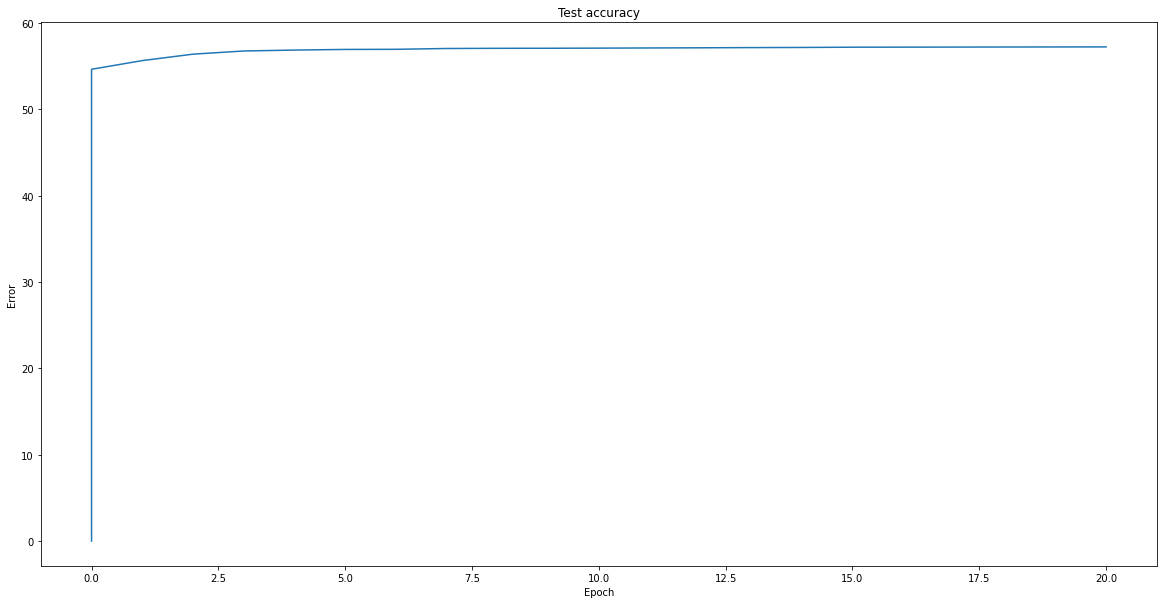

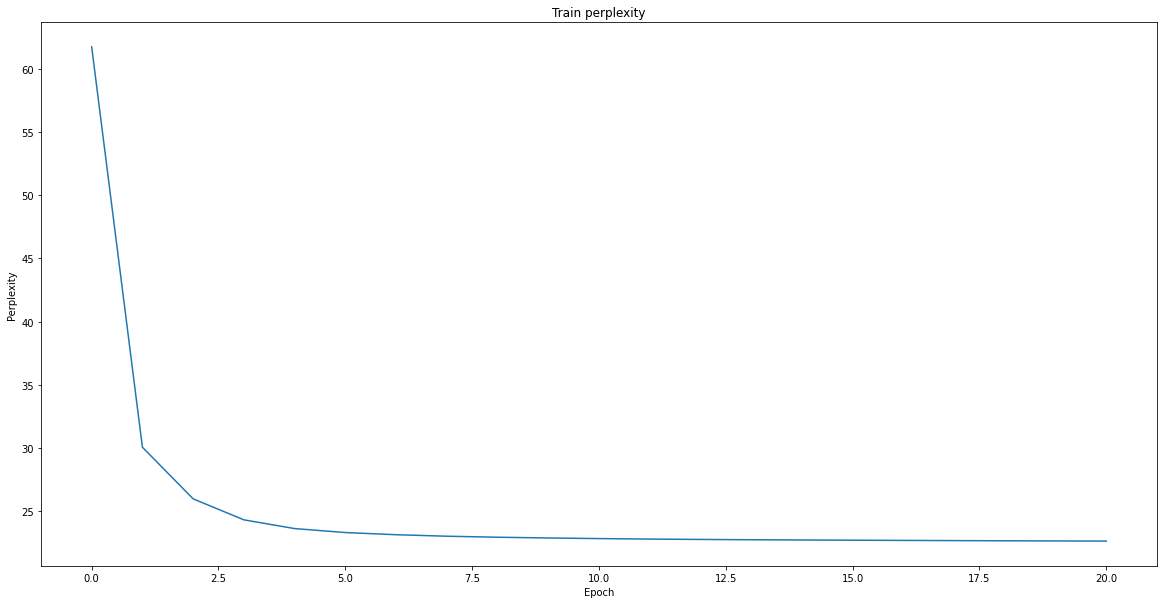

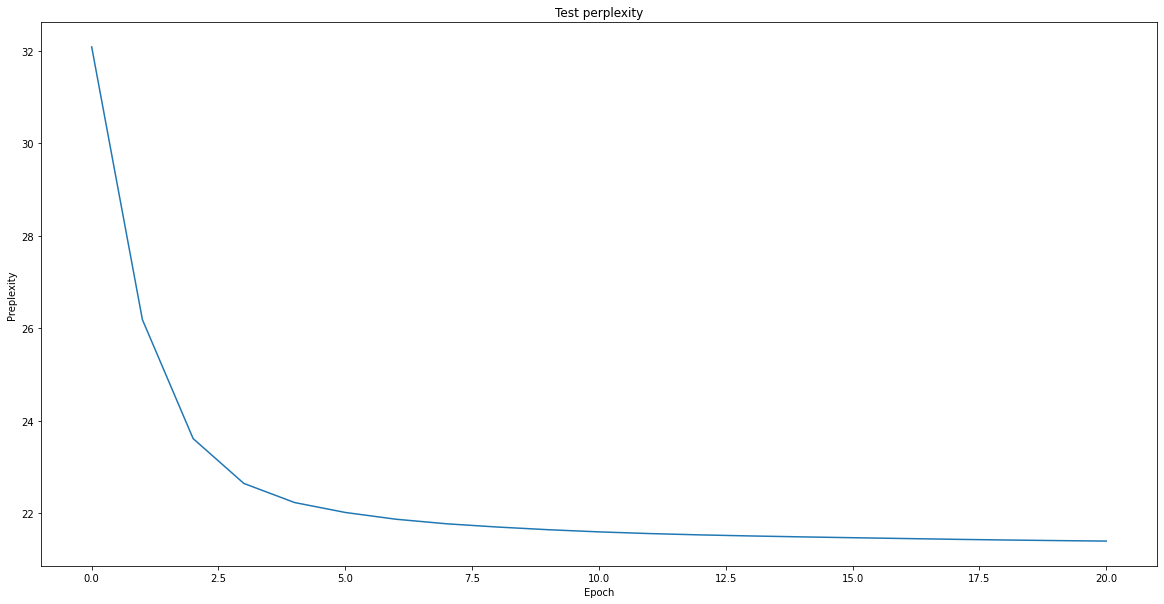

In [ ]:
def main():
    SEQUENCE_LENGTH = 10
    BATCH_SIZE = 256
    FEATURE_SIZE = 50
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    
    print(data_train.vocab_size())
    #print(data_train.vocab.voc2ind)
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device) 

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = 0 #model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, np.exp(train_loss)))
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Preplexity')
        return model, vocab, device

final_model, vocab, device = main()

Words

What new difficulties did you run into while training?

Since now we are dealing with words instead of characters, we have basically reduced our data set by grouping multiple characters into one. There are also many words appearing less tha 5 times, cause the model generate unknown tags.  



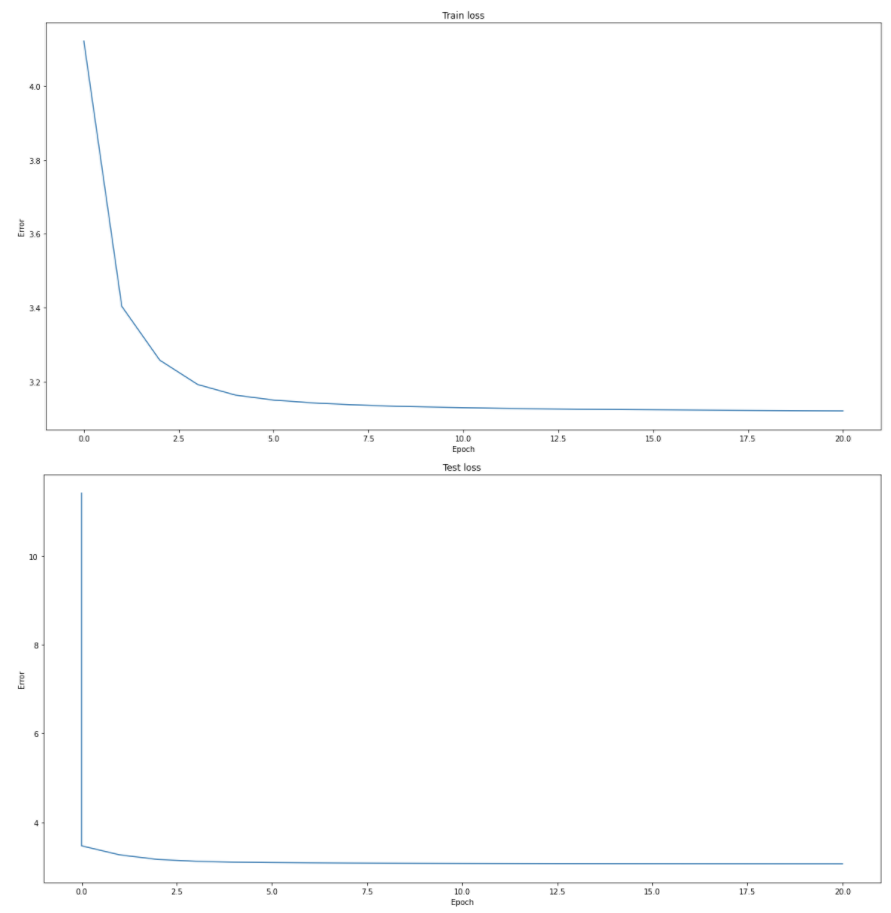

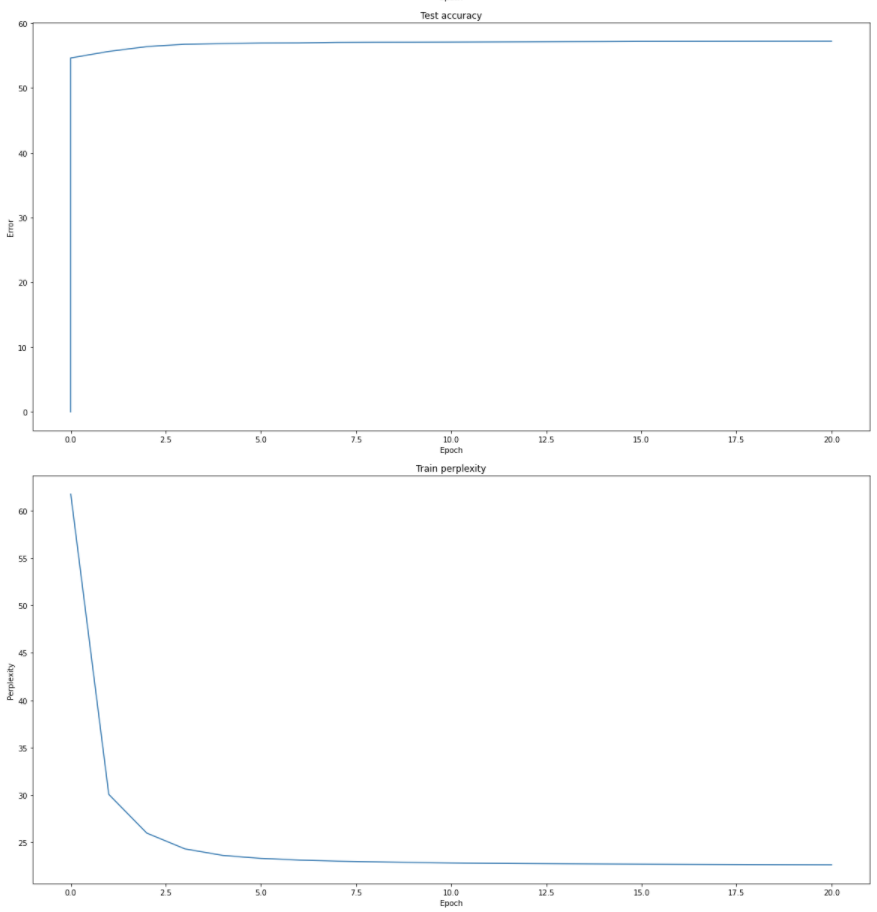

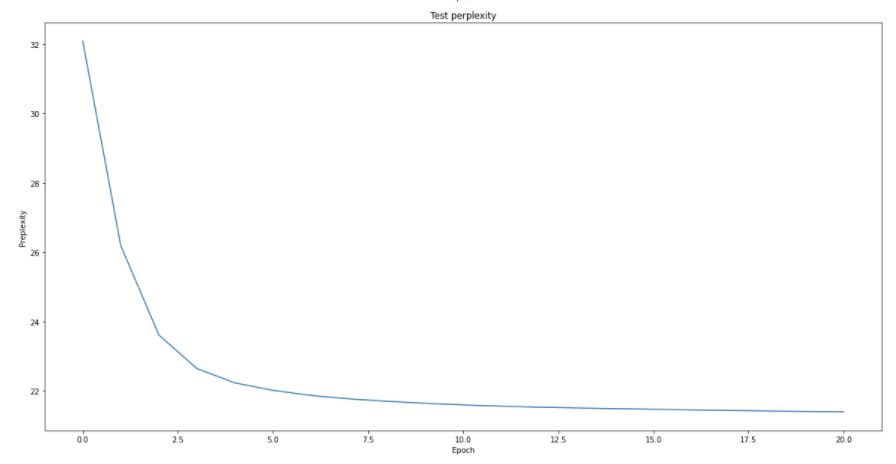



How large was your vocabulary?

14403 unique words were present in the vocab

Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

Since each sequence now is one word, I reduced the sequence length reduce of amount of characters we get for each batch. Batch size did not change and feature size decreased since words don't have as many features to keep track of than long series of characters. 

# Part 9: LSTM

Use an LSTM instead of a GRU.
https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
The output of an LSTM is a hidden state and a cell state, so you will need to deal with a tuple instead of a single vector.

In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	v35.R[a*`W5k5.gW/3[[gvW3.!v5ggaBaQvBBgZv...EG[[}3/D/3G366G2}}}D/VvB`Gg5W3/IE'$a_EEk.&J/.W&7-/9Gg553.


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	k$`WRW5%QvB3tav.BBgZv63.gW/3...&_Vv[4RW3I-dX[[W$kR3..$SSNga$3aQvBg1c3`9vEGav.BaBvaB*N[[[W3%QvBBBvk5(


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	g5vk&gx5.g5/j&&cc7gx55g/%BvB6WWW_[33*3NQvBJ_.2S3Wxk3Vp.v9AB7g/33x`?R[Wv}3N$k33$R3B3k.&x[[36$x[GaB3G.


Input	 hel

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 8.8624, Accuracy: 15997/1254400 (1%)



  1%|          | 1/195 [00:00<00:36,  5.32it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.813388


  7%|▋         | 13/195 [00:00<00:14, 12.97it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.435395


 12%|█▏        | 23/195 [00:01<00:11, 15.58it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.908735


 17%|█▋        | 33/195 [00:02<00:10, 15.77it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.365311


 22%|██▏       | 43/195 [00:02<00:09, 15.93it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.187635


 27%|██▋       | 53/195 [00:03<00:08, 16.17it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.061851


 32%|███▏      | 63/195 [00:04<00:08, 16.13it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.003118


 37%|███▋      | 73/195 [00:04<00:07, 15.66it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.940536


 43%|████▎     | 83/195 [00:05<00:07, 15.79it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.896336


 48%|████▊     | 93/195 [00:05<00:06, 16.16it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.873907


 53%|█████▎    | 103/195 [00:06<00:05, 16.30it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.827257


 58%|█████▊    | 113/195 [00:07<00:05, 16.01it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.797014


 63%|██████▎   | 123/195 [00:07<00:04, 15.75it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.795570


 68%|██████▊   | 133/195 [00:08<00:03, 15.75it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.780264


 73%|███████▎  | 143/195 [00:09<00:03, 15.87it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.764754


 78%|███████▊  | 153/195 [00:09<00:02, 16.15it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.739597


 84%|████████▎ | 163/195 [00:10<00:02, 15.99it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.709739


 89%|████████▊ | 173/195 [00:10<00:01, 15.77it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.694410


 94%|█████████▍| 183/195 [00:11<00:00, 16.10it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.672798


 99%|█████████▉| 193/195 [00:12<00:00, 16.29it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.666272


100%|██████████| 195/195 [00:12<00:00, 15.84it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeathtednttnd toasdd tnain   the sane  etasl  "I sn tarti .  "e said  "Ion't taudi  whde  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed toe sft   tane  wnd tarry wa p d tumbledore teck tn o the snk wtet yed,ahet torl d toe saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd toodpeng tn the saseie tf the soyk aashttnaien tn tagw end   "ir tf  taw odle torent oarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Seet... I'll as tell o on his not of his entride an he ep in the eggles and the of his for have had of his on had and he said even to he of his in ther one of of it... Harry for the had a looking of h



  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.678303


  7%|▋         | 13/195 [00:00<00:13, 13.50it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.668139


 12%|█▏        | 23/195 [00:01<00:11, 15.60it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.647539


 17%|█▋        | 33/195 [00:02<00:10, 16.13it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.650583


 22%|██▏       | 43/195 [00:02<00:09, 15.83it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.630649


 27%|██▋       | 53/195 [00:03<00:09, 15.60it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.607623


 32%|███▏      | 63/195 [00:04<00:08, 15.99it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.601904


 37%|███▋      | 73/195 [00:04<00:07, 15.29it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.594799


 43%|████▎     | 83/195 [00:05<00:07, 15.82it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.572578


 48%|████▊     | 93/195 [00:05<00:06, 16.03it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.577674


 53%|█████▎    | 103/195 [00:06<00:05, 15.83it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.573797


 58%|█████▊    | 113/195 [00:07<00:05, 15.55it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.555412


 63%|██████▎   | 123/195 [00:07<00:04, 15.90it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.559470


 68%|██████▊   | 133/195 [00:08<00:03, 15.72it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.583149


 73%|███████▎  | 143/195 [00:09<00:03, 15.77it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.564606


 78%|███████▊  | 153/195 [00:09<00:02, 16.25it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.554349


 84%|████████▎ | 163/195 [00:10<00:02, 15.76it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.534215


 89%|████████▊ | 173/195 [00:10<00:01, 15.98it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.518538


 94%|█████████▍| 183/195 [00:11<00:00, 16.08it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.509318


 99%|█████████▉| 193/195 [00:12<00:00, 16.13it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.507404


100%|██████████| 195/195 [00:12<00:00, 15.77it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat totnttnd soaved tnain,t toe sore  etasl  "I sn Hhrri .  "e said  "Ion't sauky  wtdt" said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d toe snt r tare  and sarry saap d tumbledore weck on o the cnk ttet yed,toet horl d ooe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng ttd soenpeng tn the sogdle of the sork aashtanuiet on tagwmeaded "or an  talrible torent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked others and looking in the old and out of his on his had need to tell though he had been for it not on tell for his on the aroun a in the lip on the talking to that tell front of tell one 



  1%|          | 1/195 [00:00<00:29,  6.47it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.524503


  7%|▋         | 13/195 [00:00<00:13, 13.49it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.524328


 12%|█▏        | 23/195 [00:01<00:11, 15.62it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.506184


 17%|█▋        | 33/195 [00:02<00:10, 15.80it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.514724


 22%|██▏       | 43/195 [00:02<00:09, 15.72it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.501802


 27%|██▋       | 53/195 [00:03<00:08, 15.85it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.493808


 32%|███▏      | 63/195 [00:04<00:08, 15.94it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.493041


 37%|███▋      | 73/195 [00:04<00:07, 15.78it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.488603


 43%|████▎     | 83/195 [00:05<00:06, 16.00it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.470738


 48%|████▊     | 93/195 [00:05<00:06, 15.95it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.490649


 53%|█████▎    | 103/195 [00:06<00:05, 16.18it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.492352


 58%|█████▊    | 113/195 [00:07<00:05, 16.06it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.477504


 63%|██████▎   | 123/195 [00:07<00:04, 15.90it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.470171


 68%|██████▊   | 133/195 [00:08<00:03, 15.92it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.503573


 73%|███████▎  | 143/195 [00:09<00:03, 15.85it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.487358


 78%|███████▊  | 153/195 [00:09<00:02, 15.86it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.474411


 84%|████████▎ | 163/195 [00:10<00:02, 15.95it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.457531


 89%|████████▊ | 173/195 [00:10<00:01, 16.23it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.444699


 94%|█████████▍| 183/195 [00:11<00:00, 15.93it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.438400


 99%|█████████▉| 193/195 [00:12<00:00, 16.10it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.444942


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat titntond soaved ttain,t the sose  atask  "I ts ahrr  .  "e said  "Won't sauky  tot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d the stt s oare  and tarry saap d aumbledore seck tn o the cnr ooet yed toet honl d ooe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng ttd soonpeng tn the soddle of the sork oashtanuuet an tagwmeade  "ir an  oilrible aorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry asked out of his handwing to on his need out of his on his had on the old onto the little a of his had out of tell on his eye are on his one of and one of or his one his had on his hard on the o



  1%|          | 1/195 [00:00<00:29,  6.52it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.469075


  7%|▋         | 13/195 [00:00<00:13, 13.73it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.466898


 12%|█▏        | 23/195 [00:01<00:10, 15.71it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.455241


 17%|█▋        | 33/195 [00:02<00:10, 16.05it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.464130


 22%|██▏       | 43/195 [00:02<00:09, 16.06it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.445431


 27%|██▋       | 53/195 [00:03<00:08, 15.83it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.431344


 32%|███▏      | 63/195 [00:04<00:08, 15.77it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.442632


 37%|███▋      | 73/195 [00:04<00:07, 16.10it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.436555


 43%|████▎     | 83/195 [00:05<00:07, 15.87it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.414866


 48%|████▊     | 93/195 [00:05<00:06, 15.73it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.430080


 53%|█████▎    | 103/195 [00:06<00:05, 15.87it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.437622


 58%|█████▊    | 113/195 [00:07<00:05, 15.99it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.438395


 63%|██████▎   | 123/195 [00:07<00:04, 16.03it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.452080


 68%|██████▊   | 133/195 [00:08<00:03, 15.92it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.448958


 73%|███████▎  | 143/195 [00:09<00:03, 15.98it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.437768


 78%|███████▊  | 153/195 [00:09<00:02, 15.66it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.434229


 84%|████████▎ | 163/195 [00:10<00:02, 15.73it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.422242


 89%|████████▊ | 173/195 [00:10<00:01, 15.84it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.396003


 94%|█████████▍| 183/195 [00:11<00:00, 16.25it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.394679


 99%|█████████▉| 193/195 [00:12<00:00, 16.18it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.407985


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet ohgntond seaned atain,t the sose  oaask  "I ss thrr  .  "e said  "Won't saury "wot," said Her


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the snt s aore  and serry saap d aumbledore seck tnto the cnr ohet yed aoet honl d ohe soeaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd seenpeng hn the soddle of the sork oash anuuet an tagwmeade  "ir an  oewrible aorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione, need positing on a one of his eyes from the forst of her on his on his wand from he had been he essiting it as he had been in her had on the other for the other inside he added on his hand o



  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.424949


  7%|▋         | 13/195 [00:00<00:13, 13.56it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.420509


 12%|█▏        | 23/195 [00:01<00:11, 15.61it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.416406


 17%|█▋        | 33/195 [00:02<00:10, 15.96it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.431149


 22%|██▏       | 43/195 [00:02<00:09, 16.03it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.414102


 27%|██▋       | 53/195 [00:03<00:08, 16.01it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.396842


 32%|███▏      | 63/195 [00:04<00:08, 15.56it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.409202


 37%|███▋      | 73/195 [00:04<00:07, 15.51it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.400230


 43%|████▎     | 83/195 [00:05<00:07, 15.95it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.393838


 48%|████▊     | 93/195 [00:05<00:06, 15.94it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.410996


 53%|█████▎    | 103/195 [00:06<00:05, 16.00it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.399930


 58%|█████▊    | 113/195 [00:07<00:05, 15.89it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.400002


 63%|██████▎   | 123/195 [00:07<00:04, 16.11it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.465475


 68%|██████▊   | 133/195 [00:08<00:03, 15.80it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.448587


 73%|███████▎  | 143/195 [00:09<00:03, 15.76it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.414834


 78%|███████▊  | 153/195 [00:09<00:02, 15.57it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.405212


 84%|████████▎ | 163/195 [00:10<00:02, 15.99it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.397504


 89%|████████▊ | 173/195 [00:10<00:01, 15.78it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.375007


 94%|█████████▍| 183/195 [00:11<00:00, 15.95it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.374168


 99%|█████████▉| 193/195 [00:12<00:00, 15.75it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.389071


100%|██████████| 195/195 [00:12<00:00, 15.73it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet togntond totned ttain,t the tose  oaask  "I ts thrr  .  "e said  "Won't wanky  wot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ttt n aore  and tarry saap d tumbledore teck tn o the cnr ooct yer toat tonl d the booaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng htd soanpeng hn the coddle of the cork oash anuuet an tagwmeade  "ir tu  oawrible aorent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The front of the said on his others and looked patch other to his had been loke up his hand to have as though it passed out of his had beneat from the corridor of his arm and undred other to tell his 



  1%|          | 1/195 [00:00<00:30,  6.36it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.408584


  7%|▋         | 13/195 [00:00<00:13, 13.55it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.400486


 12%|█▏        | 23/195 [00:01<00:11, 15.39it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.396134


 17%|█▋        | 33/195 [00:02<00:10, 15.77it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.404356


 22%|██▏       | 43/195 [00:02<00:09, 16.16it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.391340


 27%|██▋       | 53/195 [00:03<00:08, 15.90it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.380242


 32%|███▏      | 63/195 [00:04<00:08, 15.98it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.394899


 37%|███▋      | 73/195 [00:04<00:07, 15.89it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.381540


 43%|████▎     | 83/195 [00:05<00:07, 15.81it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.372579


 48%|████▊     | 93/195 [00:05<00:06, 15.89it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.392955


 53%|█████▎    | 103/195 [00:06<00:05, 16.05it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.388705


 58%|█████▊    | 113/195 [00:07<00:05, 16.03it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.395980


 63%|██████▎   | 123/195 [00:07<00:04, 15.94it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.412959


 68%|██████▊   | 133/195 [00:08<00:03, 15.80it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.418467


 73%|███████▎  | 143/195 [00:09<00:03, 15.97it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.396588


 78%|███████▊  | 153/195 [00:09<00:02, 16.08it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.384965


 84%|████████▎ | 163/195 [00:10<00:02, 15.70it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.378573


 89%|████████▊ | 173/195 [00:10<00:01, 15.80it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.364808


 94%|█████████▍| 183/195 [00:11<00:00, 16.01it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.365073


 99%|█████████▉| 193/195 [00:12<00:00, 16.12it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.373797


100%|██████████| 195/195 [00:12<00:00, 15.80it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet togntond toaned ttain,t the cose  owask  "I ts th r  .  "e said  "Won't wanky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctt r tare  hnd tarry saap d tumbledore teck tn o the cnr ooct yer toat horled hhe cooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng htd seenpeng hn the coddle of the cork oashthnuuetswn tagwmeade  "or tf  oewrible torent,tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Well... as he trute other had happened in the fores from his own side of his had been passed his wand to his had been on his one for his eyes for his hand on his had beneen into her and the other had 



  1%|          | 1/195 [00:00<00:30,  6.31it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.394364


  7%|▋         | 13/195 [00:00<00:13, 13.27it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.387898


 12%|█▏        | 23/195 [00:01<00:11, 15.35it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.392337


 17%|█▋        | 33/195 [00:02<00:10, 16.07it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.399001


 22%|██▏       | 43/195 [00:02<00:09, 15.59it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.378262


 27%|██▋       | 53/195 [00:03<00:09, 15.66it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.368610


 32%|███▏      | 63/195 [00:04<00:08, 15.86it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.382894


 37%|███▋      | 73/195 [00:04<00:07, 16.04it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.369515


 43%|████▎     | 83/195 [00:05<00:07, 15.58it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.362133


 48%|████▊     | 93/195 [00:05<00:06, 15.89it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.379878


 53%|█████▎    | 103/195 [00:06<00:05, 15.98it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.377248


 58%|█████▊    | 113/195 [00:07<00:05, 15.90it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.399611


 63%|██████▎   | 123/195 [00:07<00:04, 16.12it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.409152


 68%|██████▊   | 133/195 [00:08<00:03, 16.08it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.398914


 73%|███████▎  | 143/195 [00:09<00:03, 15.74it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.396632


 78%|███████▊  | 153/195 [00:09<00:02, 15.96it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.375399


 84%|████████▎ | 163/195 [00:10<00:02, 15.86it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.371041


 89%|████████▊ | 173/195 [00:10<00:01, 15.89it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.356946


 94%|█████████▍| 183/195 [00:11<00:00, 16.13it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.358841


 99%|█████████▉| 193/195 [00:12<00:00, 16.06it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.367247


100%|██████████| 195/195 [00:12<00:00, 15.75it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet thlntond toaned tnain,t the case  owask  "I tn th rn .  "e said  "Hun't yarky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the ctn r tane  and tarry saaped tumbledore teck tnto the cnr ohat yer,aoat horled the sooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering htd seenpeng hn the condle of the cark washthnueetswn tagwmeade  "or tf  oewrible tovent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Lok the patch of her had beneat to empty his had beneat him he and suppose he watched he had bented other to tell on his had beneath his one and his one and he added one his hand as he thought he had 



  1%|          | 1/195 [00:00<00:31,  6.15it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.383031


  7%|▋         | 13/195 [00:00<00:13, 13.45it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.378366


 12%|█▏        | 23/195 [00:01<00:10, 15.76it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.379282


 17%|█▋        | 33/195 [00:02<00:10, 15.93it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.386801


 22%|██▏       | 43/195 [00:02<00:09, 16.01it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.372920


 27%|██▋       | 53/195 [00:03<00:08, 15.90it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.364022


 32%|███▏      | 63/195 [00:04<00:08, 16.25it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.371673


 37%|███▋      | 73/195 [00:04<00:07, 16.33it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.366485


 43%|████▎     | 83/195 [00:05<00:07, 15.70it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.354886


 48%|████▊     | 93/195 [00:05<00:06, 15.48it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.376536


 53%|█████▎    | 103/195 [00:06<00:05, 15.98it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.370768


 58%|█████▊    | 113/195 [00:07<00:05, 15.97it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.365088


 63%|██████▎   | 123/195 [00:07<00:04, 16.09it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.393788


 68%|██████▊   | 133/195 [00:08<00:03, 15.97it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.396979


 73%|███████▎  | 143/195 [00:09<00:03, 15.64it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.385228


 78%|███████▊  | 153/195 [00:09<00:02, 15.83it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.370220


 84%|████████▎ | 163/195 [00:10<00:02, 15.91it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.363644


 89%|████████▊ | 173/195 [00:10<00:01, 15.67it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.348914


 94%|█████████▍| 183/195 [00:11<00:00, 15.89it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.344455


 99%|█████████▉| 193/195 [00:12<00:00, 16.20it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.358755


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet sulntand soanid tnain,t the sose  owask  "I tn te rn .  "e said, "Hun't yorry  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	issed the stn r tone  and tarry saaded tumbledore teck tnto the cnr ohar,yer,aoat horled toe sooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering htd seinpeng hn the condle of the cark washtanuiethwn tagwmeade  "ir tf  oewrible sovent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "''ve go don, he hadn't happened to tell him out for its from here," asid Hermione and Hermione had been only on his head on his head of his hand in his had been rasing into his wand and tride to have



  1%|          | 1/195 [00:00<00:32,  6.05it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.380830


  7%|▋         | 13/195 [00:00<00:13, 13.43it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.374713


 12%|█▏        | 23/195 [00:01<00:11, 15.47it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.367687


 17%|█▋        | 33/195 [00:02<00:10, 15.47it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.378852


 22%|██▏       | 43/195 [00:02<00:09, 15.70it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.370795


 27%|██▋       | 53/195 [00:03<00:08, 16.13it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.373533


 32%|███▏      | 63/195 [00:04<00:08, 16.01it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.379045


 37%|███▋      | 73/195 [00:04<00:07, 15.75it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.364824


 43%|████▎     | 83/195 [00:05<00:06, 16.12it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.348586


 48%|████▊     | 93/195 [00:05<00:06, 15.86it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.366026


 53%|█████▎    | 103/195 [00:06<00:05, 15.70it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.364752


 58%|█████▊    | 113/195 [00:07<00:05, 16.15it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.346747


 63%|██████▎   | 123/195 [00:07<00:04, 15.86it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.363166


 68%|██████▊   | 133/195 [00:08<00:03, 15.62it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.392418


 73%|███████▎  | 143/195 [00:09<00:03, 15.70it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.384494


 78%|███████▊  | 153/195 [00:09<00:02, 16.09it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.369581


 84%|████████▎ | 163/195 [00:10<00:01, 16.36it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.367173


 89%|████████▊ | 173/195 [00:10<00:01, 16.19it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.345874


 94%|█████████▍| 183/195 [00:11<00:00, 15.97it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.347558


 99%|█████████▉| 193/195 [00:12<00:00, 16.20it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.364048


100%|██████████| 195/195 [00:12<00:00, 15.80it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet stlntond soanid tnain,t the core  owisk  "I tn shlr  .  "e said, "Iun't yarry  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	iueed the ctn r thne  and tarry saaded tumbledore teck tnto the cnr ohat,ler,ahan hrrled toe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering htd seenpeng hn the candle of the cark waghthnueethwn tagwmeade  "ir tf  oewrible sovent tarr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. when he had entered his head of his letter in the dormitory of the rom on the arm not into the air from he had happened out from the other right out of his hands and telling her hand on his hand and h



  1%|          | 1/195 [00:00<00:31,  6.22it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.375810


  7%|▋         | 13/195 [00:00<00:13, 13.53it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.379451


 12%|█▏        | 23/195 [00:01<00:11, 15.37it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.366767


 17%|█▋        | 33/195 [00:02<00:10, 15.96it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.378397


 22%|██▏       | 43/195 [00:02<00:09, 15.91it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.360258


 27%|██▋       | 53/195 [00:03<00:08, 15.86it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.353321


 32%|███▏      | 63/195 [00:04<00:08, 15.94it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.366313


 37%|███▋      | 73/195 [00:04<00:07, 16.17it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.358297


 43%|████▎     | 83/195 [00:05<00:06, 16.03it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.342572


 48%|████▊     | 93/195 [00:05<00:06, 15.81it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.367117


 53%|█████▎    | 103/195 [00:06<00:05, 15.81it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.367036


 58%|█████▊    | 113/195 [00:07<00:05, 16.17it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.345410


 63%|██████▎   | 123/195 [00:07<00:04, 16.14it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.356770


 68%|██████▊   | 133/195 [00:08<00:03, 15.96it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.380196


 73%|███████▎  | 143/195 [00:09<00:03, 16.27it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.375916


 78%|███████▊  | 153/195 [00:09<00:02, 15.78it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.365360


 84%|████████▎ | 163/195 [00:10<00:02, 15.87it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.347266


 89%|████████▊ | 173/195 [00:10<00:01, 15.93it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.341850


 94%|█████████▍| 183/195 [00:11<00:00, 15.82it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.346397


 99%|█████████▉| 193/195 [00:12<00:00, 15.83it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.358863


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat stlntand soaved ttain,t the sore  oaask  "I tn selr  .  "e said, "Iun't wauky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	iueed the stt r aore  and sarry saaded aumbledore aeck tnto the cnr otathler,aoat horled toe sooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd seenpeng hn the caddle of the cork waghtanueethan tagwmeade  "ir tf  oeurible sovent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. You need to tell him of his eye had never looked pathing at all over her own front for the attenting to tell the laging of his wand at he had enered her eyes no neros he and he had been tride out of h



  1%|          | 1/195 [00:00<00:32,  5.96it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.370694


  7%|▋         | 13/195 [00:00<00:13, 13.29it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.364123


 12%|█▏        | 23/195 [00:01<00:11, 15.22it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.359200


 17%|█▋        | 33/195 [00:02<00:10, 15.77it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.369777


 22%|██▏       | 43/195 [00:02<00:09, 15.81it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.362126


 27%|██▋       | 53/195 [00:03<00:08, 16.17it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.349195


 32%|███▏      | 63/195 [00:04<00:08, 16.22it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.364678


 37%|███▋      | 73/195 [00:04<00:07, 16.01it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.353623


 43%|████▎     | 83/195 [00:05<00:07, 15.79it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.340529


 48%|████▊     | 93/195 [00:05<00:06, 15.67it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.359052


 53%|█████▎    | 103/195 [00:06<00:05, 15.55it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.367000


 58%|█████▊    | 113/195 [00:07<00:05, 15.75it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.341548


 63%|██████▎   | 123/195 [00:07<00:04, 15.86it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.351159


 68%|██████▊   | 133/195 [00:08<00:03, 15.77it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.373032


 73%|███████▎  | 143/195 [00:09<00:03, 15.92it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.366601


 78%|███████▊  | 153/195 [00:09<00:02, 16.12it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.360911


 84%|████████▎ | 163/195 [00:10<00:02, 15.72it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.343070


 89%|████████▊ | 173/195 [00:11<00:01, 16.07it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.336382


 94%|█████████▍| 183/195 [00:11<00:00, 16.03it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.347902


 99%|█████████▉| 193/195 [00:12<00:00, 16.06it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.354828


100%|██████████| 195/195 [00:12<00:00, 15.74it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat stlntand soaded ttain,t the care   wask  "I wn shlr  .  "e said, "Iun't warky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aueed the ctt r aore  and tarry saaded aumbledore aeck tnto the cnr ooarhler,aoat hrrled toe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd saanpeng hn the caddle of the cark waghtanueethan tagwmeade  "ir af  oeurible savent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. had been already on his hand and tried out for the table on the rome from his had and a one of he added and looked into her eyes into the inde and all had been had been across the other in he added an



  1%|          | 1/195 [00:00<00:29,  6.55it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.367212


  7%|▋         | 13/195 [00:00<00:13, 13.37it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.361556


 12%|█▏        | 23/195 [00:01<00:11, 15.35it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.359915


 17%|█▋        | 33/195 [00:02<00:10, 15.90it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.364789


 22%|██▏       | 43/195 [00:02<00:09, 15.98it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.351974


 27%|██▋       | 53/195 [00:03<00:08, 16.03it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.343163


 32%|███▏      | 63/195 [00:04<00:08, 15.71it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.358552


 37%|███▋      | 73/195 [00:04<00:07, 15.82it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.348152


 43%|████▎     | 83/195 [00:05<00:07, 15.88it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.336684


 48%|████▊     | 93/195 [00:05<00:06, 15.67it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.349822


 53%|█████▎    | 103/195 [00:06<00:05, 15.89it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.355117


 58%|█████▊    | 113/195 [00:07<00:05, 15.93it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.338580


 63%|██████▎   | 123/195 [00:07<00:04, 15.97it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.351967


 68%|██████▊   | 133/195 [00:08<00:03, 15.94it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.369089


 73%|███████▎  | 143/195 [00:09<00:03, 15.65it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.360736


 78%|███████▊  | 153/195 [00:09<00:02, 15.81it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.355077


 84%|████████▎ | 163/195 [00:10<00:02, 15.54it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.338317


 89%|████████▊ | 173/195 [00:11<00:01, 15.75it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.329672


 94%|█████████▍| 183/195 [00:11<00:00, 15.92it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.344086


 99%|█████████▉| 193/195 [00:12<00:00, 15.89it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.349128


100%|██████████| 195/195 [00:12<00:00, 15.73it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soaded ttain,t the core  owask, "I wn shlr  .  "e said, "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnr oeat,red,aoat hrrled the cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd soanpeng hn the caddle of the cark wagh anueethan tagwmeade  "or af  oeurible sorent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. of terribed and had needed on the old front of his father had bened in her had been up an one front for the edge from the one from his hand and as he had been all the tabe from her eyes from her eyes 



  1%|          | 1/195 [00:00<00:30,  6.39it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.360836


  7%|▋         | 13/195 [00:00<00:13, 13.34it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.358087


 12%|█▏        | 23/195 [00:01<00:11, 15.37it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.356138


 17%|█▋        | 33/195 [00:02<00:10, 15.60it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.364237


 22%|██▏       | 43/195 [00:02<00:09, 16.13it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.345276


 27%|██▋       | 53/195 [00:03<00:08, 16.23it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.335773


 32%|███▏      | 63/195 [00:04<00:08, 16.20it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.353761


 37%|███▋      | 73/195 [00:04<00:07, 16.05it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.340590


 43%|████▎     | 83/195 [00:05<00:07, 15.72it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.333494


 48%|████▊     | 93/195 [00:05<00:06, 15.61it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.342073


 53%|█████▎    | 103/195 [00:06<00:05, 15.86it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.350369


 58%|█████▊    | 113/195 [00:07<00:05, 16.02it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.333137


 63%|██████▎   | 123/195 [00:07<00:04, 15.90it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.343979


 68%|██████▊   | 133/195 [00:08<00:03, 15.89it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.362084


 73%|███████▎  | 143/195 [00:09<00:03, 15.90it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.358970


 78%|███████▊  | 153/195 [00:09<00:02, 15.94it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.354855


 84%|████████▎ | 163/195 [00:10<00:01, 16.07it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.336184


 89%|████████▊ | 173/195 [00:10<00:01, 16.19it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.325606


 94%|█████████▍| 183/195 [00:11<00:00, 16.27it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.324544


 99%|█████████▉| 193/195 [00:12<00:00, 16.22it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.345811


100%|██████████| 195/195 [00:12<00:00, 15.83it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soanid tnain,t the core  owisk  "I wn selrl .  "e said, "Iun't warky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aueed the cnn r aore  and tarry saaded humbledore aeck tn o the cnr oeer,red,aoan hrrled toe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the candle of the cark wagh anueethan tagwmeade  "ir af  oeurible sarent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked into his hard not of his eyes on him and he had been loked out of his hand and he added out of her letter from the room into his eyes and heard of terride other into his arm and tried to 



  2%|▏         | 3/195 [00:00<00:39,  4.91it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.359137


  7%|▋         | 13/195 [00:01<00:15, 11.61it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.359350


 12%|█▏        | 23/195 [00:01<00:11, 15.33it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.349269


 17%|█▋        | 33/195 [00:02<00:10, 15.79it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.360390


 22%|██▏       | 43/195 [00:02<00:09, 15.87it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.377847


 27%|██▋       | 53/195 [00:03<00:09, 15.59it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.341870


 32%|███▏      | 63/195 [00:04<00:08, 15.97it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.346117


 37%|███▋      | 73/195 [00:04<00:07, 16.08it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.335033


 43%|████▎     | 83/195 [00:05<00:07, 15.84it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.330379


 48%|████▊     | 93/195 [00:06<00:06, 15.75it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.340957


 53%|█████▎    | 103/195 [00:06<00:05, 15.85it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.347526


 58%|█████▊    | 113/195 [00:07<00:05, 16.27it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.337888


 63%|██████▎   | 123/195 [00:07<00:04, 16.26it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.340891


 68%|██████▊   | 133/195 [00:08<00:03, 15.93it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.354990


 73%|███████▎  | 143/195 [00:09<00:03, 16.02it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.354876


 78%|███████▊  | 153/195 [00:09<00:02, 15.85it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.351132


 84%|████████▎ | 163/195 [00:10<00:01, 16.13it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.334772


 89%|████████▊ | 173/195 [00:11<00:01, 15.86it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.320373


 94%|█████████▍| 183/195 [00:11<00:00, 15.73it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.323306


 99%|█████████▉| 193/195 [00:12<00:00, 16.08it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.343173


100%|██████████| 195/195 [00:12<00:00, 15.69it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soaned ttain,t the care  owisk  "I wm selr  .  "e said, "Iun't warky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctn r aore  and tarry saaded humbledore aeck tnto the cnr oeer,red,aoat hrrled toe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I have been all right from the only one had been happened on the time of the room and looked around the end of the front of the edge of her and looked into his eyes of her had been added and looked ar



  1%|          | 1/195 [00:00<00:31,  6.24it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.355668


  7%|▋         | 13/195 [00:00<00:13, 13.23it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.352180


 12%|█▏        | 23/195 [00:01<00:11, 15.45it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.346771


 17%|█▋        | 33/195 [00:02<00:10, 15.93it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.354338


 22%|██▏       | 43/195 [00:02<00:09, 15.85it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.345944


 27%|██▋       | 53/195 [00:03<00:08, 16.27it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.328384


 32%|███▏      | 63/195 [00:04<00:08, 16.04it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.341372


 37%|███▋      | 73/195 [00:04<00:07, 16.05it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.335011


 43%|████▎     | 83/195 [00:05<00:06, 16.12it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.327808


 48%|████▊     | 93/195 [00:05<00:06, 16.07it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.337645


 53%|█████▎    | 103/195 [00:06<00:05, 16.00it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.346323


 58%|█████▊    | 113/195 [00:07<00:05, 15.73it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.333228


 63%|██████▎   | 123/195 [00:07<00:04, 16.28it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.337301


 68%|██████▊   | 133/195 [00:08<00:03, 16.31it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.354268


 73%|███████▎  | 143/195 [00:09<00:03, 15.61it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.351347


 78%|███████▊  | 153/195 [00:09<00:02, 16.05it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.345647


 84%|████████▎ | 163/195 [00:10<00:02, 15.93it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.329069


 89%|████████▊ | 173/195 [00:10<00:01, 15.89it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.318775


 94%|█████████▍| 183/195 [00:11<00:00, 16.11it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.330958


 99%|█████████▉| 193/195 [00:12<00:00, 16.20it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.340295


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sulntond soaned ttain,t the care  owisk, "I wm salr  .  "e said, "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctn r aore  and tarry saaded humbledore aeck tnto the cnr oeet,red,aoat hrrled toe caoaeo 


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Wall of the end of the front of the table from her eye on his hand and looked into the offier lie. "hew are you all take up one of here. I have not undering them all tell that were all right of her, h



  1%|          | 1/195 [00:00<00:29,  6.66it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.354651


  7%|▋         | 13/195 [00:00<00:13, 13.92it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.348010


 12%|█▏        | 23/195 [00:01<00:11, 15.54it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.344607


 17%|█▋        | 33/195 [00:02<00:10, 15.90it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.348732


 22%|██▏       | 43/195 [00:02<00:09, 15.52it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.344403


 27%|██▋       | 53/195 [00:03<00:09, 15.50it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.320891


 32%|███▏      | 63/195 [00:04<00:08, 16.01it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.336082


 37%|███▋      | 73/195 [00:04<00:07, 15.85it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.330804


 43%|████▎     | 83/195 [00:05<00:07, 15.87it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.320813


 48%|████▊     | 93/195 [00:05<00:06, 15.93it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.333628


 53%|█████▎    | 103/195 [00:06<00:05, 15.79it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.347192


 58%|█████▊    | 113/195 [00:07<00:05, 16.00it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.330939


 63%|██████▎   | 123/195 [00:07<00:04, 15.85it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.335152


 68%|██████▊   | 133/195 [00:08<00:03, 15.94it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.354436


 73%|███████▎  | 143/195 [00:09<00:03, 15.99it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.347356


 78%|███████▊  | 153/195 [00:09<00:02, 16.04it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.342122


 84%|████████▎ | 163/195 [00:10<00:02, 15.82it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.321546


 89%|████████▊ | 173/195 [00:10<00:01, 15.72it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.313333


 94%|█████████▍| 183/195 [00:11<00:00, 15.83it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.345368


 99%|█████████▉| 193/195 [00:12<00:00, 16.12it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.336015


100%|██████████| 195/195 [00:12<00:00, 15.80it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet stlntond soaned ttain,t the care  owask, "I wn aalr  .  "e said, "Iun't warky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnr oeet red,aoan harled the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and soanpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked at all the name from the parchment for an odd into the air not one from his hand and headed on his head and all he added not one of his own and now and he loke out frot him and looked int



  1%|          | 1/195 [00:00<00:31,  6.12it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.351155


  7%|▋         | 13/195 [00:00<00:13, 13.40it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.344579


 12%|█▏        | 23/195 [00:01<00:11, 15.49it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.342536


 17%|█▋        | 33/195 [00:02<00:10, 15.96it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.345563


 22%|██▏       | 43/195 [00:02<00:09, 16.13it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.337155


 27%|██▋       | 53/195 [00:03<00:08, 16.25it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.319995


 32%|███▏      | 63/195 [00:04<00:08, 16.18it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.334074


 37%|███▋      | 73/195 [00:04<00:07, 16.07it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.327635


 43%|████▎     | 83/195 [00:05<00:06, 16.15it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.317978


 48%|████▊     | 93/195 [00:05<00:06, 16.08it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.327908


 53%|█████▎    | 103/195 [00:06<00:05, 16.14it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.342419


 58%|█████▊    | 113/195 [00:07<00:05, 16.13it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.328564


 63%|██████▎   | 123/195 [00:07<00:04, 16.35it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.330625


 68%|██████▊   | 133/195 [00:08<00:03, 16.13it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.353024


 73%|███████▎  | 143/195 [00:08<00:03, 16.21it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.345084


 78%|███████▊  | 153/195 [00:09<00:02, 16.14it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.341606


 84%|████████▎ | 163/195 [00:10<00:02, 15.88it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.319948


 89%|████████▊ | 173/195 [00:10<00:01, 15.98it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.313003


 94%|█████████▍| 183/195 [00:11<00:00, 15.70it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.329874


 99%|█████████▉| 193/195 [00:12<00:00, 16.02it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.332516


100%|██████████| 195/195 [00:12<00:00, 15.91it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soaned ttain,t the core ,owisk, "I dm aalr  .  "e said, "Iun't karky  yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnr oeet red,aoan hrrled the cooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent,warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He added into his hand around the edge of the room into the cape for the around into his hand an under the table in the office foretent other and looked around at all the time from her voice and looke



  1%|          | 1/195 [00:00<00:31,  6.26it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.344755


  7%|▋         | 13/195 [00:00<00:13, 13.75it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.344579


 12%|█▏        | 23/195 [00:01<00:10, 15.65it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.337124


 17%|█▋        | 33/195 [00:02<00:10, 15.88it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.342843


 22%|██▏       | 43/195 [00:02<00:09, 16.00it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.331085


 27%|██▋       | 53/195 [00:03<00:08, 15.87it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.317251


 32%|███▏      | 63/195 [00:04<00:08, 16.09it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.331114


 37%|███▋      | 73/195 [00:04<00:07, 15.76it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.325642


 43%|████▎     | 83/195 [00:05<00:07, 15.62it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.318219


 48%|████▊     | 93/195 [00:05<00:06, 15.61it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.326255


 53%|█████▎    | 103/195 [00:06<00:05, 15.80it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.331245


 58%|█████▊    | 113/195 [00:07<00:05, 16.12it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.326826


 63%|██████▎   | 123/195 [00:07<00:04, 15.74it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.328251


 68%|██████▊   | 133/195 [00:08<00:03, 15.94it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.348063


 73%|███████▎  | 143/195 [00:09<00:03, 15.87it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.345167


 78%|███████▊  | 153/195 [00:09<00:02, 15.80it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.338205


 84%|████████▎ | 163/195 [00:10<00:01, 16.00it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.316179


 89%|████████▊ | 173/195 [00:10<00:01, 15.77it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.313936


 94%|█████████▍| 183/195 [00:11<00:00, 16.23it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.315630


 99%|█████████▉| 193/195 [00:12<00:00, 16.21it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.329768


100%|██████████| 195/195 [00:12<00:00, 15.81it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soaned ttain,t the care  owisk, "I wm salrl .  "e said, "Iun't warky, yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnr oeet red,aoat hrrled the caoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and sranpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry nodded into the room into the corridor, and he needed to tell him everything into the office from his eye." Harry said from it off his hand and one of the parchment and Harry added into his had 



  1%|          | 1/195 [00:00<00:28,  6.81it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.341638


  7%|▋         | 13/195 [00:00<00:13, 13.84it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.339216


 12%|█▏        | 23/195 [00:01<00:11, 15.40it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.334552


 17%|█▋        | 33/195 [00:02<00:10, 15.85it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.340790


 22%|██▏       | 43/195 [00:02<00:09, 15.68it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.340744


 27%|██▋       | 53/195 [00:03<00:08, 16.34it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.311776


 32%|███▏      | 63/195 [00:04<00:08, 15.99it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.329857


 37%|███▋      | 73/195 [00:04<00:07, 15.94it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.321215


 43%|████▎     | 83/195 [00:05<00:06, 16.07it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.319843


 48%|████▊     | 93/195 [00:05<00:06, 15.95it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.324671


 53%|█████▎    | 103/195 [00:06<00:05, 16.26it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.331931


 58%|█████▊    | 113/195 [00:07<00:05, 16.03it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.333246


 63%|██████▎   | 123/195 [00:07<00:04, 15.70it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.331903


 68%|██████▊   | 133/195 [00:08<00:03, 16.22it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.344959


 73%|███████▎  | 143/195 [00:09<00:03, 16.03it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.341195


 78%|███████▊  | 153/195 [00:09<00:02, 16.01it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.337727


 84%|████████▎ | 163/195 [00:10<00:02, 15.57it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.312046


 89%|████████▊ | 173/195 [00:10<00:01, 15.87it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.309097


 94%|█████████▍| 183/195 [00:11<00:00, 15.82it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.319471


 99%|█████████▉| 193/195 [00:12<00:00, 16.28it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.328433


100%|██████████| 195/195 [00:12<00:00, 15.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soaned tnain,t the care .owisl, "I dm aalr  .  "e said, "Iun't warky, yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnr oeet red,aoan hrrled the caaaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and saanpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I have been telling out from one of the room in here, no one of him of her one from the office in the air and tried to it into her and her had never eppared on his eepred into his eyes on the air of h



  1%|          | 1/195 [00:00<00:33,  5.86it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.341945


  7%|▋         | 13/195 [00:00<00:13, 13.30it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.338982


 12%|█▏        | 23/195 [00:01<00:11, 15.46it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.334130


 17%|█▋        | 33/195 [00:02<00:10, 15.63it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.336906


 22%|██▏       | 43/195 [00:02<00:09, 16.20it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.334252


 27%|██▋       | 53/195 [00:03<00:08, 16.12it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.309915


 32%|███▏      | 63/195 [00:04<00:08, 15.98it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.324277


 37%|███▋      | 73/195 [00:04<00:07, 16.25it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.319940


 43%|████▎     | 83/195 [00:05<00:06, 16.05it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.317599


 48%|████▊     | 93/195 [00:05<00:06, 16.18it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.324445


 53%|█████▎    | 103/195 [00:06<00:05, 16.01it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.333362


 58%|█████▊    | 113/195 [00:07<00:05, 15.90it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.327098


 63%|██████▎   | 123/195 [00:07<00:04, 16.04it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.331220


 68%|██████▊   | 133/195 [00:08<00:03, 16.06it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.345502


 73%|███████▎  | 143/195 [00:09<00:03, 16.00it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.339000


 78%|███████▊  | 153/195 [00:09<00:02, 16.06it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.338150


 84%|████████▎ | 163/195 [00:10<00:01, 16.21it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.315539


 89%|████████▊ | 173/195 [00:10<00:01, 15.77it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.305702


 94%|█████████▍| 183/195 [00:11<00:00, 16.01it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.317832


 99%|█████████▉| 193/195 [00:12<00:00, 16.10it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.329783


100%|██████████| 195/195 [00:12<00:00, 15.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soaned tnain,t the care iotisl, "I dm solr  .  "e said  "Iun't warky, yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctn r aore  and harry saaded humbledore aeck tnto the cnr oeet red,aoan herled toe cooaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and seanpeng hn the caddle of the cark cagh anueet an tagwmeade  "ir tne oeurible sarent warr


Input	 help, but there was nobody to be see

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked at Harry to hard into his eye. Harry nodded his eyes off into his feet and had been enough on the first edge for the office of the room for the room of his added on his feet an hurried in



  1%|          | 1/195 [00:00<00:30,  6.37it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.342907


  7%|▋         | 13/195 [00:00<00:13, 13.44it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.335735


 12%|█▏        | 23/195 [00:01<00:11, 15.49it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.333400


 17%|█▋        | 33/195 [00:02<00:10, 16.09it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.338607


 22%|██▏       | 43/195 [00:02<00:09, 16.19it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.326383


 27%|██▋       | 53/195 [00:03<00:08, 16.13it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.305845


 32%|███▏      | 63/195 [00:04<00:08, 16.14it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.323675


 37%|███▋      | 73/195 [00:04<00:07, 15.99it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.319185


 43%|████▎     | 83/195 [00:05<00:06, 16.25it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.312855


 48%|████▊     | 93/195 [00:05<00:06, 16.09it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.321144


 53%|█████▎    | 103/195 [00:06<00:05, 15.59it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.329292


 58%|█████▊    | 113/195 [00:07<00:05, 15.89it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.321021


 63%|██████▎   | 123/195 [00:07<00:04, 15.91it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.322310


 68%|██████▊   | 133/195 [00:08<00:03, 15.93it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.344084


 73%|███████▎  | 143/195 [00:09<00:03, 16.18it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.336570


 78%|███████▊  | 153/195 [00:09<00:02, 16.14it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.332064


 84%|████████▎ | 163/195 [00:10<00:02, 15.79it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.307623


 89%|████████▊ | 173/195 [00:10<00:01, 16.06it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.303940


 94%|█████████▍| 183/195 [00:11<00:00, 15.94it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.319395


 99%|█████████▉| 193/195 [00:12<00:00, 15.84it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.327858


100%|██████████| 195/195 [00:12<00:00, 15.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet sulntond soanid tnain.t the case .otisl, "I dm salr  .  "e said, "Iun't warky, yor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aseed the ctt r aore  and tarry saaded humbledore aeck tnto the cnk oeet red,aoan hirled the cooaina


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and sianpeng hn the caddle of the cark cagh anueethan tagwmeade  "ir tne oeurible sarent warr


Input	 help, but there was nobody to be see

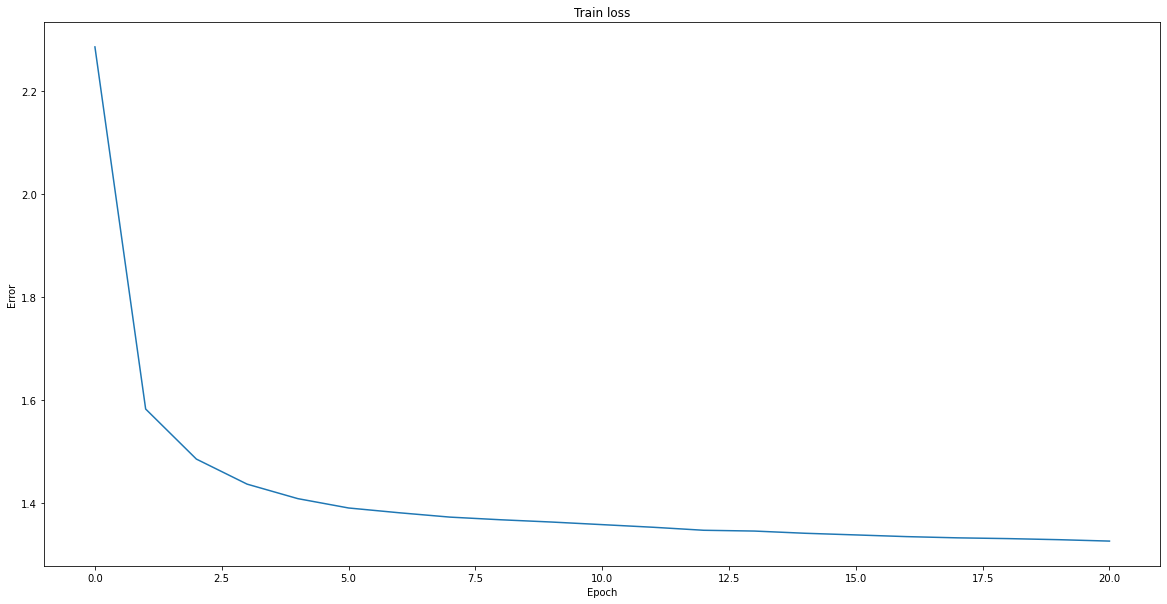

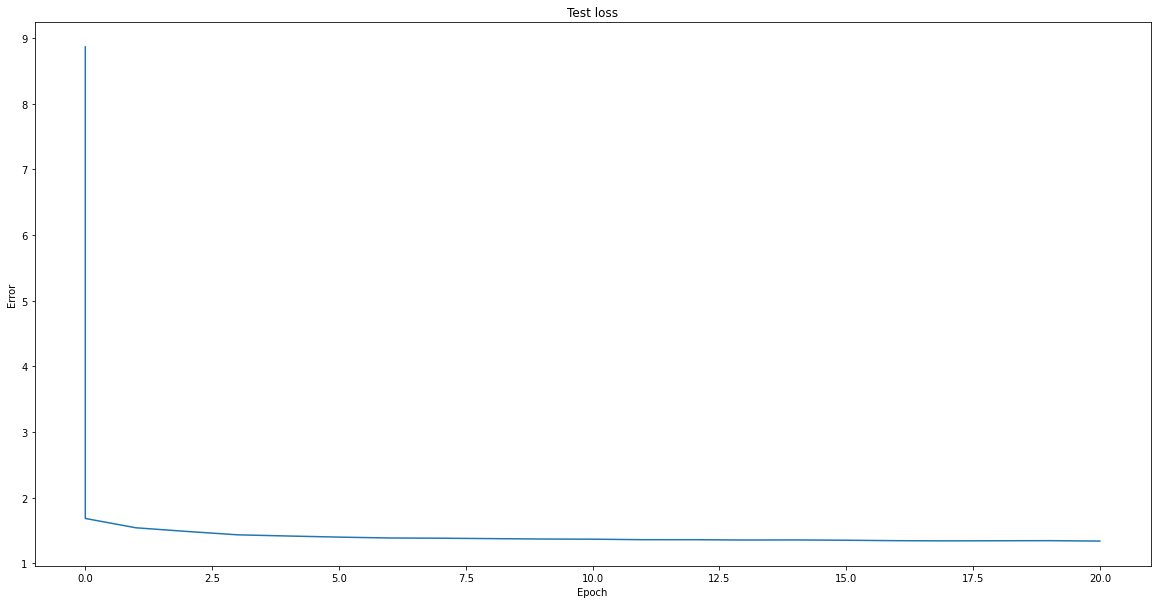

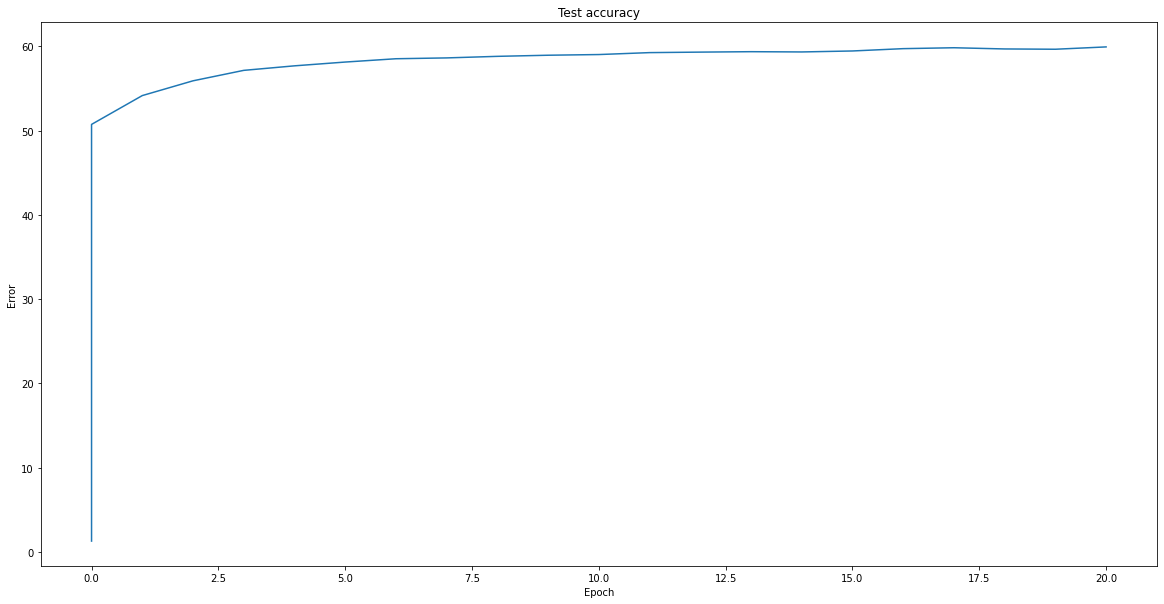

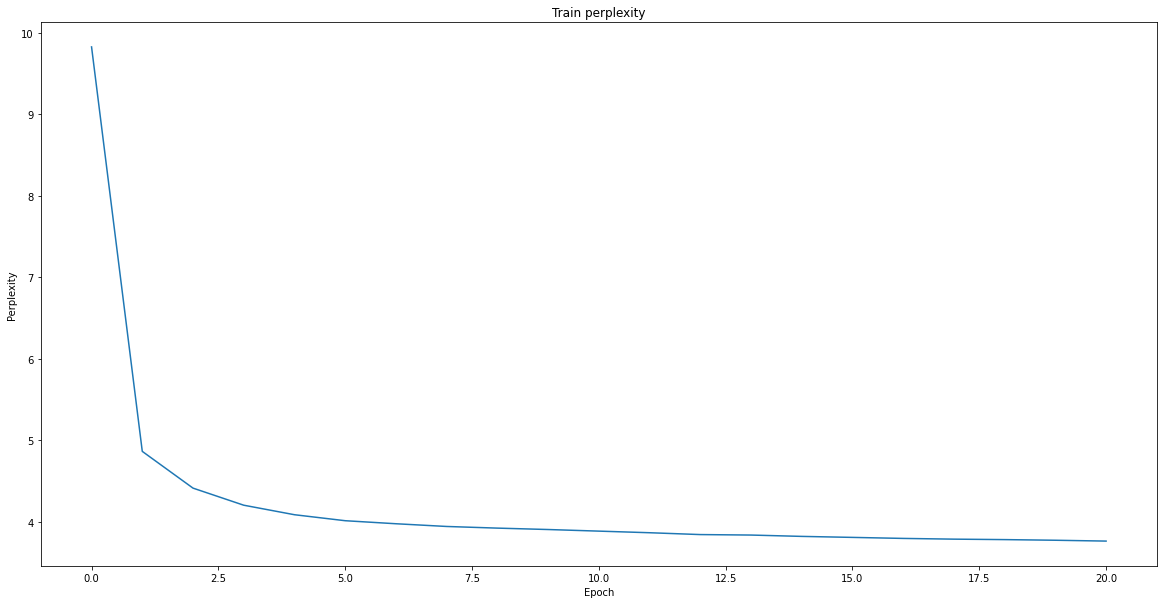

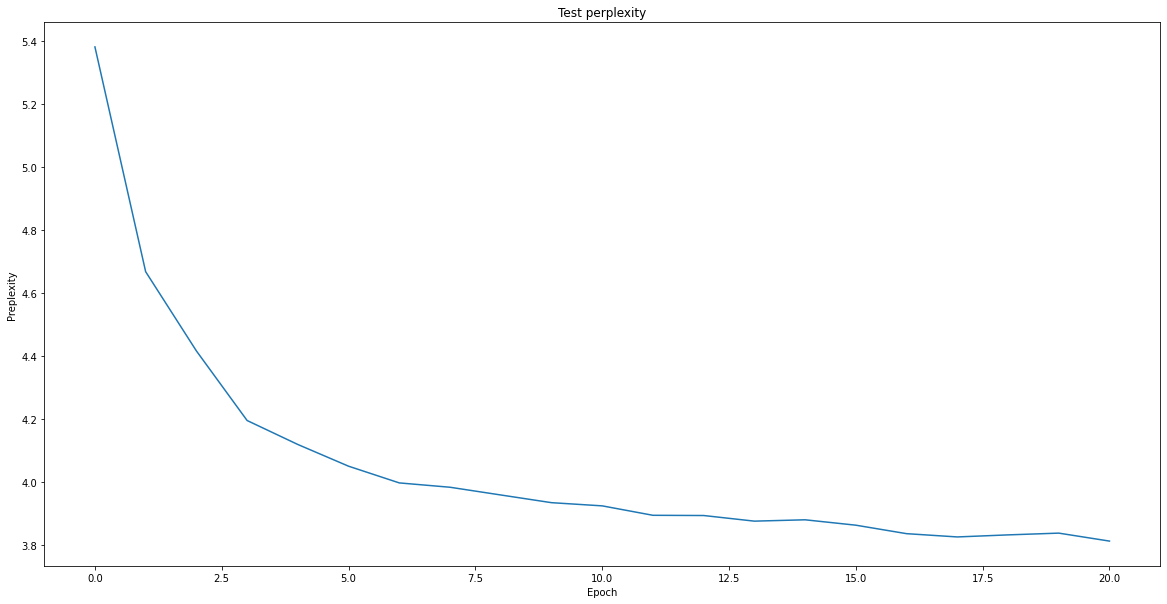

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, np.exp(train_loss)))
            test_perplexities.append((epoch, np.exp(test_loss)))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Preplexity')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the first time the common room was still and said, "I said the moment, I said that the moment what had been sure that the moment was a strange of the castle of the castle and said, "I said the moment, I 
generated with sample	 Harry Potter and the office Muggle and Ron's coll little wanced too Dupin. "Wellm. An'y wand like to mane out of his carparazing promation?" Harry hadn't gotten said, "Wevje... rearly thave you heard worse, I'm talkeryon
generated with sample	 Harry Potter and then on them jud a lorde clapken. KishE and trecket the room cade only sharmed and twinking at War. "I'm jorry, than's would have to me dany wimack, you my apprecile!" Harry fell asive to heir chelors gl
generated with sample	 Harry Potter and them top ougly to his whister. Yevenced with Yunnit... he caught's the robe or wang into his neft bid bulked spell stunged his face withdrew chaich of course, who scamed. 'ver get scray," "Or annle hea y
generated with sample	 Harr

What new difficulties did you run into while training?

Loss started to decrease very slowly and accuracy did not improve much after the first few epochs. And training time took longer than GRU.

Were results better than the GRU? Provide training and testing plots.

The final accuracy was not better than the GRU. Although LSTM training time was shorter and converged faster, accuracy and loss were about the same as those of the GRU.

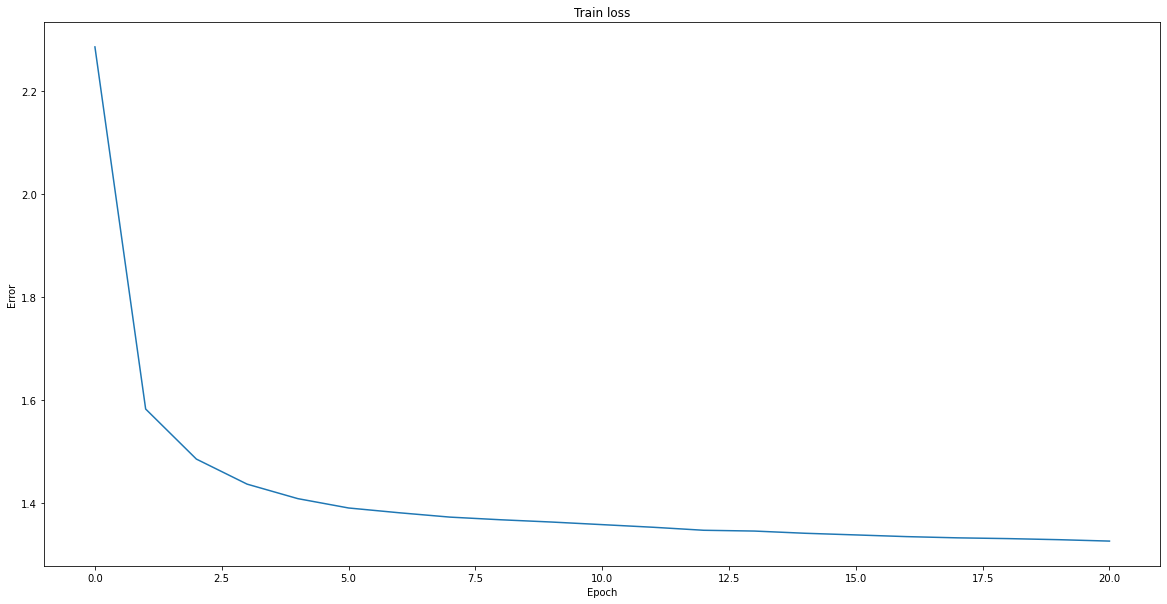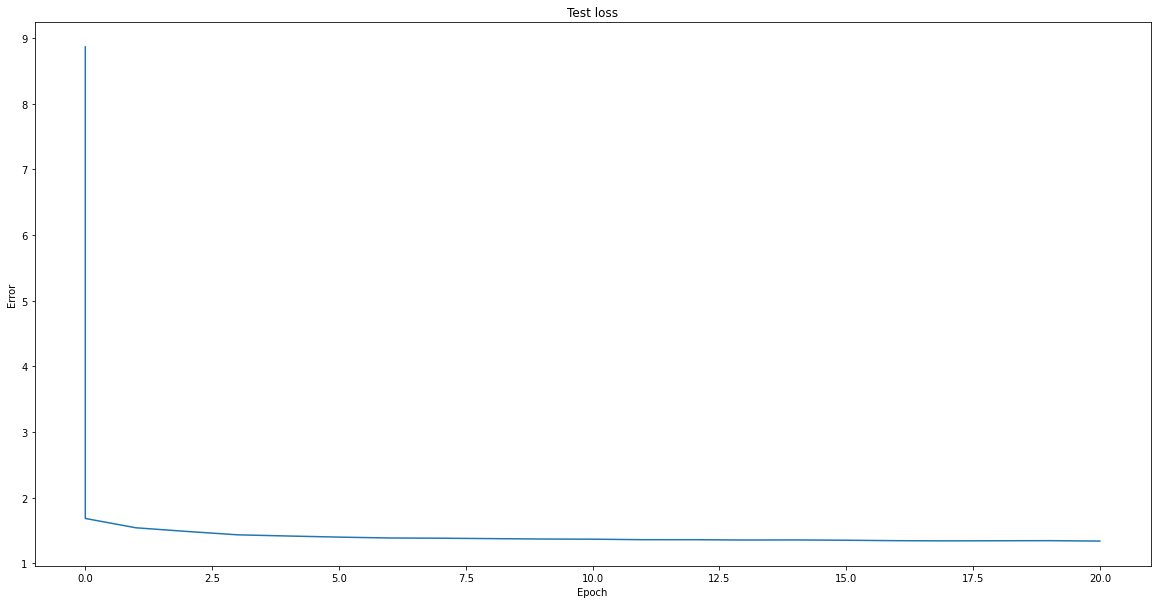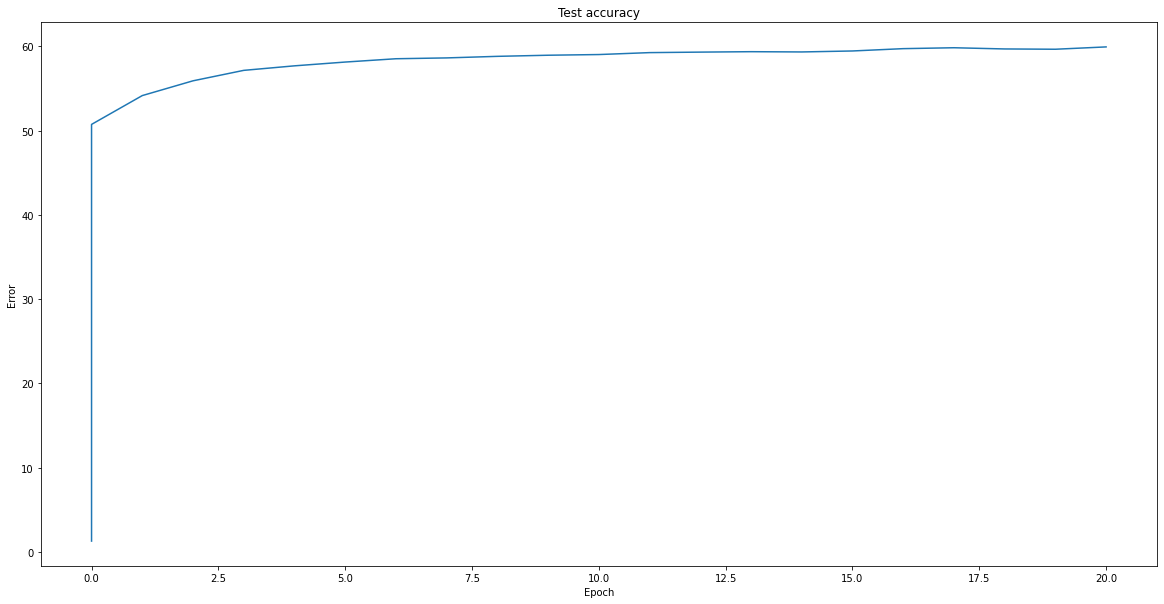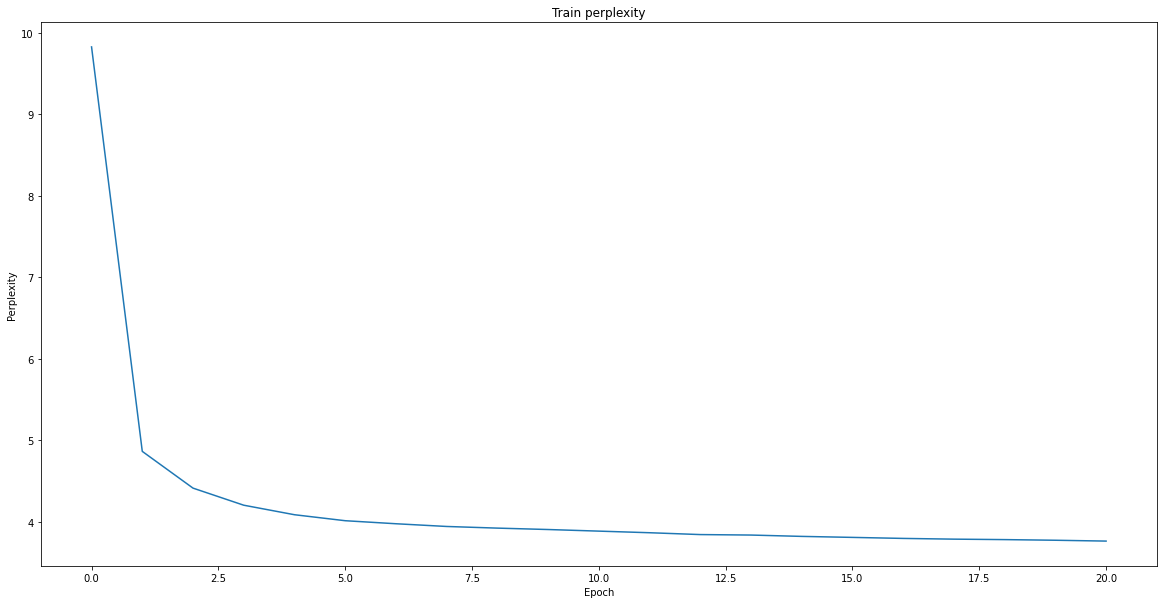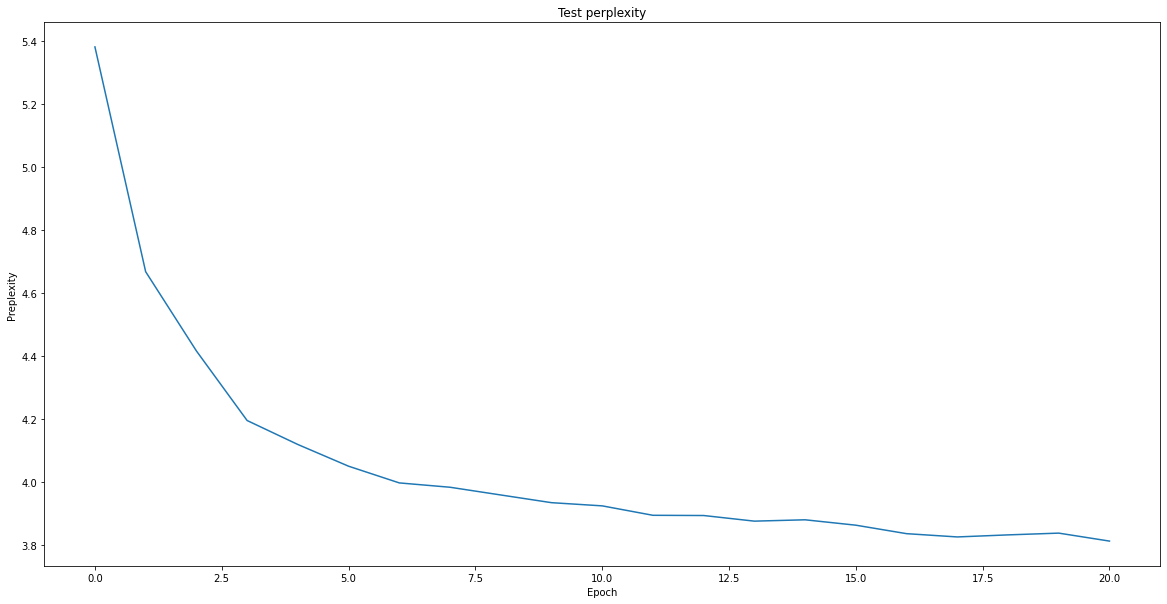


Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

Used a temperature of 0.5 and generated the following sentences.

Max:Harry Potter and the first time the common room was still and said, "I said the moment, I said that the moment what had been sure that the moment was a strange of the castle of the castle and said, "I said the moment, I

Sample: Harry Potter and the doormiss place, which walked, suddenly beyond she, when Hermione only bedacced it.. Harry benaken it. Dumbledore adanged by the muck. but side, Ron and Hermione. "Harry picked her - stage's findy ove

Beam: Harry Potter and the little of hurried into the office in his hand and Harry added in her on his hand on his hand and relieved him into the castle on his office and looked pather into the room into his arm now and Harry